In [10]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np
import pickle

In [2]:
def moving_average(x, w):
        moving_avg = np.convolve(x, np.ones(w), 'valid') / w
        padding = np.full_like(np.empty(w), np.nan)
        return np.insert(moving_avg, 0, padding)

def moving_avg_diff(short, long):
        return (short - long) / long


def get_X_y(df, binary_output=True):
    
    min_period = 24*31 + 1
    
    percent_change = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
    print(percent_change[:5])

    y = percent_change.copy()
    
    print(len(y))
    
    ## TEMP
    if binary_output == True:
        y = np.zeros(percent_change.shape)
        y[np.where(percent_change > 0)] = 1
    else:
        y = y.to_numpy()
    
    print(type(y))

    moving_average_1_hours = moving_average(df["Close"], 1)
    moving_average_2_hours = moving_average(df["Close"], 2)
    moving_average_3_hours = moving_average(df["Close"], 3)
    moving_average_12_hours = moving_average(df["Close"], 12)
    moving_average_24_hours = moving_average(df["Close"], 24)
    moving_average_48_hours = moving_average(df["Close"], 48)
    moving_average_1_week = moving_average(df["Close"], 24*7)
    moving_average_1_month = moving_average(df["Close"], 24*31)
    
    print(len(moving_average_1_month))
    
    mv_1h_2h = moving_avg_diff(moving_average_1_hours, moving_average_2_hours)
    mv_1h_3h = moving_avg_diff(moving_average_1_hours, moving_average_3_hours)
    mv_3h_12h = moving_avg_diff(moving_average_3_hours, moving_average_12_hours)
    mv_12h_24h = moving_avg_diff(moving_average_12_hours, moving_average_24_hours)
    mv_24h_48h = moving_avg_diff(moving_average_24_hours, moving_average_48_hours)
    mv_48h_1w = moving_avg_diff(moving_average_48_hours, moving_average_1_week)
    mv_1w_1m = moving_avg_diff(moving_average_1_week, moving_average_1_month)
    
    print(len(mv_1w_1m))
    
    X = np.stack((mv_1h_2h, mv_1h_3h, mv_3h_12h, mv_12h_24h, mv_24h_48h, mv_48h_1w, mv_1w_1m), axis=1)
    X = X[min_period:len(X)-1]
    y = y[min_period:]
    
    print(len(X), len(y))
    
    return (X, y)

In [3]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2015,7,1)
df = df[df["Time"] > start_date]

offset = 24*31 + 1 # TODO: Refactor to output ox get_features
X, y = get_X_y(df)
df = df[offset:]
for i in range(0, len(X[0,:])):
    df["X_" + str(i)] = X[:,i]
df.describe()
print(df.columns)

Time
2015-07-20 21:00:00         NaN
2015-07-20 22:00:00    0.000504
2015-07-20 23:00:00    0.006687
2015-07-21 00:00:00    0.003179
2015-07-21 01:00:00   -0.001887
Name: Close, dtype: float64
47698
<class 'numpy.ndarray'>
47699
47699
46953 46953
Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6'],
      dtype='object')


In [4]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [5]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    data = bt.feeds.PandasData(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


In [20]:
# Create a Stratey
class NNStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.X_0 = self.datas[0].X_0
        self.X_1 = self.datas[0].X_1
        self.X_2 = self.datas[0].X_2
        self.X_3 = self.datas[0].X_3
        self.X_4 = self.datas[0].X_4
        self.X_5 = self.datas[0].X_5
        self.X_6 = self.datas[0].X_6

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        filename = "../../models/pickles/svm_binary_classifier"
        self.clf = pickle.load(open(filename, 'rb'))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
    
        X = [[self.X_0[0], self.X_1[0], self.X_2[0], self.X_3[0], self.X_4[0], self.X_5[0], self.X_6[0]]]
        pred = self.clf.predict(X)[0]
        print(pred)
        if not self.position:
            if pred == 1:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                
                # Cancel existing orders 
                self.broker.cancel(self.order)
                
                cash = self.broker.get_cash()
                limit_price = self.data.close[0] * 1.005
                size = cash * 0.95 / limit_price
                print(cash, self.data.close[0], limit_price, size)
                
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                self.buy(exectype=bt.Order.Limit, size=size)
        elif self.position and pred == 0:
            
            ## TODO: figure out why it never sells all it's position
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            size = self.broker.get_value() / self.dataclose[0]
            self.sell(size=self.position.size)


class PandasData(bt.feeds.PandasData):
    params = (
        ('X_0', 'X_0'),
        ('X_1', 'X_1'),
        ('X_2', 'X_2'),
        ('X_3', 'X_3'),
        ('X_4', 'X_4'),
        ('X_5', 'X_5'),
        ('X_6', 'X_6'),
    )
    lines = ('X_0','X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6')

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(NNStrategy)

    data = PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    cerebro.broker.addcommissioninfo(CommInfoFractional())
    cerebro.broker.setcommission(commission=0.005, margin=False) 
    
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strats = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2015-08-20, Close, 236.60
0.0
2015-08-20, Close, 235.56
0.0
2015-08-21, Close, 235.76
1.0
2015-08-21, BUY CREATE, 235.76
10000.0 235.76 236.93879999999996 40.094741764540046
2015-08-21, BUY EXECUTED, Price: 235.75, Cost: 235.75, Comm 1.18
2015-08-21, BUY EXECUTED, Price: 235.75, Cost: 9452.34, Comm 47.26
2015-08-21, Close, 234.04
0.0
2015-08-21, SELL CREATE, 234.04
2015-08-21, SELL EXECUTED, Price: 234.05, Cost: 9688.09, Comm 48.09
2015-08-21, OPERATION PROFIT, GROSS -69.86, NET -166.39
2015-08-21, Close, 233.85
1.0
2015-08-21, BUY CREATE, 233.85
9833.607390595376 233.85 235.01924999999997 39.74962485441345
2015-08-21, BUY EXECUTED, Price: 233.88, Cost: 233.88, Comm 1.17
2015-08-21, BUY EXECUTED, Price: 233.85, Cost: 9295.45, Comm 46.48
2015-08-21, Close, 236.07
1.0
2015-08-21, Close, 235.27
0.0
2015-08-21, SELL CREATE, 235.27
2015-08-21, SELL EXECUTED, Price: 235.27, Cost: 9529.33, Comm 47.94
2015-08-21, OPERATION PROFIT, GROSS 57.83, NET -37.75
2015

0.0
2015-08-30, SELL CREATE, 229.39
2015-08-31, SELL EXECUTED, Price: 229.40, Cost: 6365.80, Comm 31.99
2015-08-31, OPERATION PROFIT, GROSS 31.79, NET -32.02
2015-08-31, Close, 229.23
0.0
2015-08-31, Close, 227.71
0.0
2015-08-31, Close, 228.56
1.0
2015-08-31, BUY CREATE, 228.56
6461.698303275492 228.56 229.70279999999997 26.724155683394883
2015-08-31, BUY EXECUTED, Price: 228.47, Cost: 228.47, Comm 1.14
2015-08-31, BUY EXECUTED, Price: 228.47, Cost: 6105.67, Comm 30.53
2015-08-31, Close, 227.90
0.0
2015-08-31, SELL CREATE, 227.90
2015-08-31, SELL EXECUTED, Price: 227.89, Cost: 6334.14, Comm 31.59
2015-08-31, OPERATION PROFIT, GROSS -16.08, NET -79.34
2015-08-31, Close, 228.15
1.0
2015-08-31, BUY CREATE, 228.15
6382.357314540751 228.15 229.29074999999997 26.443454211797526
2015-08-31, BUY EXECUTED, Price: 228.15, Cost: 228.15, Comm 1.14
2015-08-31, BUY EXECUTED, Price: 228.15, Cost: 6033.07, Comm 30.17
2015-08-31, Close, 228.20
1.0
2015-08-31, Close, 228.06
1.0
2015-08-31, Close, 227.46

2015-09-05, Close, 234.51
0.0
2015-09-05, Close, 234.75
0.0
2015-09-05, Close, 235.87
0.0
2015-09-05, Close, 235.33
0.0
2015-09-05, Close, 235.35
0.0
2015-09-05, Close, 236.00
0.0
2015-09-05, Close, 235.43
0.0
2015-09-05, Close, 236.09
1.0
2015-09-05, BUY CREATE, 236.09
5146.32889351459 236.09 237.27044999999998 20.605231072132497
2015-09-05, BUY EXECUTED, Price: 236.09, Cost: 236.09, Comm 1.18
2015-09-05, BUY EXECUTED, Price: 236.09, Cost: 4864.69, Comm 24.32
2015-09-05, Close, 236.78
0.0
2015-09-05, SELL CREATE, 236.78
2015-09-05, SELL EXECUTED, Price: 236.76, Cost: 5100.78, Comm 25.58
2015-09-05, OPERATION PROFIT, GROSS 14.48, NET -36.60
2015-09-05, Close, 236.01
0.0
2015-09-06, Close, 236.38
1.0
2015-09-06, BUY CREATE, 236.38
5109.724230770629 236.38 237.56189999999998 20.433571289133898
2015-09-06, BUY EXECUTED, Price: 236.24, Cost: 236.24, Comm 1.18
2015-09-06, BUY EXECUTED, Price: 236.24, Cost: 4827.23, Comm 24.14
2015-09-06, Close, 237.33
1.0
2015-09-06, Close, 239.51
0.0
2015-

2015-09-14, Order Canceled/Margin/Rejected
2015-09-14, BUY EXECUTED, Price: 230.05, Cost: 230.05, Comm 1.15
2015-09-14, Close, 229.81
0.0
2015-09-14, SELL CREATE, 229.81
2015-09-14, SELL EXECUTED, Price: 229.84, Cost: 230.05, Comm 1.15
2015-09-14, OPERATION PROFIT, GROSS -0.21, NET -2.51
2015-09-14, Close, 229.61
1.0
2015-09-14, BUY CREATE, 229.61
4616.830766788009 229.61 230.75805 19.0068742063326
2015-09-14, BUY EXECUTED, Price: 229.61, Cost: 229.61, Comm 1.15
2015-09-14, BUY EXECUTED, Price: 229.61, Cost: 4364.17, Comm 21.82
2015-09-14, Close, 229.55
1.0
2015-09-14, Close, 229.85
1.0
2015-09-14, Close, 231.73
1.0
2015-09-14, Close, 231.67
0.0
2015-09-14, SELL CREATE, 231.67
2015-09-14, SELL EXECUTED, Price: 231.68, Cost: 4593.78, Comm 23.18
2015-09-14, OPERATION PROFIT, GROSS 41.41, NET -4.73
2015-09-14, Close, 233.17
0.0
2015-09-14, Close, 232.38
0.0
2015-09-14, Close, 232.28
1.0
2015-09-14, BUY CREATE, 232.28
4612.100141381922 232.28 233.4414 18.769143495167636
2015-09-14, Order C

2015-09-22, Order Canceled/Margin/Rejected
2015-09-22, BUY EXECUTED, Price: 231.16, Cost: 231.16, Comm 1.16
2015-09-22, Close, 231.04
1.0
2015-09-22, Close, 231.25
1.0
2015-09-22, Close, 231.26
1.0
2015-09-22, Close, 231.31
1.0
2015-09-22, Close, 230.70
1.0
2015-09-22, Close, 230.35
1.0
2015-09-22, Close, 230.38
1.0
2015-09-22, Close, 231.28
1.0
2015-09-23, Close, 232.26
0.0
2015-09-23, SELL CREATE, 232.26
2015-09-23, SELL EXECUTED, Price: 232.26, Cost: 231.16, Comm 1.16
2015-09-23, OPERATION PROFIT, GROSS 1.10, NET -1.22
2015-09-23, Close, 232.63
0.0
2015-09-23, Close, 231.80
0.0
2015-09-23, Close, 231.99
1.0
2015-09-23, BUY CREATE, 231.99
4518.7705454159395 231.99 233.14995 18.412322276479763
2015-09-23, Order Canceled/Margin/Rejected
2015-09-23, BUY EXECUTED, Price: 232.00, Cost: 232.00, Comm 1.16
2015-09-23, Close, 231.61
1.0
2015-09-23, Close, 232.03
1.0
2015-09-23, Close, 231.98
0.0
2015-09-23, SELL CREATE, 231.98
2015-09-23, SELL EXECUTED, Price: 231.98, Cost: 232.00, Comm 1.16


2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, BUY EXECUTED, Price: 238.14, Cost: 238.14, Comm 1.19
2015-10-02, Close, 238.53
1.0
2015-10-02, Close, 237.94
0.0
2015-10-02, SELL CREATE, 237.94
2015-10-02, SELL EXECUTED, Price: 237.98, Cost: 238.14, Comm 1.19
2015-10-02, OPERATION PROFIT, GROSS -0.16, NET -2.54
2015-10-02, Close, 237.94
1.0
2015-10-02, BUY CREATE, 237.94
4436.72604541594 237.94 239.12969999999999 17.625956722001252
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, BUY EXECUTED, Price: 237.94, Cost: 237.94, Comm 1.19
2015-10-02, Close, 237.99
1.0
2015-10-02, Close, 237.82
1.0
2015-10-02, Close, 238.03
1.0
2015-10-02, Close, 237.68
1.0
2015-10-02, Close, 238.28
1.0
2015-10-03, Close, 238.25
0.0
2015-10-03, SELL CREATE, 238.25
2015-10-03, SELL EXECUTED, Price: 238.20, Cost: 237.94, Comm 1.19
2015-10-03, OPERATION PROFIT, GROSS 0.26, NET -2.12
2015-10-03, Close, 238.36
0.0
2015-10-03, Close, 238.70
1.0
2015-10-03, BUY CREATE, 238.70
4434.60534541594 238.7 239.89

2015-10-09, Close, 244.52
1.0
2015-10-09, BUY CREATE, 244.52
4365.843045415937 244.52 245.74259999999998 16.877622736738115
2015-10-09, Order Canceled/Margin/Rejected
2015-10-09, BUY EXECUTED, Price: 244.55, Cost: 244.55, Comm 1.22
2015-10-09, Close, 244.79
1.0
2015-10-09, Close, 244.74
0.0
2015-10-09, SELL CREATE, 244.74
2015-10-09, SELL EXECUTED, Price: 244.68, Cost: 244.55, Comm 1.22
2015-10-09, OPERATION PROFIT, GROSS 0.13, NET -2.32
2015-10-09, Close, 244.62
1.0
2015-10-09, BUY CREATE, 244.62
4363.526895415937 244.62 245.8431 16.86177301964196
2015-10-09, Order Canceled/Margin/Rejected
2015-10-09, BUY EXECUTED, Price: 244.62, Cost: 244.62, Comm 1.22
2015-10-09, Close, 244.41
1.0
2015-10-09, Close, 244.61
1.0
2015-10-09, Close, 244.43
1.0
2015-10-09, Close, 244.45
1.0
2015-10-09, Close, 244.35
1.0
2015-10-10, Close, 244.99
1.0
2015-10-10, Close, 245.24
0.0
2015-10-10, SELL CREATE, 245.24
2015-10-10, SELL EXECUTED, Price: 245.25, Cost: 244.62, Comm 1.23
2015-10-10, OPERATION PROFIT,

2015-10-18, Order Canceled/Margin/Rejected
2015-10-18, BUY EXECUTED, Price: 264.61, Cost: 264.61, Comm 1.32
2015-10-18, Close, 265.16
1.0
2015-10-18, Close, 265.00
0.0
2015-10-18, SELL CREATE, 265.00
2015-10-19, SELL EXECUTED, Price: 265.00, Cost: 264.61, Comm 1.32
2015-10-19, OPERATION PROFIT, GROSS 0.39, NET -2.26
2015-10-19, Close, 265.83
1.0
2015-10-19, BUY CREATE, 265.83
4299.015695415942 265.83 267.15914999999995 15.287011171599945
2015-10-19, Order Canceled/Margin/Rejected
2015-10-19, BUY EXECUTED, Price: 265.84, Cost: 265.84, Comm 1.33
2015-10-19, Close, 266.22
0.0
2015-10-19, SELL CREATE, 266.22
2015-10-19, SELL EXECUTED, Price: 266.23, Cost: 265.84, Comm 1.33
2015-10-19, OPERATION PROFIT, GROSS 0.39, NET -2.27
2015-10-19, Close, 266.14
0.0
2015-10-19, Close, 267.21
0.0
2015-10-19, Close, 266.15
0.0
2015-10-19, Close, 264.88
1.0
2015-10-19, BUY CREATE, 264.88
4296.745345415942 264.88 266.20439999999996 15.333736324963619
2015-10-19, Order Canceled/Margin/Rejected
2015-10-19, B

1.0
2015-10-28, Close, 303.24
1.0
2015-10-28, Close, 304.09
1.0
2015-10-29, Close, 304.61
1.0
2015-10-29, Close, 304.07
1.0
2015-10-29, Close, 305.91
1.0
2015-10-29, Close, 305.29
0.0
2015-10-29, SELL CREATE, 305.29
2015-10-29, SELL EXECUTED, Price: 305.32, Cost: 302.74, Comm 1.53
2015-10-29, OPERATION PROFIT, GROSS 2.58, NET -0.46
2015-10-29, Close, 306.78
1.0
2015-10-29, BUY CREATE, 306.78
4280.603695415942 306.78 308.31389999999993 13.189718370288025
2015-10-29, Order Canceled/Margin/Rejected
2015-10-29, BUY EXECUTED, Price: 306.82, Cost: 306.82, Comm 1.53
2015-10-29, Close, 306.94
0.0
2015-10-29, SELL CREATE, 306.94
2015-10-29, SELL EXECUTED, Price: 306.83, Cost: 306.82, Comm 1.53
2015-10-29, OPERATION PROFIT, GROSS 0.01, NET -3.06
2015-10-29, Close, 306.94
1.0
2015-10-29, BUY CREATE, 306.94
4277.545445415942 306.94 308.4747 13.173424508217837
2015-10-29, Order Canceled/Margin/Rejected
2015-10-29, BUY EXECUTED, Price: 306.94, Cost: 306.94, Comm 1.53
2015-10-29, Close, 306.34
1.0
20

2015-11-06, Close, 365.81
1.0
2015-11-06, Close, 359.25
1.0
2015-11-06, Close, 359.34
1.0
2015-11-06, Close, 359.00
1.0
2015-11-06, Close, 367.13
1.0
2015-11-06, Close, 375.47
1.0
2015-11-06, Close, 366.11
0.0
2015-11-06, SELL CREATE, 366.11
2015-11-06, SELL EXECUTED, Price: 366.34, Cost: 408.00, Comm 1.83
2015-11-06, OPERATION PROFIT, GROSS -41.66, NET -45.53
2015-11-06, Close, 369.91
1.0
2015-11-06, BUY CREATE, 369.91
4284.196545415941 369.91 371.75955 10.94790091645297
2015-11-06, Order Canceled/Margin/Rejected
2015-11-06, BUY EXECUTED, Price: 369.91, Cost: 369.91, Comm 1.85
2015-11-06, Close, 367.16
1.0
2015-11-06, Close, 372.01
1.0
2015-11-06, Close, 378.28
0.0
2015-11-06, SELL CREATE, 378.28
2015-11-06, SELL EXECUTED, Price: 378.42, Cost: 369.91, Comm 1.89
2015-11-06, OPERATION PROFIT, GROSS 8.51, NET 4.77
2015-11-06, Close, 376.46
0.0
2015-11-06, Close, 375.63
0.0
2015-11-06, Close, 385.46
1.0
2015-11-06, BUY CREATE, 385.46
4288.964895415941 385.46 387.3872999999999 10.517940703

2015-11-14, SELL EXECUTED, Price: 337.63, Cost: 335.06, Comm 1.69
2015-11-14, OPERATION PROFIT, GROSS 2.57, NET -0.79
2015-11-14, Close, 336.28
0.0
2015-11-14, Close, 333.80
1.0
2015-11-14, BUY CREATE, 333.80
4227.3420454159395 333.8 335.469 11.97122518964537
2015-11-14, Order Canceled/Margin/Rejected
2015-11-14, BUY EXECUTED, Price: 333.80, Cost: 333.80, Comm 1.67
2015-11-14, Close, 333.02
1.0
2015-11-14, Close, 331.59
1.0
2015-11-14, Close, 331.82
1.0
2015-11-14, Close, 333.88
1.0
2015-11-14, Close, 333.95
0.0
2015-11-14, SELL CREATE, 333.95
2015-11-14, SELL EXECUTED, Price: 333.91, Cost: 333.80, Comm 1.67
2015-11-14, OPERATION PROFIT, GROSS 0.11, NET -3.23
2015-11-14, Close, 333.00
0.0
2015-11-14, Close, 332.95
1.0
2015-11-14, BUY CREATE, 332.95
4224.11349541594 332.95 334.61474999999996 11.992620829312346
2015-11-14, Order Canceled/Margin/Rejected
2015-11-14, BUY EXECUTED, Price: 332.94, Cost: 332.94, Comm 1.66
2015-11-14, Close, 333.78
1.0
2015-11-14, Close, 333.98
0.0
2015-11-14,

2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, BUY EXECUTED, Price: 336.32, Cost: 336.32, Comm 1.68
2015-11-19, Close, 333.99
1.0
2015-11-19, Close, 334.77
1.0
2015-11-19, Close, 334.98
1.0
2015-11-19, Close, 334.35
1.0
2015-11-19, Close, 334.31
1.0
2015-11-19, Close, 334.60
1.0
2015-11-19, Close, 334.51
1.0
2015-11-19, Close, 334.57
1.0
2015-11-19, Close, 334.62
1.0
2015-11-19, Close, 334.67
1.0
2015-11-19, Close, 334.84
1.0
2015-11-19, Close, 327.00
1.0
2015-11-19, Close, 328.61
1.0
2015-11-19, Close, 327.75
1.0
2015-11-19, Close, 327.14
1.0
2015-11-19, Close, 326.85
1.0
2015-11-19, Close, 328.00
1.0
2015-11-19, Close, 328.78
0.0
2015-11-19, SELL CREATE, 328.78
2015-11-19, SELL EXECUTED, Price: 328.76, Cost: 336.32, Comm 1.64
2015-11-19, OPERATION PROFIT, GROSS -7.56, NET -10.89
2015-11-19, Close, 328.45
0.0
2015-11-19, Close, 329.00
1.0
2015-11-19, BUY CREATE, 329.00
4114.307345415942 329.0 330.645 11.8211132124942
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, BUY E

4039.179995415943 333.21 334.87604999999996 11.45863072514486
2015-11-26, Order Canceled/Margin/Rejected
2015-11-26, BUY EXECUTED, Price: 333.22, Cost: 333.22, Comm 1.67
2015-11-26, Close, 336.97
0.0
2015-11-26, SELL CREATE, 336.97
2015-11-26, SELL EXECUTED, Price: 336.96, Cost: 333.22, Comm 1.68
2015-11-26, OPERATION PROFIT, GROSS 3.74, NET 0.39
2015-11-26, Close, 340.00
0.0
2015-11-26, Close, 341.61
0.0
2015-11-26, Close, 347.51
0.0
2015-11-26, Close, 355.41
0.0
2015-11-26, Close, 351.85
0.0
2015-11-26, Close, 354.41
0.0
2015-11-26, Close, 350.81
0.0
2015-11-26, Close, 346.99
1.0
2015-11-26, BUY CREATE, 346.99
4039.569095415943 346.99 348.72495 11.004634571300809
2015-11-26, Order Canceled/Margin/Rejected
2015-11-26, BUY EXECUTED, Price: 346.55, Cost: 346.55, Comm 1.73
2015-11-26, Close, 344.04
1.0
2015-11-26, Close, 348.54
1.0
2015-11-26, Close, 350.12
1.0
2015-11-26, Close, 346.00
1.0
2015-11-26, Close, 347.21
1.0
2015-11-26, Close, 349.15
1.0
2015-11-26, Close, 351.09
1.0
2015-11-

0.0
2015-12-01, Close, 360.40
0.0
2015-12-01, Close, 363.20
1.0
2015-12-01, BUY CREATE, 363.20
3977.871595415944 363.2 365.01599999999996 10.352910600206968
2015-12-01, Order Canceled/Margin/Rejected
2015-12-01, BUY EXECUTED, Price: 363.18, Cost: 363.18, Comm 1.82
2015-12-01, Close, 362.68
0.0
2015-12-01, SELL CREATE, 362.68
2015-12-02, SELL EXECUTED, Price: 362.68, Cost: 363.18, Comm 1.81
2015-12-02, OPERATION PROFIT, GROSS -0.50, NET -4.13
2015-12-02, Close, 354.03
0.0
2015-12-02, Close, 347.60
1.0
2015-12-02, BUY CREATE, 347.60
3973.7422954159438 347.6 349.33799999999997 10.806311310665162
2015-12-02, Order Canceled/Margin/Rejected
2015-12-02, BUY EXECUTED, Price: 347.57, Cost: 347.57, Comm 1.74
2015-12-02, Close, 352.03
1.0
2015-12-02, Close, 352.02
0.0
2015-12-02, SELL CREATE, 352.02
2015-12-02, SELL EXECUTED, Price: 352.03, Cost: 347.57, Comm 1.76
2015-12-02, OPERATION PROFIT, GROSS 4.46, NET 0.96
2015-12-02, Close, 351.22
1.0
2015-12-02, BUY CREATE, 351.22
3974.7042954159433 351

2015-12-08, Close, 395.48
1.0
2015-12-08, Close, 395.96
1.0
2015-12-08, Close, 395.35
1.0
2015-12-08, Close, 418.94
1.0
2015-12-09, Close, 415.13
0.0
2015-12-09, SELL CREATE, 415.13
2015-12-09, SELL EXECUTED, Price: 415.13, Cost: 394.74, Comm 2.08
2015-12-09, OPERATION PROFIT, GROSS 20.39, NET 16.34
2015-12-09, Close, 413.30
0.0
2015-12-09, Close, 416.00
1.0
2015-12-09, BUY CREATE, 416.00
3962.5535954159423 416.0 418.0799999999999 9.004080356977482
2015-12-09, Order Canceled/Margin/Rejected
2015-12-09, BUY EXECUTED, Price: 415.86, Cost: 415.86, Comm 2.08
2015-12-09, Close, 419.09
0.0
2015-12-09, SELL CREATE, 419.09
2015-12-09, SELL EXECUTED, Price: 419.67, Cost: 415.86, Comm 2.10
2015-12-09, OPERATION PROFIT, GROSS 3.81, NET -0.37
2015-12-09, Close, 416.56
0.0
2015-12-09, Close, 417.76
1.0
2015-12-09, BUY CREATE, 417.76
3962.185945415942 417.76 419.8487999999999 8.965314770805932
2015-12-09, Order Canceled/Margin/Rejected
2015-12-09, BUY EXECUTED, Price: 417.75, Cost: 417.75, Comm 2.09

2015-12-18, Order Canceled/Margin/Rejected
2015-12-18, BUY EXECUTED, Price: 459.38, Cost: 459.38, Comm 2.30
2015-12-18, Close, 458.91
1.0
2015-12-18, Close, 459.44
1.0
2015-12-18, Close, 458.22
1.0
2015-12-18, Close, 458.77
1.0
2015-12-18, Close, 460.14
1.0
2015-12-18, Close, 460.01
1.0
2015-12-18, Close, 459.12
1.0
2015-12-18, Close, 459.99
1.0
2015-12-18, Close, 460.00
1.0
2015-12-18, Close, 459.47
1.0
2015-12-18, Close, 460.44
1.0
2015-12-18, Close, 463.82
1.0
2015-12-18, Close, 461.83
0.0
2015-12-18, SELL CREATE, 461.83
2015-12-18, SELL EXECUTED, Price: 461.82, Cost: 459.38, Comm 2.31
2015-12-18, OPERATION PROFIT, GROSS 2.44, NET -2.17
2015-12-18, Close, 463.35
1.0
2015-12-18, BUY CREATE, 463.35
3964.2140454159426 463.35 465.66675 8.087335724840019
2015-12-18, Order Canceled/Margin/Rejected
2015-12-18, BUY EXECUTED, Price: 463.35, Cost: 463.35, Comm 2.32
2015-12-18, Close, 463.17
1.0
2015-12-19, Close, 463.82
1.0
2015-12-19, Close, 464.04
1.0
2015-12-19, Close, 463.84
1.0
2015-12-1

2015-12-26, SELL EXECUTED, Price: 426.53, Cost: 427.70, Comm 2.13
2015-12-26, OPERATION PROFIT, GROSS -1.17, NET -5.44
2015-12-26, Close, 416.03
0.0
2015-12-26, Close, 426.00
1.0
2015-12-26, BUY CREATE, 426.00
3820.0124454159427 426.0 428.12999999999994 8.476424971726217
2015-12-26, Order Canceled/Margin/Rejected
2015-12-26, BUY EXECUTED, Price: 426.07, Cost: 426.07, Comm 2.13
2015-12-26, Close, 423.83
0.0
2015-12-26, SELL CREATE, 423.83
2015-12-26, SELL EXECUTED, Price: 423.81, Cost: 426.07, Comm 2.12
2015-12-26, OPERATION PROFIT, GROSS -2.26, NET -6.51
2015-12-26, Close, 426.58
0.0
2015-12-26, Close, 426.62
0.0
2015-12-26, Close, 417.85
0.0
2015-12-26, Close, 418.02
1.0
2015-12-26, BUY CREATE, 418.02
3813.503045415943 418.02 420.11009999999993 8.623520103766003
2015-12-26, Order Canceled/Margin/Rejected
2015-12-26, BUY EXECUTED, Price: 418.03, Cost: 418.03, Comm 2.09
2015-12-26, Close, 419.41
1.0
2015-12-27, Close, 413.97
0.0
2015-12-27, SELL CREATE, 413.97
2015-12-27, SELL EXECUTED,

1.0
2016-01-03, Close, 433.43
1.0
2016-01-03, Close, 434.00
1.0
2016-01-03, Close, 433.56
1.0
2016-01-03, Close, 434.49
1.0
2016-01-03, Close, 433.07
0.0
2016-01-03, SELL CREATE, 433.07
2016-01-03, SELL EXECUTED, Price: 433.07, Cost: 435.40, Comm 2.17
2016-01-03, OPERATION PROFIT, GROSS -2.33, NET -6.67
2016-01-03, Close, 432.88
1.0
2016-01-03, BUY CREATE, 432.88
3707.1235454159396 432.88 435.04439999999994 8.095190670527291
2016-01-03, Order Canceled/Margin/Rejected
2016-01-03, BUY EXECUTED, Price: 432.96, Cost: 432.96, Comm 2.16
2016-01-03, Close, 432.88
1.0
2016-01-03, Close, 432.56
1.0
2016-01-03, Close, 432.03
1.0
2016-01-03, Close, 432.05
1.0
2016-01-03, Close, 431.78
1.0
2016-01-03, Close, 429.17
1.0
2016-01-03, Close, 428.71
1.0
2016-01-03, Close, 429.80
1.0
2016-01-03, Close, 429.19
0.0
2016-01-03, SELL CREATE, 429.19
2016-01-03, SELL EXECUTED, Price: 429.18, Cost: 432.96, Comm 2.15
2016-01-03, OPERATION PROFIT, GROSS -3.78, NET -8.09
2016-01-03, Close, 428.75
1.0
2016-01-03, 

2016-01-10, BUY CREATE, 445.05
3591.351845415938 445.05 447.27524999999997 7.6279299003133785
2016-01-10, Order Canceled/Margin/Rejected
2016-01-10, BUY EXECUTED, Price: 445.05, Cost: 445.05, Comm 2.23
2016-01-10, Close, 445.88
0.0
2016-01-10, SELL CREATE, 445.88
2016-01-10, SELL EXECUTED, Price: 445.88, Cost: 445.05, Comm 2.23
2016-01-10, OPERATION PROFIT, GROSS 0.83, NET -3.62
2016-01-10, Close, 447.70
0.0
2016-01-10, Close, 448.04
0.0
2016-01-10, Close, 447.10
0.0
2016-01-10, Close, 447.29
1.0
2016-01-10, BUY CREATE, 447.29
3587.727195415938 447.29 449.52644999999995 7.5820696104648375
2016-01-10, Order Canceled/Margin/Rejected
2016-01-10, BUY EXECUTED, Price: 447.29, Cost: 447.29, Comm 2.24
2016-01-10, Close, 448.23
1.0
2016-01-10, Close, 448.89
0.0
2016-01-10, SELL CREATE, 448.89
2016-01-10, SELL EXECUTED, Price: 448.90, Cost: 447.29, Comm 2.24
2016-01-10, OPERATION PROFIT, GROSS 1.61, NET -2.87
2016-01-10, Close, 449.99
0.0
2016-01-11, Close, 451.31
0.0
2016-01-11, Close, 452.25


2016-01-16, Order Canceled/Margin/Rejected
2016-01-16, BUY EXECUTED, Price: 382.34, Cost: 382.34, Comm 1.91
2016-01-16, Close, 388.70
1.0
2016-01-17, Close, 390.47
0.0
2016-01-17, SELL CREATE, 390.47
2016-01-17, SELL EXECUTED, Price: 390.55, Cost: 382.34, Comm 1.95
2016-01-17, OPERATION PROFIT, GROSS 8.21, NET 4.35
2016-01-17, Close, 389.72
0.0
2016-01-17, Close, 389.66
1.0
2016-01-17, BUY CREATE, 389.66
3451.2261954159367 389.66 391.6083 8.37230693436564
2016-01-17, Order Canceled/Margin/Rejected
2016-01-17, BUY EXECUTED, Price: 389.51, Cost: 389.51, Comm 1.95
2016-01-17, Close, 383.92
1.0
2016-01-17, Close, 385.34
1.0
2016-01-17, Close, 383.56
1.0
2016-01-17, Close, 383.57
1.0
2016-01-17, Close, 380.17
1.0
2016-01-17, Close, 381.82
1.0
2016-01-17, Close, 383.46
1.0
2016-01-17, Close, 380.69
0.0
2016-01-17, SELL CREATE, 380.69
2016-01-17, SELL EXECUTED, Price: 380.68, Cost: 389.51, Comm 1.90
2016-01-17, OPERATION PROFIT, GROSS -8.83, NET -12.68
2016-01-17, Close, 379.91
1.0
2016-01-17

2016-01-23, Close, 385.95
1.0
2016-01-23, Close, 386.96
1.0
2016-01-23, Close, 391.96
1.0
2016-01-23, Close, 389.56
0.0
2016-01-23, SELL CREATE, 389.56
2016-01-23, SELL EXECUTED, Price: 389.94, Cost: 390.85, Comm 1.95
2016-01-23, OPERATION PROFIT, GROSS -0.91, NET -4.81
2016-01-23, Close, 389.44
1.0
2016-01-23, BUY CREATE, 389.44
3381.6374454159345 389.44 391.38719999999995 8.208126308538292
2016-01-23, Order Canceled/Margin/Rejected
2016-01-23, BUY EXECUTED, Price: 389.90, Cost: 389.90, Comm 1.95
2016-01-23, Close, 390.47
1.0
2016-01-23, Close, 392.78
0.0
2016-01-23, SELL CREATE, 392.78
2016-01-23, SELL EXECUTED, Price: 392.78, Cost: 389.90, Comm 1.96
2016-01-23, OPERATION PROFIT, GROSS 2.88, NET -1.03
2016-01-23, Close, 391.17
0.0
2016-01-23, Close, 391.47
1.0
2016-01-23, BUY CREATE, 391.47
3380.6040454159343 391.47 393.42735 8.163067064720176
2016-01-23, Order Canceled/Margin/Rejected
2016-01-23, BUY EXECUTED, Price: 391.40, Cost: 391.40, Comm 1.96
2016-01-23, Close, 387.50
1.0
2016

0.0
2016-01-30, SELL CREATE, 380.57
2016-01-30, SELL EXECUTED, Price: 380.57, Cost: 380.68, Comm 1.90
2016-01-30, OPERATION PROFIT, GROSS -0.11, NET -3.92
2016-01-30, Close, 379.78
0.0
2016-01-30, Close, 378.14
1.0
2016-01-30, BUY CREATE, 378.14
3278.069395415935 378.14 380.03069999999997 8.194511458272025
2016-01-30, Order Canceled/Margin/Rejected
2016-01-30, BUY EXECUTED, Price: 378.13, Cost: 378.13, Comm 1.89
2016-01-30, Close, 378.77
1.0
2016-01-30, Close, 379.41
0.0
2016-01-30, SELL CREATE, 379.41
2016-01-30, SELL EXECUTED, Price: 379.61, Cost: 378.13, Comm 1.90
2016-01-30, OPERATION PROFIT, GROSS 1.48, NET -2.31
2016-01-30, Close, 380.77
0.0
2016-01-30, Close, 380.31
0.0
2016-01-30, Close, 380.47
0.0
2016-01-30, Close, 379.82
0.0
2016-01-30, Close, 379.01
1.0
2016-01-30, BUY CREATE, 379.01
3275.7606954159355 379.01 380.90504999999996 8.169943298586194
2016-01-30, Order Canceled/Margin/Rejected
2016-01-30, BUY EXECUTED, Price: 379.01, Cost: 379.01, Comm 1.90
2016-01-30, Close, 379

2016-02-07, Order Canceled/Margin/Rejected
2016-02-07, BUY EXECUTED, Price: 375.44, Cost: 375.44, Comm 1.88
2016-02-07, Close, 374.94
1.0
2016-02-07, Close, 374.89
1.0
2016-02-07, Close, 375.94
1.0
2016-02-07, Close, 377.06
0.0
2016-02-07, SELL CREATE, 377.06
2016-02-07, SELL EXECUTED, Price: 377.06, Cost: 375.44, Comm 1.89
2016-02-07, OPERATION PROFIT, GROSS 1.62, NET -2.14
2016-02-07, Close, 376.39
0.0
2016-02-07, Close, 376.64
1.0
2016-02-07, BUY CREATE, 376.64
3149.6323954159357 376.64 378.5232 7.904801543591354
2016-02-07, Order Canceled/Margin/Rejected
2016-02-07, BUY EXECUTED, Price: 376.59, Cost: 376.59, Comm 1.88
2016-02-07, Close, 376.21
1.0
2016-02-07, Close, 376.04
1.0
2016-02-07, Close, 375.86
1.0
2016-02-07, Close, 376.15
1.0
2016-02-07, Close, 376.33
1.0
2016-02-07, Close, 377.43
1.0
2016-02-07, Close, 379.43
0.0
2016-02-07, SELL CREATE, 379.43
2016-02-07, SELL EXECUTED, Price: 379.44, Cost: 376.59, Comm 1.90
2016-02-07, OPERATION PROFIT, GROSS 2.85, NET -0.93
2016-02-07

2016-02-12, SELL CREATE, 381.45
2016-02-12, SELL EXECUTED, Price: 381.46, Cost: 380.63, Comm 1.91
2016-02-12, OPERATION PROFIT, GROSS 0.83, NET -2.98
2016-02-12, Close, 379.99
1.0
2016-02-12, BUY CREATE, 379.99
3078.4291454159347 379.99 381.88994999999994 7.6579854697541485
2016-02-12, Order Canceled/Margin/Rejected
2016-02-12, BUY EXECUTED, Price: 380.00, Cost: 380.00, Comm 1.90
2016-02-12, Close, 380.35
1.0
2016-02-12, Close, 381.41
1.0
2016-02-12, Close, 380.22
0.0
2016-02-12, SELL CREATE, 380.22
2016-02-12, SELL EXECUTED, Price: 380.19, Cost: 380.00, Comm 1.90
2016-02-12, OPERATION PROFIT, GROSS 0.19, NET -3.61
2016-02-12, Close, 381.31
1.0
2016-02-12, BUY CREATE, 381.31
3074.8181954159345 381.31 383.21655 7.62252383318293
2016-02-12, Order Canceled/Margin/Rejected
2016-02-12, BUY EXECUTED, Price: 381.39, Cost: 381.39, Comm 1.91
2016-02-12, Close, 382.05
0.0
2016-02-12, SELL CREATE, 382.05
2016-02-13, SELL EXECUTED, Price: 382.05, Cost: 381.39, Comm 1.91
2016-02-13, OPERATION PROFI

2016-02-19, SELL EXECUTED, Price: 421.51, Cost: 421.55, Comm 2.11
2016-02-19, OPERATION PROFIT, GROSS -0.04, NET -4.26
2016-02-19, Close, 421.54
1.0
2016-02-19, BUY CREATE, 421.54
3005.475795415931 421.54 423.6477 6.739566875130289
2016-02-19, Order Canceled/Margin/Rejected
2016-02-19, BUY EXECUTED, Price: 421.55, Cost: 421.55, Comm 2.11
2016-02-19, Close, 421.32
1.0
2016-02-19, Close, 420.56
1.0
2016-02-19, Close, 418.82
1.0
2016-02-19, Close, 417.82
1.0
2016-02-19, Close, 419.10
1.0
2016-02-19, Close, 418.51
1.0
2016-02-19, Close, 417.87
1.0
2016-02-19, Close, 418.70
1.0
2016-02-19, Close, 419.79
1.0
2016-02-19, Close, 420.26
1.0
2016-02-19, Close, 420.39
1.0
2016-02-19, Close, 418.78
1.0
2016-02-19, Close, 418.89
1.0
2016-02-19, Close, 418.36
1.0
2016-02-19, Close, 418.00
1.0
2016-02-19, Close, 418.30
1.0
2016-02-19, Close, 418.60
1.0
2016-02-19, Close, 418.74
1.0
2016-02-19, Close, 418.90
1.0
2016-02-19, Close, 420.72
1.0
2016-02-20, Close, 421.68
0.0
2016-02-20, SELL CREATE, 421.6

2016-02-26, SELL EXECUTED, Price: 421.17, Cost: 422.82, Comm 2.11
2016-02-26, OPERATION PROFIT, GROSS -1.65, NET -5.87
2016-02-26, Close, 422.24
1.0
2016-02-26, BUY CREATE, 422.24
2921.6867454159315 422.24 424.35119999999995 6.540814325834674
2016-02-26, Order Canceled/Margin/Rejected
2016-02-26, BUY EXECUTED, Price: 422.23, Cost: 422.23, Comm 2.11
2016-02-26, Close, 421.17
1.0
2016-02-26, Close, 421.58
1.0
2016-02-26, Close, 421.58
1.0
2016-02-26, Close, 422.85
1.0
2016-02-26, Close, 423.26
0.0
2016-02-26, SELL CREATE, 423.26
2016-02-26, SELL EXECUTED, Price: 423.26, Cost: 422.23, Comm 2.12
2016-02-26, OPERATION PROFIT, GROSS 1.03, NET -3.20
2016-02-26, Close, 424.11
0.0
2016-02-26, Close, 424.48
0.0
2016-02-26, Close, 424.21
0.0
2016-02-26, Close, 423.72
1.0
2016-02-26, BUY CREATE, 423.72
2918.489295415931 423.72 425.8386 6.510834928174981
2016-02-26, Order Canceled/Margin/Rejected
2016-02-26, BUY EXECUTED, Price: 423.77, Cost: 423.77, Comm 2.12
2016-02-26, Close, 424.36
1.0
2016-02-

2016-03-04, Close, 410.37
1.0
2016-03-04, Close, 407.60
1.0
2016-03-04, Close, 407.35
1.0
2016-03-05, Close, 405.77
1.0
2016-03-05, Close, 400.77
1.0
2016-03-05, Close, 400.24
1.0
2016-03-05, Close, 404.37
1.0
2016-03-05, Close, 407.09
0.0
2016-03-05, SELL CREATE, 407.09
2016-03-05, SELL EXECUTED, Price: 407.14, Cost: 416.76, Comm 2.04
2016-03-05, OPERATION PROFIT, GROSS -9.62, NET -13.74
2016-03-05, Close, 407.71
0.0
2016-03-05, Close, 402.06
0.0
2016-03-05, Close, 396.80
1.0
2016-03-05, BUY CREATE, 396.80
2809.4165454159324 396.8 398.784 6.692710134170719
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, BUY EXECUTED, Price: 396.60, Cost: 396.60, Comm 1.98
2016-03-05, Close, 392.11
1.0
2016-03-05, Close, 397.00
1.0
2016-03-05, Close, 398.98
0.0
2016-03-05, SELL CREATE, 398.98
2016-03-05, SELL EXECUTED, Price: 398.89, Cost: 396.60, Comm 1.99
2016-03-05, OPERATION PROFIT, GROSS 2.29, NET -1.69
2016-03-05, Close, 391.41
0.0
2016-03-05, Close, 397.15
1.0
2016-03-05, BUY CREATE, 397.

2016-03-10, Order Canceled/Margin/Rejected
2016-03-10, BUY EXECUTED, Price: 415.53, Cost: 415.53, Comm 2.08
2016-03-10, Close, 416.13
1.0
2016-03-10, Close, 415.33
0.0
2016-03-10, SELL CREATE, 415.33
2016-03-10, SELL EXECUTED, Price: 415.93, Cost: 415.53, Comm 2.08
2016-03-10, OPERATION PROFIT, GROSS 0.40, NET -3.76
2016-03-10, Close, 415.98
1.0
2016-03-10, BUY CREATE, 415.98
2718.4864454159288 415.98 418.05989999999997 6.177493041416152
2016-03-11, Order Canceled/Margin/Rejected
2016-03-11, BUY EXECUTED, Price: 415.98, Cost: 415.98, Comm 2.08
2016-03-11, Close, 415.89
1.0
2016-03-11, Close, 416.49
1.0
2016-03-11, Close, 416.86
0.0
2016-03-11, SELL CREATE, 416.86
2016-03-11, SELL EXECUTED, Price: 416.86, Cost: 415.98, Comm 2.08
2016-03-11, OPERATION PROFIT, GROSS 0.88, NET -3.28
2016-03-11, Close, 416.73
0.0
2016-03-11, Close, 416.71
1.0
2016-03-11, BUY CREATE, 416.71
2715.2022454159287 416.71 418.7935499999999 6.159221251485684
2016-03-11, Order Canceled/Margin/Rejected
2016-03-11, BU

2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, BUY EXECUTED, Price: 414.75, Cost: 414.75, Comm 2.07
2016-03-15, Close, 415.64
1.0
2016-03-15, Close, 415.16
0.0
2016-03-15, SELL CREATE, 415.16
2016-03-15, SELL EXECUTED, Price: 415.06, Cost: 414.75, Comm 2.08
2016-03-15, OPERATION PROFIT, GROSS 0.31, NET -3.84
2016-03-15, Close, 414.86
1.0
2016-03-15, BUY CREATE, 414.86
2641.403895415928 414.86 416.93429999999995 6.018535056111075
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, BUY EXECUTED, Price: 414.86, Cost: 414.86, Comm 2.07
2016-03-15, Close, 415.88
1.0
2016-03-15, Close, 415.97
0.0
2016-03-15, SELL CREATE, 415.97
2016-03-15, SELL EXECUTED, Price: 416.00, Cost: 414.86, Comm 2.08
2016-03-15, OPERATION PROFIT, GROSS 1.14, NET -3.01
2016-03-15, Close, 415.23
0.0
2016-03-15, Close, 415.59
1.0
2016-03-15, BUY CREATE, 415.59
2638.389595415928 415.59 417.6679499999999 6.001107137009512
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, BUY EXECUTED, Price: 415.64, Cost:

2016-03-22, SELL EXECUTED, Price: 416.08, Cost: 416.45, Comm 2.08
2016-03-22, OPERATION PROFIT, GROSS -0.37, NET -4.53
2016-03-22, Close, 416.30
1.0
2016-03-22, BUY CREATE, 416.30
2509.542195415929 416.3 418.38149999999996 5.6983042645172715
2016-03-22, Order Canceled/Margin/Rejected
2016-03-22, BUY EXECUTED, Price: 416.42, Cost: 416.42, Comm 2.08
2016-03-22, Close, 416.88
1.0
2016-03-22, Close, 416.16
0.0
2016-03-22, SELL CREATE, 416.16
2016-03-22, SELL EXECUTED, Price: 416.16, Cost: 416.42, Comm 2.08
2016-03-22, OPERATION PROFIT, GROSS -0.26, NET -4.42
2016-03-22, Close, 415.67
1.0
2016-03-22, BUY CREATE, 415.67
2505.1192954159287 415.67 417.74834999999996 5.696882658292084
2016-03-22, Order Canceled/Margin/Rejected
2016-03-22, BUY EXECUTED, Price: 415.78, Cost: 415.78, Comm 2.08
2016-03-22, Close, 415.42
1.0
2016-03-22, Close, 415.80
1.0
2016-03-22, Close, 415.90
1.0
2016-03-22, Close, 416.25
1.0
2016-03-22, Close, 415.25
1.0
2016-03-22, Close, 417.05
1.0
2016-03-22, Close, 417.03
0

2016-04-01, Close, 415.37
1.0
2016-04-01, BUY CREATE, 415.37
2358.8727454159293 415.37 417.44685 5.368178267832499
2016-04-01, Order Canceled/Margin/Rejected
2016-04-01, BUY EXECUTED, Price: 415.37, Cost: 415.37, Comm 2.08
2016-04-01, Close, 415.49
1.0
2016-04-01, Close, 415.69
1.0
2016-04-01, Close, 416.01
0.0
2016-04-01, SELL CREATE, 416.01
2016-04-01, SELL EXECUTED, Price: 415.83, Cost: 415.37, Comm 2.08
2016-04-01, OPERATION PROFIT, GROSS 0.46, NET -3.70
2016-04-01, Close, 416.68
0.0
2016-04-01, Close, 416.87
0.0
2016-04-01, Close, 417.08
0.0
2016-04-01, Close, 416.98
0.0
2016-04-01, Close, 416.49
1.0
2016-04-01, BUY CREATE, 416.49
2355.1767454159294 416.49 418.57244999999995 5.3453539719232195
2016-04-01, Order Canceled/Margin/Rejected
2016-04-01, BUY EXECUTED, Price: 416.48, Cost: 416.48, Comm 2.08
2016-04-01, Close, 417.11
1.0
2016-04-01, Close, 416.50
0.0
2016-04-01, SELL CREATE, 416.50
2016-04-01, SELL EXECUTED, Price: 416.48, Cost: 416.48, Comm 2.08
2016-04-01, OPERATION PROF

0.0
2016-04-09, SELL CREATE, 417.67
2016-04-09, SELL EXECUTED, Price: 417.65, Cost: 417.56, Comm 2.09
2016-04-09, OPERATION PROFIT, GROSS 0.09, NET -4.09
2016-04-09, Close, 418.39
0.0
2016-04-09, Close, 418.97
0.0
2016-04-09, Close, 419.00
0.0
2016-04-09, Close, 419.18
0.0
2016-04-09, Close, 418.92
0.0
2016-04-09, Close, 418.48
1.0
2016-04-09, BUY CREATE, 418.48
2251.767795415929 418.48 420.57239999999996 5.086352327554382
2016-04-09, Order Canceled/Margin/Rejected
2016-04-09, BUY EXECUTED, Price: 418.49, Cost: 418.49, Comm 2.09
2016-04-09, Close, 419.11
1.0
2016-04-09, Close, 419.12
0.0
2016-04-09, SELL CREATE, 419.12
2016-04-09, SELL EXECUTED, Price: 418.97, Cost: 418.49, Comm 2.09
2016-04-09, OPERATION PROFIT, GROSS 0.48, NET -3.71
2016-04-09, Close, 419.09
1.0
2016-04-09, BUY CREATE, 419.09
2248.060495415929 419.09 421.18544999999995 5.070587007801748
2016-04-09, Order Canceled/Margin/Rejected
2016-04-09, BUY EXECUTED, Price: 419.11, Cost: 419.11, Comm 2.10
2016-04-09, Close, 419.1

2016-04-15, SELL EXECUTED, Price: 426.86, Cost: 425.93, Comm 2.13
2016-04-15, OPERATION PROFIT, GROSS 0.93, NET -3.33
2016-04-15, Close, 426.81
0.0
2016-04-15, Close, 427.45
1.0
2016-04-15, BUY CREATE, 427.45
2173.1395454159288 427.45 429.5872499999999 4.8057351984844345
2016-04-15, Order Canceled/Margin/Rejected
2016-04-15, BUY EXECUTED, Price: 427.44, Cost: 427.44, Comm 2.14
2016-04-15, Close, 427.72
0.0
2016-04-15, SELL CREATE, 427.72
2016-04-15, SELL EXECUTED, Price: 427.73, Cost: 427.44, Comm 2.14
2016-04-15, OPERATION PROFIT, GROSS 0.29, NET -3.99
2016-04-15, Close, 428.04
0.0
2016-04-15, Close, 427.42
0.0
2016-04-15, Close, 426.15
1.0
2016-04-15, BUY CREATE, 426.15
2169.153695415929 426.15 428.28074999999995 4.811554128092689
2016-04-15, Order Canceled/Margin/Rejected
2016-04-15, BUY EXECUTED, Price: 426.15, Cost: 426.15, Comm 2.13
2016-04-15, Close, 426.38
1.0
2016-04-15, Close, 426.81
1.0
2016-04-15, Close, 427.63
1.0
2016-04-15, Close, 427.91
0.0
2016-04-15, SELL CREATE, 427.

2016-04-21, Close, 449.59
0.0
2016-04-21, Close, 451.48
0.0
2016-04-21, Close, 450.89
0.0
2016-04-21, Close, 451.25
0.0
2016-04-21, Close, 452.25
0.0
2016-04-22, Close, 450.41
0.0
2016-04-22, Close, 447.02
1.0
2016-04-22, BUY CREATE, 447.02
2077.5524954159296 447.02 449.2550999999999 4.3932163945275935
2016-04-22, Order Canceled/Margin/Rejected
2016-04-22, BUY EXECUTED, Price: 447.16, Cost: 447.16, Comm 2.24
2016-04-22, Close, 448.03
1.0
2016-04-22, Close, 448.64
1.0
2016-04-22, Close, 448.27
1.0
2016-04-22, Close, 447.03
1.0
2016-04-22, Close, 446.28
1.0
2016-04-22, Close, 447.50
1.0
2016-04-22, Close, 448.21
1.0
2016-04-22, Close, 448.09
1.0
2016-04-22, Close, 448.28
1.0
2016-04-22, Close, 448.61
1.0
2016-04-22, Close, 447.99
0.0
2016-04-22, SELL CREATE, 447.99
2016-04-22, SELL EXECUTED, Price: 447.98, Cost: 447.16, Comm 2.24
2016-04-22, OPERATION PROFIT, GROSS 0.82, NET -3.66
2016-04-22, Close, 446.99
1.0
2016-04-22, BUY CREATE, 446.99
2073.8967954159293 446.99 449.22495 4.385780343

2016-04-29, Close, 454.99
0.0
2016-04-29, Close, 457.19
0.0
2016-04-29, Close, 457.90
0.0
2016-04-29, Close, 457.78
0.0
2016-04-29, Close, 457.90
0.0
2016-04-29, Close, 456.82
0.0
2016-04-29, Close, 458.82
1.0
2016-04-29, BUY CREATE, 458.82
1988.2255954159298 458.82 461.11409999999995 4.096197265807168
2016-04-30, Order Canceled/Margin/Rejected
2016-04-30, BUY EXECUTED, Price: 458.80, Cost: 458.80, Comm 2.29
2016-04-30, Close, 458.78
0.0
2016-04-30, SELL CREATE, 458.78
2016-04-30, SELL EXECUTED, Price: 458.78, Cost: 458.80, Comm 2.29
2016-04-30, OPERATION PROFIT, GROSS -0.02, NET -4.61
2016-04-30, Close, 457.99
0.0
2016-04-30, Close, 457.68
1.0
2016-04-30, BUY CREATE, 457.68
1983.6176954159298 457.68 459.9684 4.096883200335356
2016-04-30, Order Canceled/Margin/Rejected
2016-04-30, BUY EXECUTED, Price: 457.68, Cost: 457.68, Comm 2.29
2016-04-30, Close, 457.31
1.0
2016-04-30, Close, 457.34
1.0
2016-04-30, Close, 455.94
1.0
2016-04-30, Close, 455.03
1.0
2016-04-30, Close, 455.99
1.0
2016-

1.0
2016-05-07, Close, 460.40
1.0
2016-05-07, Close, 461.48
1.0
2016-05-07, Close, 462.00
1.0
2016-05-07, Close, 461.67
0.0
2016-05-07, SELL CREATE, 461.67
2016-05-07, SELL EXECUTED, Price: 461.67, Cost: 461.93, Comm 2.31
2016-05-07, OPERATION PROFIT, GROSS -0.26, NET -4.88
2016-05-07, Close, 461.49
1.0
2016-05-07, BUY CREATE, 461.49
1867.6965954159293 461.49 463.79744999999997 3.8256177683709405
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, BUY EXECUTED, Price: 461.48, Cost: 461.48, Comm 2.31
2016-05-07, Close, 461.63
1.0
2016-05-07, Close, 461.80
1.0
2016-05-07, Close, 460.49
0.0
2016-05-07, SELL CREATE, 460.49
2016-05-07, SELL EXECUTED, Price: 460.49, Cost: 461.48, Comm 2.30
2016-05-07, OPERATION PROFIT, GROSS -0.99, NET -5.60
2016-05-07, Close, 460.60
1.0
2016-05-07, BUY CREATE, 460.60
1862.0967454159295 460.6 462.90299999999996 3.821517484538085
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, BUY EXECUTED, Price: 460.60, Cost: 460.60, Comm 2.30
2016-05-07, Close, 4

1.0
2016-05-12, Close, 453.57
0.0
2016-05-12, SELL CREATE, 453.57
2016-05-12, SELL EXECUTED, Price: 453.50, Cost: 453.67, Comm 2.27
2016-05-12, OPERATION PROFIT, GROSS -0.17, NET -4.71
2016-05-12, Close, 454.21
1.0
2016-05-12, BUY CREATE, 454.21
1763.9823954159292 454.21 456.4810499999999 3.671090564756484
2016-05-12, Order Canceled/Margin/Rejected
2016-05-12, BUY EXECUTED, Price: 454.16, Cost: 454.16, Comm 2.27
2016-05-12, Close, 454.35
1.0
2016-05-12, Close, 449.34
0.0
2016-05-12, SELL CREATE, 449.34
2016-05-12, SELL EXECUTED, Price: 449.33, Cost: 454.16, Comm 2.25
2016-05-12, OPERATION PROFIT, GROSS -4.83, NET -9.35
2016-05-12, Close, 450.50
1.0
2016-05-12, BUY CREATE, 450.50
1754.634945415929 450.5 452.75249999999994 3.681709539196653
2016-05-12, Order Canceled/Margin/Rejected
2016-05-12, BUY EXECUTED, Price: 450.50, Cost: 450.50, Comm 2.25
2016-05-12, Close, 451.84
1.0
2016-05-12, Close, 452.12
0.0
2016-05-12, SELL CREATE, 452.12
2016-05-12, SELL EXECUTED, Price: 452.08, Cost: 450

2016-05-17, Order Canceled/Margin/Rejected
2016-05-17, BUY EXECUTED, Price: 456.75, Cost: 456.75, Comm 2.28
2016-05-17, Close, 457.00
0.0
2016-05-17, SELL CREATE, 457.00
2016-05-17, SELL EXECUTED, Price: 457.00, Cost: 456.75, Comm 2.29
2016-05-17, OPERATION PROFIT, GROSS 0.25, NET -4.32
2016-05-17, Close, 456.70
0.0
2016-05-17, Close, 455.84
1.0
2016-05-17, BUY CREATE, 455.84
1677.6444454159296 455.84 458.1191999999999 3.4789247495960294
2016-05-17, Order Canceled/Margin/Rejected
2016-05-17, BUY EXECUTED, Price: 455.88, Cost: 455.88, Comm 2.28
2016-05-17, Close, 455.90
1.0
2016-05-17, Close, 455.93
1.0
2016-05-17, Close, 455.82
1.0
2016-05-17, Close, 455.67
1.0
2016-05-17, Close, 455.03
1.0
2016-05-17, Close, 455.70
1.0
2016-05-17, Close, 455.28
1.0
2016-05-17, Close, 455.58
1.0
2016-05-17, Close, 455.62
1.0
2016-05-17, Close, 456.62
1.0
2016-05-17, Close, 455.81
0.0
2016-05-17, SELL CREATE, 455.81
2016-05-17, SELL EXECUTED, Price: 455.82, Cost: 455.88, Comm 2.28
2016-05-17, OPERATION 

1.0
2016-05-22, Close, 446.14
0.0
2016-05-22, SELL CREATE, 446.14
2016-05-22, SELL EXECUTED, Price: 446.14, Cost: 445.97, Comm 2.23
2016-05-22, OPERATION PROFIT, GROSS 0.17, NET -4.29
2016-05-22, Close, 445.91
1.0
2016-05-22, BUY CREATE, 445.91
1590.2545954159295 445.91 448.13955 3.371141568837504
2016-05-22, Order Canceled/Margin/Rejected
2016-05-22, BUY EXECUTED, Price: 445.78, Cost: 445.78, Comm 2.23
2016-05-22, Close, 445.99
1.0
2016-05-22, Close, 446.14
1.0
2016-05-22, Close, 445.17
1.0
2016-05-22, Close, 445.68
1.0
2016-05-22, Close, 446.01
1.0
2016-05-22, Close, 445.97
0.0
2016-05-22, SELL CREATE, 445.97
2016-05-22, SELL EXECUTED, Price: 445.96, Cost: 445.78, Comm 2.23
2016-05-22, OPERATION PROFIT, GROSS 0.18, NET -4.28
2016-05-22, Close, 445.68
1.0
2016-05-22, BUY CREATE, 445.68
1585.9758954159295 445.68 447.9084 3.363806306479479
2016-05-22, Order Canceled/Margin/Rejected
2016-05-22, BUY EXECUTED, Price: 445.63, Cost: 445.63, Comm 2.23
2016-05-22, Close, 445.22
1.0
2016-05-22,

0.0
2016-05-28, SELL CREATE, 519.46
2016-05-28, SELL EXECUTED, Price: 519.98, Cost: 493.13, Comm 2.60
2016-05-28, OPERATION PROFIT, GROSS 26.85, NET 21.78
2016-05-28, Close, 530.50
0.0
2016-05-28, Close, 523.25
0.0
2016-05-29, Close, 525.59
1.0
2016-05-29, BUY CREATE, 525.59
1523.1463954159292 525.59 528.21795 2.7393788409597457
2016-05-29, Order Canceled/Margin/Rejected
2016-05-29, BUY EXECUTED, Price: 525.59, Cost: 525.59, Comm 2.63
2016-05-29, Close, 527.95
0.0
2016-05-29, SELL CREATE, 527.95
2016-05-29, SELL EXECUTED, Price: 527.46, Cost: 525.59, Comm 2.64
2016-05-29, OPERATION PROFIT, GROSS 1.87, NET -3.40
2016-05-29, Close, 519.86
0.0
2016-05-29, Close, 515.61
1.0
2016-05-29, BUY CREATE, 515.61
1519.7511454159292 515.61 518.18805 2.7861769258189817
2016-05-29, Order Canceled/Margin/Rejected
2016-05-29, BUY EXECUTED, Price: 515.96, Cost: 515.96, Comm 2.58
2016-05-29, Close, 514.99
1.0
2016-05-29, Close, 517.28
1.0
2016-05-29, Close, 518.97
1.0
2016-05-29, Close, 517.67
1.0
2016-05

2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 556.83, Cost: 556.83, Comm 2.78
2016-06-03, Close, 564.19
0.0
2016-06-03, SELL CREATE, 564.19
2016-06-03, SELL EXECUTED, Price: 564.11, Cost: 556.83, Comm 2.82
2016-06-03, OPERATION PROFIT, GROSS 7.28, NET 1.68
2016-06-03, Close, 564.02
0.0
2016-06-03, Close, 573.60
1.0
2016-06-03, BUY CREATE, 573.60
1507.058645415929 573.6 576.468 2.483582285825289
2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 573.60, Cost: 573.60, Comm 2.87
2016-06-03, Close, 568.59
0.0
2016-06-03, SELL CREATE, 568.59
2016-06-03, SELL EXECUTED, Price: 568.15, Cost: 573.60, Comm 2.84
2016-06-03, OPERATION PROFIT, GROSS -5.45, NET -11.16
2016-06-03, Close, 573.00
1.0
2016-06-03, BUY CREATE, 573.00
1495.899895415929 573.0 575.8649999999999 2.4677743926877524
2016-06-03, Order Canceled/Margin/Rejected
2016-06-03, BUY EXECUTED, Price: 574.15, Cost: 574.15, Comm 2.87
2016-06-03, Close, 572.44
1.0
2016-06-03, Close, 576

2016-06-10, Close, 576.99
1.0
2016-06-10, Close, 578.57
1.0
2016-06-10, Close, 578.28
1.0
2016-06-10, Close, 578.21
1.0
2016-06-10, Close, 577.29
1.0
2016-06-10, Close, 577.97
1.0
2016-06-10, Close, 577.99
1.0
2016-06-10, Close, 578.87
1.0
2016-06-10, Close, 579.27
1.0
2016-06-10, Close, 580.87
1.0
2016-06-10, Close, 579.99
1.0
2016-06-10, Close, 579.74
1.0
2016-06-10, Close, 580.31
1.0
2016-06-11, Close, 581.50
1.0
2016-06-11, Close, 582.99
1.0
2016-06-11, Close, 585.82
1.0
2016-06-11, Close, 585.31
0.0
2016-06-11, SELL CREATE, 585.31
2016-06-11, SELL EXECUTED, Price: 585.29, Cost: 577.84, Comm 2.93
2016-06-11, OPERATION PROFIT, GROSS 7.45, NET 1.63
2016-06-11, Close, 585.70
1.0
2016-06-11, BUY CREATE, 585.70
1464.5146954159288 585.7 588.6285 2.3636112771385216
2016-06-11, Order Canceled/Margin/Rejected
2016-06-11, BUY EXECUTED, Price: 585.71, Cost: 585.71, Comm 2.93
2016-06-11, Close, 585.27
1.0
2016-06-11, Close, 585.71
1.0
2016-06-11, Close, 586.00
1.0
2016-06-11, Close, 585.84
1.0

2016-06-19, Order Canceled/Margin/Rejected
2016-06-19, BUY EXECUTED, Price: 768.56, Cost: 768.56, Comm 3.84
2016-06-19, Close, 768.24
0.0
2016-06-19, SELL CREATE, 768.24
2016-06-19, SELL EXECUTED, Price: 768.08, Cost: 768.56, Comm 3.84
2016-06-19, OPERATION PROFIT, GROSS -0.48, NET -8.16
2016-06-19, Close, 762.80
1.0
2016-06-19, BUY CREATE, 762.80
1572.831645415929 762.8 766.6139999999999 1.9490774537709101
2016-06-19, Order Canceled/Margin/Rejected
2016-06-19, BUY EXECUTED, Price: 763.13, Cost: 763.13, Comm 3.82
2016-06-19, Close, 764.98
1.0
2016-06-19, Close, 760.90
1.0
2016-06-19, Close, 761.47
1.0
2016-06-19, Close, 766.01
1.0
2016-06-19, Close, 766.85
1.0
2016-06-19, Close, 767.15
1.0
2016-06-19, Close, 768.76
1.0
2016-06-20, Close, 766.37
1.0
2016-06-20, Close, 760.36
1.0
2016-06-20, Close, 762.50
1.0
2016-06-20, Close, 762.96
1.0
2016-06-20, Close, 762.00
1.0
2016-06-20, Close, 762.67
1.0
2016-06-20, Close, 763.10
1.0
2016-06-20, Close, 763.90
1.0
2016-06-20, Close, 763.85
1.0
2

2016-06-29, Close, 636.82
1.0
2016-06-29, Close, 639.49
1.0
2016-06-29, Close, 639.42
0.0
2016-06-29, SELL CREATE, 639.42
2016-06-30, SELL EXECUTED, Price: 639.41, Cost: 639.96, Comm 3.20
2016-06-30, OPERATION PROFIT, GROSS -0.55, NET -6.95
2016-06-30, Close, 641.10
1.0
2016-06-30, BUY CREATE, 641.10
1284.5070454159293 641.1 644.3054999999999 1.893948900242405
2016-06-30, Order Canceled/Margin/Rejected
2016-06-30, BUY EXECUTED, Price: 641.10, Cost: 641.10, Comm 3.21
2016-06-30, Close, 639.49
0.0
2016-06-30, SELL CREATE, 639.49
2016-06-30, SELL EXECUTED, Price: 639.08, Cost: 641.10, Comm 3.20
2016-06-30, OPERATION PROFIT, GROSS -2.02, NET -8.42
2016-06-30, Close, 637.66
1.0
2016-06-30, BUY CREATE, 637.66
1276.0861454159292 637.66 640.8482999999999 1.8916830053932154
2016-06-30, Order Canceled/Margin/Rejected
2016-06-30, BUY EXECUTED, Price: 638.53, Cost: 638.53, Comm 3.19
2016-06-30, Close, 637.11
1.0
2016-06-30, Close, 637.19
1.0
2016-06-30, Close, 638.01
1.0
2016-06-30, Close, 639.73


2016-07-07, Close, 622.18
1.0
2016-07-07, Close, 623.29
1.0
2016-07-07, Close, 621.27
0.0
2016-07-07, SELL CREATE, 621.27
2016-07-07, SELL EXECUTED, Price: 621.10, Cost: 644.62, Comm 3.11
2016-07-07, OPERATION PROFIT, GROSS -23.52, NET -29.85
2016-07-07, Close, 623.29
1.0
2016-07-07, BUY CREATE, 623.29
1037.612645415929 623.29 626.40645 1.5736300498584146
2016-07-07, Order Canceled/Margin/Rejected
2016-07-07, BUY EXECUTED, Price: 623.28, Cost: 623.28, Comm 3.12
2016-07-07, Close, 628.50
0.0
2016-07-07, SELL CREATE, 628.50
2016-07-07, SELL EXECUTED, Price: 628.50, Cost: 623.28, Comm 3.14
2016-07-07, OPERATION PROFIT, GROSS 5.22, NET -1.04
2016-07-07, Close, 638.16
0.0
2016-07-07, Close, 641.97
0.0
2016-07-08, Close, 647.76
0.0
2016-07-08, Close, 645.55
0.0
2016-07-08, Close, 646.76
0.0
2016-07-08, Close, 642.13
0.0
2016-07-08, Close, 641.05
1.0
2016-07-08, BUY CREATE, 641.05
1036.573745415929 641.05 644.2552499999999 1.5285014101866186
2016-07-08, Order Canceled/Margin/Rejected
2016-07-

2016-07-14, OPERATION PROFIT, GROSS 0.65, NET -5.91
2016-07-14, Close, 655.84
1.0
2016-07-14, BUY CREATE, 655.84
895.8680954159291 655.84 659.1192 1.291230312582508
2016-07-14, Order Canceled/Margin/Rejected
2016-07-14, BUY EXECUTED, Price: 655.84, Cost: 655.84, Comm 3.28
2016-07-14, Close, 655.49
1.0
2016-07-14, Close, 655.63
1.0
2016-07-14, Close, 657.99
1.0
2016-07-14, Close, 660.67
0.0
2016-07-14, SELL CREATE, 660.67
2016-07-14, SELL EXECUTED, Price: 660.69, Cost: 655.84, Comm 3.30
2016-07-14, OPERATION PROFIT, GROSS 4.85, NET -1.73
2016-07-14, Close, 662.00
0.0
2016-07-14, Close, 662.74
0.0
2016-07-14, Close, 662.85
0.0
2016-07-14, Close, 662.76
0.0
2016-07-14, Close, 663.76
1.0
2016-07-14, BUY CREATE, 663.76
894.1354454159292 663.76 667.0787999999999 1.273355821149065
2016-07-14, Order Canceled/Margin/Rejected
2016-07-14, BUY EXECUTED, Price: 663.94, Cost: 663.94, Comm 3.32
2016-07-14, Close, 663.76
0.0
2016-07-14, SELL CREATE, 663.76
2016-07-14, SELL EXECUTED, Price: 663.82, Cos

2016-07-20, Close, 667.97
1.0
2016-07-20, Close, 666.93
0.0
2016-07-20, SELL CREATE, 666.93
2016-07-20, SELL EXECUTED, Price: 666.79, Cost: 674.61, Comm 3.33
2016-07-20, OPERATION PROFIT, GROSS -7.82, NET -14.53
2016-07-20, Close, 665.97
1.0
2016-07-20, BUY CREATE, 665.97
737.5424454159293 665.97 669.29985 1.0468631109735536
2016-07-20, Order Canceled/Margin/Rejected
2016-07-20, BUY EXECUTED, Price: 665.81, Cost: 665.81, Comm 3.33
2016-07-20, Close, 666.40
1.0
2016-07-20, Close, 667.33
1.0
2016-07-20, Close, 667.41
0.0
2016-07-20, SELL CREATE, 667.41
2016-07-20, SELL EXECUTED, Price: 667.42, Cost: 665.81, Comm 3.34
2016-07-20, OPERATION PROFIT, GROSS 1.61, NET -5.06
2016-07-20, Close, 666.92
1.0
2016-07-20, BUY CREATE, 666.92
732.4862954159294 666.92 670.2545999999999 1.0382054530399838
2016-07-21, Order Canceled/Margin/Rejected
2016-07-21, BUY EXECUTED, Price: 667.15, Cost: 667.15, Comm 3.34
2016-07-21, Close, 665.94
1.0
2016-07-21, Close, 665.39
1.0
2016-07-21, Close, 662.51
1.0
2016

656.4921954159289 657.32 660.6066 0.9440831890646151
2016-07-25, Order Canceled/Margin/Rejected
2016-07-25, Order Canceled/Margin/Rejected
2016-07-25, Close, 657.65
0.0
2016-07-25, Close, 657.79
0.0
2016-07-26, Close, 657.99
1.0
2016-07-26, BUY CREATE, 657.99
656.4921954159289 657.99 661.27995 0.9431218739433012
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Close, 657.96
1.0
2016-07-26, BUY CREATE, 657.96
656.4921954159289 657.96 661.2497999999999 0.9431648760349456
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Close, 657.71
1.0
2016-07-26, BUY CREATE, 657.71
656.4921954159289 657.71 660.99855 0.9435233793555712
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Close, 657.42
1.0
2016-07-26, BUY CREATE, 657.42
656.4921954159289 657.42 660.7070999999999 0.9439395847950365
2016-07-26, Order Canceled/Margin/Rejected
2016-07-26, Order Cancel

2016-08-01, Order Canceled/Margin/Rejected
2016-08-01, Order Canceled/Margin/Rejected
2016-08-01, Close, 612.61
1.0
2016-08-01, BUY CREATE, 612.61
621.9865954159286 612.61 615.67305 0.9597419696137945
2016-08-01, Order Canceled/Margin/Rejected
2016-08-01, BUY EXECUTED, Price: 612.29, Cost: 612.29, Comm 3.06
2016-08-01, Close, 612.67
1.0
2016-08-01, Close, 613.69
1.0
2016-08-01, Close, 615.18
1.0
2016-08-01, Close, 606.90
0.0
2016-08-01, SELL CREATE, 606.90
2016-08-01, SELL EXECUTED, Price: 608.11, Cost: 612.29, Comm 3.04
2016-08-01, OPERATION PROFIT, GROSS -4.18, NET -10.28
2016-08-01, Close, 605.20
1.0
2016-08-01, BUY CREATE, 605.20
611.7045954159286 605.2 608.226 0.9554332857278908
2016-08-02, Order Canceled/Margin/Rejected
2016-08-02, BUY EXECUTED, Price: 604.87, Cost: 604.87, Comm 3.02
2016-08-02, Close, 611.94
1.0
2016-08-02, Close, 609.46
0.0
2016-08-02, SELL CREATE, 609.46
2016-08-02, SELL EXECUTED, Price: 609.01, Cost: 604.87, Comm 3.05
2016-08-02, OPERATION PROFIT, GROSS 4.14,

0.0
2016-08-06, Close, 588.00
0.0
2016-08-06, Close, 588.30
0.0
2016-08-06, Close, 588.30
0.0
2016-08-06, Close, 589.90
0.0
2016-08-06, Close, 591.71
0.0
2016-08-07, Close, 594.98
0.0
2016-08-07, Close, 594.30
0.0
2016-08-07, Close, 594.29
0.0
2016-08-07, Close, 592.00
1.0
2016-08-07, BUY CREATE, 592.00
563.6300454159286 592.0 594.9599999999999 0.8999740203461278
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Close, 592.79
1.0
2016-08-07, BUY CREATE, 592.79
563.6300454159286 592.79 595.7539499999999 0.8987746420231577
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Close, 594.17
1.0
2016-08-07, BUY CREATE, 594.17
563.6300454159286 594.17 597.1408499999999 0.8966871771461159
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Order Canceled/Margin/Rejected
2016-08-07, Close, 593.45
0.0
2016-08-07, Close, 594.95
1.0
2016-08-07, BUY CREATE, 594.95
563.6300454159286 594.95 597.92475 0.89

2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Close, 597.72
1.0
2016-08-11, BUY CREATE, 597.72
563.6300454159286 597.72 600.7085999999999 0.8913615405957767
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Close, 599.52
0.0
2016-08-11, Close, 598.10
0.0
2016-08-11, Close, 596.80
1.0
2016-08-11, BUY CREATE, 596.80
563.6300454159286 596.8 599.7839999999999 0.8927356233996443
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Close, 593.89
1.0
2016-08-11, BUY CREATE, 593.89
563.6300454159286 593.89 596.8594499999999 0.8971099362590844
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Close, 594.96
1.0
2016-08-11, BUY CREATE, 594.96
563.6300454159286 594.96 597.9348 0.8954965376578385
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Close, 593.28
1.

2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Close, 565.81
1.0
2016-08-15, BUY CREATE, 565.81
563.6300454159286 565.81 568.6390499999999 0.9416316785580101
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Close, 565.79
1.0
2016-08-15, BUY CREATE, 565.79
563.6300454159286 565.79 568.6189499999999 0.9416649641119632
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Close, 565.99
1.0
2016-08-15, BUY CREATE, 565.99
563.6300454159286 565.99 568.81995 0.9413322144294204
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Close, 567.99
1.0
2016-08-15, BUY CREATE, 567.99
563.6300454159286 567.99 570.8299499999999 0.9380176060228308
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Order Canceled/Margin/Rejected
2016-08-15, Close, 568.18
0.0
2016-08-15, Close, 568.79
0.0
2016-08-15, Close, 567.79


1.0
2016-08-21, BUY CREATE, 582.16
563.6300454159286 582.16 585.0707999999998 0.9151858939894664
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Close, 582.98
1.0
2016-08-21, BUY CREATE, 582.98
563.6300454159286 582.98 585.8949 0.913898624386613
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Close, 583.99
0.0
2016-08-21, Close, 583.47
0.0
2016-08-21, Close, 583.34
1.0
2016-08-21, BUY CREATE, 583.34
563.6300454159286 583.34 586.2567 0.9133346248241293
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Close, 583.20
1.0
2016-08-21, BUY CREATE, 583.20
563.6300454159286 583.2 586.116 0.9135538752484699
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Order Canceled/Margin/Rejected
2016-08-21, Close, 581.45
1.0
2016-08-21, BUY CREATE, 581.45
563.6300454159286 581.45 584.35725 0.9163034139563291
2016-08-21, Order Canceled/Margin/Rejected
20

563.6300454159286 576.99 579.8749499999999 0.9233862286086547
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Close, 577.15
0.0
2016-08-26, Close, 577.78
1.0
2016-08-26, BUY CREATE, 577.78
563.6300454159286 577.78 580.6688999999999 0.9221236803712619
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Close, 578.09
0.0
2016-08-26, Close, 578.17
0.0
2016-08-26, Close, 578.97
1.0
2016-08-26, BUY CREATE, 578.97
563.6300454159286 578.97 581.8648499999999 0.9202283711503318
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Close, 578.93
0.0
2016-08-26, Close, 578.78
1.0
2016-08-26, BUY CREATE, 578.78
563.6300454159286 578.78 581.6738999999999 0.9205304607016616
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Order Canceled/Margin/Rejected
2016-08-26, Close, 578.41
1.0
2016-08-26, BUY CREATE, 578.41
563.6300454159286 578.41 581.3020499999999 0

1.0
2016-08-30, BUY CREATE, 573.23
563.6300454159286 573.23 576.09615 0.9294430159707406
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Close, 573.99
1.0
2016-08-30, BUY CREATE, 573.99
563.6300454159286 573.99 576.8599499999999 0.9282123731160955
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Close, 575.50
0.0
2016-08-30, Close, 575.69
0.0
2016-08-30, Close, 575.60
0.0
2016-08-30, Close, 575.98
1.0
2016-08-30, BUY CREATE, 575.98
563.6300454159286 575.98 578.8598999999999 0.9250054169327193
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Close, 575.97
0.0
2016-08-30, Close, 576.54
1.0
2016-08-30, BUY CREATE, 576.54
563.6300454159286 576.54 579.4226999999998 0.9241069484249276
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Close, 576.55
0.0
2016-08-30, Close, 575.88
1.0
2016-08-30, BUY CR

2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Close, 604.32
1.0
2016-09-04, BUY CREATE, 604.32
563.6300454159286 604.32 607.3416 0.8816266548267601
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Close, 604.51
1.0
2016-09-04, BUY CREATE, 604.51
563.6300454159286 604.51 607.5325499999999 0.8813495559129009
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Close, 610.00
1.0
2016-09-04, BUY CREATE, 610.00
563.6300454159286 610.0 613.05 0.8734174099096846
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Close, 615.78
0.0
2016-09-04, Close, 613.00
0.0
2016-09-04, Close, 612.76
0.0
2016-09-04, Close, 614.99
1.0
2016-09-04, BUY CREATE, 614.99
563.6300454159286 614.99 618.06495 0.8663305420330536
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Order Canceled/Margin/Rejected
2016-09-04, Close, 614.40
0.0
2016-09-04, Close, 614.98
0.0


2016-09-08, Close, 628.99
0.0
2016-09-08, Close, 628.98
0.0
2016-09-08, Close, 628.84
1.0
2016-09-08, BUY CREATE, 628.84
563.6300454159286 628.84 631.9842 0.8472498887553394
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Close, 627.92
1.0
2016-09-08, BUY CREATE, 627.92
563.6300454159286 627.92 631.0595999999999 0.8484912409939286
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Close, 628.73
1.0
2016-09-08, BUY CREATE, 628.73
563.6300454159286 628.73 631.87365 0.8473981200911482
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Close, 624.27
1.0
2016-09-08, BUY CREATE, 624.27
563.6300454159286 624.27 627.3913499999999 0.8534522242697995
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Order Canceled/Margin/Rejected
2016-09-08, Close, 625.59
1.0
2016-09-08, BUY CREATE, 625.59
563.6300454159286 625.59 628.71795 0.8516514331189878
2016-0

2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Close, 605.79
1.0
2016-09-12, BUY CREATE, 605.79
563.6300454159286 605.79 608.8189499999999 0.8794873141598701
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Close, 607.10
1.0
2016-09-12, BUY CREATE, 607.10
563.6300454159286 607.1 610.1355 0.8775895569838702
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Close, 606.41
1.0
2016-09-12, BUY CREATE, 606.41
563.6300454159286 606.41 609.4420499999999 0.878588117024633
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Close, 607.18
1.0
2016-09-12, BUY CREATE, 607.18
563.6300454159286 607.18 610.2158999999999 0.8774739287277376
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Order Canceled/Margin/Rejected
2016-09-12, Close, 606.74
1.0
2016-09-12, BUY CREATE, 606.74
563.6300454159286 606.74 609

1.0
2016-09-16, BUY CREATE, 607.87
563.6300454159286 607.87 610.9093499999999 0.876477898308697
2016-09-16, Order Canceled/Margin/Rejected
2016-09-16, Order Canceled/Margin/Rejected
2016-09-16, Close, 607.65
0.0
2016-09-16, Close, 607.93
1.0
2016-09-16, BUY CREATE, 607.93
563.6300454159286 607.93 610.9696499999999 0.8763913938198603
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Close, 608.07
1.0
2016-09-17, BUY CREATE, 608.07
563.6300454159286 608.07 611.11035 0.8761896164009202
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Close, 607.23
1.0
2016-09-17, BUY CREATE, 607.23
563.6300454159286 607.23 610.2661499999999 0.8774016765392152
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Close, 607.32
1.0
2016-09-17, BUY CREATE, 607.32
563.6300454159286 607.32 610.3566 0.8772716525800363
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, 

2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Close, 610.53
1.0
2016-09-19, BUY CREATE, 610.53
563.6300454159286 610.53 613.58265 0.8726591978197756
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Close, 609.79
0.0
2016-09-19, Close, 608.60
1.0
2016-09-19, BUY CREATE, 608.60
563.6300454159286 608.6 611.6429999999999 0.875426585680098
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Close, 608.67
1.0
2016-09-19, BUY CREATE, 608.67
563.6300454159286 608.67 611.7133499999999 0.8753259073798737
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Close, 608.98
1.0
2016-09-19, BUY CREATE, 608.98
563.6300454159286 608.98 612.0249 0.8748803245507366
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Order Canceled/Margin/Rejected
2016-09-19, Close, 608.87
1.0
2016-09-19, BUY CREATE, 608.87
563.63

2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Close, 603.49
1.0
2016-09-25, BUY CREATE, 603.49
563.6300454159286 603.49 606.50745 0.8828391854793081
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Close, 603.29
0.0
2016-09-25, Close, 602.68
1.0
2016-09-25, BUY CREATE, 602.68
563.6300454159286 602.68 605.6933999999999 0.8840257185320696
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Close, 603.03
1.0
2016-09-25, BUY CREATE, 603.03
563.6300454159286 603.03 606.0451499999999 0.883512627970263
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Close, 603.09
1.0
2016-09-25, BUY CREATE, 603.09
563.6300454159286 603.09 606.10545 0.8834247293851789
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Order Canceled/Margin/Rejected
2016-09-25, Close, 603.09
1.0
2016-09-25, BUY CREATE, 603.09
563.

2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Close, 605.36
1.0
2016-09-29, BUY CREATE, 605.36
563.6300454159286 605.36 608.3868 0.8801120325837644
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Close, 605.47
1.0
2016-09-29, BUY CREATE, 605.47
563.6300454159286 605.47 608.49735 0.8799521364310496
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Close, 605.73
1.0
2016-09-29, BUY CREATE, 605.73
563.6300454159286 605.73 608.75865 0.8795744309261678
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Close, 605.63
1.0
2016-09-29, BUY CREATE, 605.63
563.6300454159286 605.63 608.65815 0.8797196638952952
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Order Canceled/Margin/Rejected
2016-09-29, Close, 605.81
1.0
2016-09-29, BUY CREATE, 605.81
563.6300454159286 605.81 608.8390499999999 0.87945

563.6300454159286 611.85 614.9092499999999 0.8707765302687058
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Close, 611.08
1.0
2016-10-02, BUY CREATE, 611.08
563.6300454159286 611.08 614.1354 0.8718737645560444
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Close, 610.99
1.0
2016-10-02, BUY CREATE, 610.99
563.6300454159286 610.99 614.04495 0.8720021932354173
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Close, 609.44
1.0
2016-10-02, BUY CREATE, 609.44
563.6300454159286 609.44 612.4872 0.8742199725073962
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Close, 611.04
1.0
2016-10-02, BUY CREATE, 611.04
563.6300454159286 611.04 614.0951999999999 0.8719308392984219
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Order Canceled/Margin/Rejected
2016-10-02, Close, 610.98
0.0
2016-10-02, 

2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Close, 611.11
1.0
2016-10-06, BUY CREATE, 611.11
563.6300454159286 611.11 614.1655499999999 0.8718309634025097
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Close, 611.88
1.0
2016-10-06, BUY CREATE, 611.88
563.6300454159286 611.88 614.9394 0.8707338367733994
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Close, 611.74
1.0
2016-10-06, BUY CREATE, 611.74
563.6300454159286 611.74 614.7986999999999 0.8709331089104974
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Order Canceled/Margin/Rejected
2016-10-06, Close, 611.88
1.0
2016-10-06, BUY CREATE, 611.88
563.6300454159286 611.88 614.9394 0.8707338367733994
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, Close, 611.15
1.0
2016-10-07, BUY CREATE, 611.15
563.6300454159286 611.15 614.20575 

2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Close, 615.99
1.0
2016-10-10, BUY CREATE, 615.99
563.6300454159286 615.99 619.06995 0.864924138451773
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Close, 615.69
1.0
2016-10-10, BUY CREATE, 615.69
563.6300454159286 615.69 618.76845 0.8653455798289846
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Close, 615.98
1.0
2016-10-10, BUY CREATE, 615.98
563.6300454159286 615.98 619.0599 0.8649381798839372
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Close, 617.30
1.0
2016-10-10, BUY CREATE, 617.30
563.6300454159286 617.3 620.3864999999998 0.8630886441680021
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Order Canceled/Margin/Rejected
2016-10-10, Close, 617.96
0.0
2016-10-10, Close, 618.26
0.0
2016-10-10, Close, 618.12
0.0
2016-10-10, Clo

563.6300454159286 642.96 646.1748 0.8286434926665851
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Close, 642.82
0.0
2016-10-16, Close, 642.79
1.0
2016-10-16, BUY CREATE, 642.79
563.6300454159286 642.79 646.0039499999999 0.8288626457239653
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Close, 641.73
1.0
2016-10-16, BUY CREATE, 641.73
563.6300454159286 641.73 644.9386499999999 0.8302317486246672
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Close, 642.08
1.0
2016-10-16, BUY CREATE, 642.08
563.6300454159286 642.08 645.2904 0.8297791864641596
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Close, 641.56
1.0
2016-10-16, BUY CREATE, 641.56
563.6300454159286 641.56 644.7677999999999 0.8304517426973436
2016-10-16, Order Canceled/Margin/Rejected
2016-10-16, Order Canceled/Margin/Rejected
2016

2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Close, 630.83
1.0
2016-10-21, BUY CREATE, 630.83
563.6300454159286 630.83 633.98415 0.8445771761725149
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Close, 630.33
0.0
2016-10-22, Close, 629.64
1.0
2016-10-22, BUY CREATE, 629.64
563.6300454159286 629.64 632.7882 0.8461734007447234
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Close, 630.40
1.0
2016-10-22, BUY CREATE, 630.40
563.6300454159286 630.4 633.5519999999999 0.8451532678377343
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Close, 630.87
1.0
2016-10-22, BUY CREATE, 630.87
563.6300454159286 630.87 634.0243499999999 0.8445236261748184
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Order Canceled/Margin/Rejected
2016-10-22, Close, 630.87
0.0
2016-10-22, Close, 630.99
1.0
2016-10-22, BUY CREATE, 630.99
563.6300454159286 

2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Close, 678.92
1.0
2016-10-27, BUY CREATE, 678.92
563.6300454159286 678.92 682.3145999999999 0.7847531668604661
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Close, 679.87
1.0
2016-10-27, BUY CREATE, 679.87
563.6300454159286 679.87 683.2693499999999 0.7836566108887105
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Close, 681.98
1.0
2016-10-27, BUY CREATE, 681.98
563.6300454159286 681.98 685.3898999999999 0.7812320303306661
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Close, 681.88
0.0
2016-10-27, Close, 679.23
0.0
2016-10-27, Close, 685.89
1.0
2016-10-27, BUY CREATE, 685.89
563.6300454159286 685.89 689.31945 0.7767785214027142
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Order Canceled/Margin/Rejected
2016-10-27, Close, 691.21


2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Close, 730.69
1.0
2016-11-01, BUY CREATE, 730.69
563.6300454159286 730.69 734.34345 0.7291527460960293
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Close, 728.53
1.0
2016-11-01, BUY CREATE, 728.53
563.6300454159286 728.53 732.1726499999999 0.7313145924600328
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Close, 728.26
1.0
2016-11-01, BUY CREATE, 728.26
563.6300454159286 728.26 731.9012999999999 0.7315857249401418
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Close, 729.65
1.0
2016-11-01, BUY CREATE, 729.65
563.6300454159286 729.65 733.2982499999999 0.7301920373396938
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Close, 729.71
1.0
2016-11-01, BUY CREATE, 729.71
563.6300454159286 729.71 

0.0
2016-11-07, Close, 709.57
1.0
2016-11-07, BUY CREATE, 709.57
563.6300454159286 709.57 713.11785 0.7508556168452832
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Close, 710.18
1.0
2016-11-07, BUY CREATE, 710.18
563.6300454159286 710.18 713.7308999999999 0.7502106790460273
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Close, 710.43
1.0
2016-11-07, BUY CREATE, 710.43
563.6300454159286 710.43 713.9821499999998 0.7499466802428216
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Close, 711.04
1.0
2016-11-07, BUY CREATE, 711.04
563.6300454159286 711.04 714.5951999999999 0.7493033022683783
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Order Canceled/Margin/Rejected
2016-11-07, Close, 710.96
1.0
2016-11-07, BUY CREATE, 710.96
563.6300454159286 710.96 714.5147999999999 0.7493876168067228
2016-11-07, Order Canceled/Margin/Rejected
20

1.0
2016-11-12, BUY CREATE, 709.62
563.6300454159286 709.62 713.1681 0.7508027113735628
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Close, 709.24
0.0
2016-11-12, Close, 706.97
1.0
2016-11-12, BUY CREATE, 706.97
563.6300454159286 706.97 710.5048499999999 0.7536170135152943
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Close, 706.35
1.0
2016-11-12, BUY CREATE, 706.35
563.6300454159286 706.35 709.8817499999999 0.7542785022225634
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Close, 706.30
1.0
2016-11-12, BUY CREATE, 706.30
563.6300454159286 706.3 709.8314999999999 0.7543318986902275
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Order Canceled/Margin/Rejected
2016-11-12, Close, 707.70
1.0
2016-11-12, BUY CREATE, 707.70
563.6300454159286 707.7 711.2384999999999 0.7528396496324822
2016-11-12, Order Canceled/Margin/Rejected
2016-

2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Close, 740.48
1.0
2016-11-18, BUY CREATE, 740.48
563.6300454159286 740.48 744.1823999999999 0.7195125054625482
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Close, 743.38
1.0
2016-11-18, BUY CREATE, 743.38
563.6300454159286 743.38 747.0968999999999 0.7167056149545423
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Close, 744.84
1.0
2016-11-18, BUY CREATE, 744.84
563.6300454159286 744.84 748.5641999999999 0.7153007626401746
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Close, 744.00
1.0
2016-11-18, BUY CREATE, 744.00
563.6300454159286 744.0 747.7199999999999 0.7161083602754135
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Close, 742.50
1.0
2016-11-18, BUY CREATE, 742.50
563.6300454159286 

2016-11-24, Close, 743.98
0.0
2016-11-24, Close, 743.78
0.0
2016-11-24, Close, 742.58
0.0
2016-11-24, Close, 741.62
1.0
2016-11-24, BUY CREATE, 741.62
563.6300454159286 741.62 745.3281 0.7184064885587061
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Close, 740.20
1.0
2016-11-24, BUY CREATE, 740.20
563.6300454159286 740.2 743.901 0.7197846798769355
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Close, 739.44
1.0
2016-11-24, BUY CREATE, 739.44
563.6300454159286 739.44 743.1372 0.7205244780440706
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Close, 738.87
1.0
2016-11-24, BUY CREATE, 738.87
563.6300454159286 738.87 742.5643499999999 0.7210803254224798
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Order Canceled/Margin/Rejected
2016-11-24, Close, 740.17
1.0
2016-11-24, BUY CREATE, 740.17
563.6300454159286 740.17 743.8708499999999

2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Close, 731.77
1.0
2016-11-29, BUY CREATE, 731.77
563.6300454159286 731.77 735.4288499999999 0.7280766088318839
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Close, 731.02
1.0
2016-11-29, BUY CREATE, 731.02
563.6300454159286 731.02 734.6750999999999 0.728823589019326
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Close, 731.02
1.0
2016-11-29, BUY CREATE, 731.02
563.6300454159286 731.02 734.6750999999999 0.728823589019326
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Close, 731.54
1.0
2016-11-29, BUY CREATE, 731.54
563.6300454159286 731.54 735.1976999999999 0.7283055199235963
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Close, 731.31
1.0
2016-11-29, BUY CREATE, 731.31
563.6300454159286 7

563.6300454159286 754.31 758.0815499999999 0.7063205048917656
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Close, 754.86
1.0
2016-12-05, BUY CREATE, 754.86
563.6300454159286 754.86 758.6342999999999 0.7058058713468824
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Close, 757.21
1.0
2016-12-05, BUY CREATE, 757.21
563.6300454159286 757.21 760.99605 0.7036154039763178
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Close, 758.07
0.0
2016-12-05, Close, 757.58
0.0
2016-12-05, Close, 757.46
1.0
2016-12-05, BUY CREATE, 757.46
563.6300454159286 757.46 761.2473 0.7033831754084805
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Close, 754.11
1.0
2016-12-05, BUY CREATE, 754.11
563.6300454159286 754.11 757.88055 0.7065078304821679
2016-12-05, Order Canceled/Margin/Rejected
2016-12-05, Order Cancel

2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Close, 776.92
1.0
2016-12-10, BUY CREATE, 776.92
563.6300454159286 776.92 780.8045999999998 0.6857650981373986
2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Close, 776.68
0.0
2016-12-10, Close, 776.36
1.0
2016-12-10, BUY CREATE, 776.36
563.6300454159286 776.36 780.2417999999999 0.6862597506889944
2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Order Canceled/Margin/Rejected
2016-12-10, Close, 775.87
1.0
2016-12-10, BUY CREATE, 775.87
563.6300454159286 775.87 779.7493499999999 0.6866931574167162
2016-12-11, Order Canceled/Margin/Rejected
2016-12-11, Order Canceled/Margin/Rejected
2016-12-11, Close, 768.40
1.0
2016-12-11, BUY CREATE, 768.40
563.6300454159286 768.4 772.2419999999998 0.6933688444103432
2016-12-11, Order Canceled/Margin/Rejected
2016-12-11, Order Canceled/Margin/Rejected
2016-12-11, Close, 770.75
1.0
2016-12-11, BUY CRE

2016-12-15, Order Canceled/Margin/Rejected
2016-12-15, Close, 776.25
1.0
2016-12-15, BUY CREATE, 776.25
563.6300454159286 776.25 780.1312499999999 0.686356998447546
2016-12-15, Order Canceled/Margin/Rejected
2016-12-15, Order Canceled/Margin/Rejected
2016-12-15, Close, 777.46
1.0
2016-12-15, BUY CREATE, 777.46
563.6300454159286 777.46 781.3472999999999 0.6852887866191285
2016-12-15, Order Canceled/Margin/Rejected
2016-12-15, Order Canceled/Margin/Rejected
2016-12-15, Close, 776.16
1.0
2016-12-15, BUY CREATE, 776.16
563.6300454159286 776.16 780.0407999999999 0.6864365852980154
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Close, 776.55
1.0
2016-12-16, BUY CREATE, 776.55
563.6300454159286 776.55 780.4327499999998 0.6860918421800369
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Close, 777.49
1.0
2016-12-16, BUY CREATE, 777.49
563.6300454159286 777.49 781.37745 0.6852623442679747
2016-12

563.6300454159286 790.23 794.1811499999999 0.6742146211165201
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Close, 789.02
1.0
2016-12-20, BUY CREATE, 789.02
563.6300454159286 789.02 792.9650999999999 0.6752485615635949
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Close, 791.64
1.0
2016-12-20, BUY CREATE, 791.64
563.6300454159286 791.64 795.5981999999999 0.673013768941574
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Close, 790.35
0.0
2016-12-20, Close, 790.39
1.0
2016-12-20, BUY CREATE, 790.39
563.6300454159286 790.39 794.3419499999999 0.6740781386972351
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Close, 790.82
1.0
2016-12-20, BUY CREATE, 790.82
563.6300454159286 790.82 794.7741 0.6737116158479902
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejec

2016-12-25, Order Canceled/Margin/Rejected
2016-12-25, Order Canceled/Margin/Rejected
2016-12-25, Close, 863.26
1.0
2016-12-25, BUY CREATE, 863.26
563.6300454159286 863.26 867.5763 0.6171774668638738
2016-12-25, Order Canceled/Margin/Rejected
2016-12-25, Order Canceled/Margin/Rejected
2016-12-25, Close, 862.07
0.0
2016-12-25, Close, 875.00
0.0
2016-12-25, Close, 875.77
0.0
2016-12-25, Close, 875.22
0.0
2016-12-25, Close, 878.18
0.0
2016-12-25, Close, 889.08
0.0
2016-12-25, Close, 887.12
0.0
2016-12-25, Close, 889.00
0.0
2016-12-25, Close, 893.61
0.0
2016-12-25, Close, 896.12
0.0
2016-12-26, Close, 904.84
0.0
2016-12-26, Close, 905.24
0.0
2016-12-26, Close, 900.74
1.0
2016-12-26, BUY CREATE, 900.74
563.6300454159286 900.74 905.2436999999999 0.5914965695371669
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Close, 902.29
1.0
2016-12-26, BUY CREATE, 902.29
563.6300454159286 902.29 906.8014499999998 0.5904804664186766
2016-12-26, Order Canc

2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Close, 969.00
1.0
2016-12-30, BUY CREATE, 969.00
563.6300454159286 969.0 973.8449999999999 0.5498293292517107
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Close, 959.55
1.0
2016-12-30, BUY CREATE, 959.55
563.6300454159286 959.55 964.3477499999999 0.5552442499556122
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Close, 955.14
1.0
2016-12-30, BUY CREATE, 955.14
563.6300454159286 955.14 959.9156999999999 0.557807881614117
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Close, 950.49
1.0
2016-12-30, BUY CREATE, 950.49
563.6300454159286 950.49 955.24245 0.5605367968573132
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Close, 950.86
1.0
2016-12-30, BUY CREATE, 950.86
563.6300454159286 950.86 95

563.6300454159286 1001.01 1006.0150499999999 0.5322470505238786
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Close, 1012.98
1.0
2017-01-02, BUY CREATE, 1012.98
563.6300454159286 1012.98 1018.0448999999999 0.5259576892385908
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Close, 1012.20
1.0
2017-01-02, BUY CREATE, 1012.20
563.6300454159286 1012.2 1017.261 0.5263629915480218
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Close, 1013.80
1.0
2017-01-02, BUY CREATE, 1013.80
563.6300454159286 1013.8 1018.8689999999998 0.5255322746546732
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Close, 1011.45
1.0
2017-01-02, BUY CREATE, 1011.45
563.6300454159286 1011.45 1016.5072499999999 0.5267532948192275
2017-01-03, Order Canceled/Margin/Rejected
2017-01-03, Order Canceled/Margin/Rejected
2017-01-03

2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Close, 891.99
0.0
2017-01-07, Close, 900.00
1.0
2017-01-07, BUY CREATE, 900.00
563.6300454159286 900.0 904.4999999999999 0.5919829111610085
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Close, 905.98
1.0
2017-01-07, BUY CREATE, 905.98
563.6300454159286 905.98 910.5098999999999 0.5880754763293976
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Close, 899.20
1.0
2017-01-07, BUY CREATE, 899.20
563.6300454159286 899.2 903.6959999999999 0.5925095863488742
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Close, 897.04
1.0
2017-01-07, BUY CREATE, 897.04
563.6300454159286 897.04 901.5251999999998 0.5939363016642599
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Order Canceled/Margin/Rejected
2017-01-07, Close, 900.62
1.0
2017-01-07, BUY CREA

2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Close, 822.04
1.0
2017-01-11, BUY CREATE, 822.04
563.6300454159286 822.04 826.1501999999999 0.6481249331479096
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Close, 811.96
1.0
2017-01-11, BUY CREATE, 811.96
563.6300454159286 811.96 816.0197999999999 0.6561710183320701
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Close, 805.02
1.0
2017-01-11, BUY CREATE, 805.02
563.6300454159286 805.02 809.0450999999999 0.6618278055761443
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Close, 816.03
1.0
2017-01-11, BUY CREATE, 816.03
563.6300454159286 816.03 820.1101499999999 0.6528983248715214
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Order Canceled/Margin/Rejected
2017-01-11, Close, 770.75
0.0
2017-01-11, Close, 787.26
1.0
2017-01-11, BUY CREATE, 787.26
563.6300454159286 787.26 791.1

2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Close, 880.53
1.0
2017-01-18, BUY CREATE, 880.53
563.6300454159286 880.53 884.9326499999999 0.6050726494780504
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Close, 876.86
0.0
2017-01-18, Close, 879.32
1.0
2017-01-18, BUY CREATE, 879.32
563.6300454159286 879.32 883.7166 0.6059052677579352
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Close, 873.64
0.0
2017-01-18, Close, 871.55
1.0
2017-01-18, BUY CREATE, 871.55
563.6300454159286 871.55 875.9077499999999 0.6113070048131578
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Close, 878.00
1.0
2017-01-18, BUY CREATE, 878.00
563.6300454159286 878.0 882.3899999999999 0.60681619595092
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Order Canceled/Margin/Rejected
2017-01-18, Close, 875.99
0.0


2017-01-22, Close, 931.22
0.0
2017-01-23, Close, 924.00
0.0
2017-01-23, Close, 922.22
1.0
2017-01-23, BUY CREATE, 922.22
563.6300454159286 922.22 926.8310999999999 0.5777196547948512
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Close, 924.00
1.0
2017-01-23, BUY CREATE, 924.00
563.6300454159286 924.0 928.6199999999999 0.5766067316503329
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Close, 924.58
0.0
2017-01-23, Close, 924.28
0.0
2017-01-23, Close, 924.63
1.0
2017-01-23, BUY CREATE, 924.63
563.6300454159286 924.63 929.2531499999999 0.5762138585649478
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Close, 920.61
1.0
2017-01-23, BUY CREATE, 920.61
563.6300454159286 920.61 925.21305 0.5787299942917279
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Close, 923.82
1.0
2017-01-23, BUY CREATE,

2017-01-27, Close, 920.75
1.0
2017-01-27, BUY CREATE, 920.75
563.6300454159286 920.75 925.3537499999999 0.5786419984196662
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Close, 919.27
0.0
2017-01-27, Close, 920.75
0.0
2017-01-27, Close, 920.74
0.0
2017-01-27, Close, 920.56
0.0
2017-01-27, Close, 921.75
0.0
2017-01-27, Close, 920.31
0.0
2017-01-27, Close, 919.23
1.0
2017-01-27, BUY CREATE, 919.23
563.6300454159286 919.23 923.8261499999999 0.5795988164495367
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Close, 921.75
1.0
2017-01-27, BUY CREATE, 921.75
563.6300454159286 921.75 926.3587499999999 0.5780142338431328
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Close, 922.01
0.0
2017-01-27, Close, 922.86
0.0
2017-01-27, Close, 923.47
0.0
2017-01-27, Close, 921.44
0.0
2017-01-27, Close, 922.63
1.0
2017-01-27, BUY CREATE, 922.63
563.63004541

563.6300454159286 979.21 984.10605 0.5440963838654708
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Close, 973.76
1.0
2017-02-01, BUY CREATE, 973.76
563.6300454159286 973.76 978.6287999999998 0.5471416160500613
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Close, 974.23
1.0
2017-02-01, BUY CREATE, 974.23
563.6300454159286 974.23 979.10115 0.5468776572728284
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Close, 972.42
1.0
2017-02-01, BUY CREATE, 972.42
563.6300454159286 972.42 977.2820999999999 0.5478955801453155
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Close, 975.00
1.0
2017-02-01, BUY CREATE, 975.00
563.6300454159286 975.0 979.8749999999999 0.5464457641486232
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Order Canceled/Margin/Rejected
2017-02-01, Close, 974.64
1.0
201

1.0
2017-02-06, BUY CREATE, 1020.49
563.6300454159286 1020.49 1025.5924499999999 0.5220870562620973
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Close, 1020.50
1.0
2017-02-06, BUY CREATE, 1020.50
563.6300454159286 1020.5 1025.6025 0.5220819402693853
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Close, 1022.00
1.0
2017-02-06, BUY CREATE, 1022.00
563.6300454159286 1022.0 1027.11 0.521315675190712
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Close, 1026.00
1.0
2017-02-06, BUY CREATE, 1026.00
563.6300454159286 1026.0 1031.1299999999999 0.5192832554043935
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Close, 1027.63
1.0
2017-02-06, BUY CREATE, 1027.63
563.6300454159286 1027.63 1032.76815 0.5184595817997796
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rej

2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Close, 977.96
0.0
2017-02-09, Close, 982.86
0.0
2017-02-09, Close, 994.24
0.0
2017-02-10, Close, 987.24
0.0
2017-02-10, Close, 980.85
0.0
2017-02-10, Close, 980.18
1.0
2017-02-10, BUY CREATE, 980.18
563.6300454159286 980.18 985.0808999999998 0.5435579383836721
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Close, 982.29
1.0
2017-02-10, BUY CREATE, 982.29
563.6300454159286 982.29 987.2014499999999 0.5423903532000811
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Close, 987.92
0.0
2017-02-10, Close, 989.23
0.0
2017-02-10, Close, 977.02
0.0
2017-02-10, Close, 983.71
1.0
2017-02-10, BUY CREATE, 983.71
563.6300454159286 983.71 988.6285499999999 0.541607404666932
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Order Canceled/Margin/Rejected
2017-02-10, Close, 962.75
0.0
2017-02-10, Close,

2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Close, 1005.85
1.0
2017-02-14, BUY CREATE, 1005.85
563.6300454159286 1005.85 1010.87925 0.529685957195315
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Close, 1006.67
0.0
2017-02-14, Close, 1006.99
0.0
2017-02-14, Close, 1015.81
1.0
2017-02-14, BUY CREATE, 1015.81
563.6300454159286 1015.81 1020.8890499999999 0.5244923952756004
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Close, 1018.13
0.0
2017-02-14, Close, 1015.50
0.0
2017-02-14, Close, 1000.01
1.0
2017-02-14, BUY CREATE, 1000.01
563.6300454159286 1000.01 1005.0100499999999 0.5327792922519852
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Order Canceled/Margin/Rejected
2017-02-14, Close, 1007.52
1.0
2017-02-14, BUY CREATE, 1007.52
563.6300454159286 1007.52 1012.5575999999999 0.5288079840051887
2017-02-14, Order Canceled/Margin

2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Close, 1068.99
1.0
2017-02-18, BUY CREATE, 1068.99
563.6300454159286 1068.99 1074.33495 0.4984000037838592
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Close, 1065.49
1.0
2017-02-18, BUY CREATE, 1065.49
563.6300454159286 1065.49 1070.81745 0.5000371848115962
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Close, 1066.79
1.0
2017-02-18, BUY CREATE, 1066.79
563.6300454159286 1066.79 1072.12395 0.499427834948685
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Close, 1067.99
1.0
2017-02-18, BUY CREATE, 1067.99
563.6300454159286 1067.99 1073.3299499999998 0.4988666748236479
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Order Canceled/Margin/Rejected
2017-02-18, Close, 1064.25
1.0
2017-02-18, BUY CREATE, 1064.25
563.6300454159286 1064.2

1.0
2017-02-23, BUY CREATE, 1132.15
563.6300454159286 1132.15 1137.8107499999999 0.47059543350696253
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Close, 1132.49
1.0
2017-02-23, BUY CREATE, 1132.49
563.6300454159286 1132.49 1138.1524499999998 0.4704541497451701
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Close, 1132.50
1.0
2017-02-23, BUY CREATE, 1132.50
563.6300454159286 1132.5 1138.1625 0.4704499956246425
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Close, 1140.77
1.0
2017-02-23, BUY CREATE, 1140.77
563.6300454159286 1140.77 1146.4738499999999 0.46703947337755
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Close, 1138.47
0.0
2017-02-23, Close, 1141.91
1.0
2017-02-23, BUY CREATE, 1141.91
563.6300454159286 1141.91 1147.61955 0.4665732150913011
2017-02-23, Order Canceled/Margin/Re

0.0
2017-02-26, Close, 1168.69
1.0
2017-02-26, BUY CREATE, 1168.69
563.6300454159286 1168.69 1174.53345 0.4558819019970288
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Close, 1168.09
0.0
2017-02-26, Close, 1168.55
1.0
2017-02-26, BUY CREATE, 1168.55
563.6300454159286 1168.55 1174.3927499999998 0.4559365196567607
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Close, 1169.94
1.0
2017-02-26, BUY CREATE, 1169.94
563.6300454159286 1169.94 1175.7897 0.4553948237045554
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Close, 1171.95
1.0
2017-02-26, BUY CREATE, 1171.95
563.6300454159286 1171.95 1177.80975 0.4546137804897032
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Order Canceled/Margin/Rejected
2017-02-26, Close, 1182.63
1.0
2017-02-26, BUY CREATE, 1182.63
563.6300454159286 1182.63 1188.54315 0.4505082908812626
2017-02-26, Order C

2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Close, 1277.02
1.0
2017-03-03, BUY CREATE, 1277.02
563.6300454159286 1277.02 1283.4051 0.417209299811207
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Close, 1275.64
1.0
2017-03-03, BUY CREATE, 1275.64
563.6300454159286 1275.64 1282.0182 0.4176606409683826
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Close, 1279.96
1.0
2017-03-03, BUY CREATE, 1279.96
563.6300454159286 1279.96 1286.3598 0.416250992253592
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Close, 1268.21
1.0
2017-03-03, BUY CREATE, 1268.21
563.6300454159286 1268.21 1274.5510499999998 0.42010756897115437
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Order Canceled/Margin/Rejected
2017-03-03, Close, 1269.36
1.0
2017-03-03, BUY CREATE, 1269.36
563.6300454159286 1269.36 1

2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Close, 1280.71
1.0
2017-03-07, BUY CREATE, 1280.71
563.6300454159286 1280.71 1287.1135499999998 0.4160072303994719
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Close, 1278.99
1.0
2017-03-07, BUY CREATE, 1278.99
563.6300454159286 1278.99 1285.38495 0.41656668155725035
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Close, 1276.41
1.0
2017-03-07, BUY CREATE, 1276.41
563.6300454159286 1276.41 1282.79205 0.4174086853322268
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Close, 1264.12
1.0
2017-03-07, BUY CREATE, 1264.12
563.6300454159286 1264.12 1270.4405999999997 0.4214668069842323
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Order Canceled/Margin/Rejected
2017-03-07, Close, 1257.62
1.0
2017-03-07, BUY CREATE, 1257.62
563.6300454159

2017-03-10, Close, 1290.01
0.0
2017-03-10, Close, 1104.25
0.0
2017-03-10, Close, 1089.41
1.0
2017-03-10, BUY CREATE, 1089.41
563.6300454159286 1089.41 1094.85705 0.4890579488391951
2017-03-10, Order Canceled/Margin/Rejected
2017-03-10, Order Canceled/Margin/Rejected
2017-03-10, Close, 1109.01
1.0
2017-03-10, BUY CREATE, 1109.01
563.6300454159286 1109.01 1114.55505 0.48041462209079056
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Close, 1129.24
1.0
2017-03-11, BUY CREATE, 1129.24
563.6300454159286 1129.24 1134.8862 0.47180813648551917
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Close, 1153.59
1.0
2017-03-11, BUY CREATE, 1153.59
563.6300454159286 1153.59 1159.3579499999998 0.46184920122825934
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Order Canceled/Margin/Rejected
2017-03-11, Close, 1139.00
0.0
2017-03-11, Close, 1150.99
1.0
2017-03-11, BUY CREATE, 1150.99
563.6300454159

563.6300454159286 1245.29 1251.5164499999998 0.42783979638871883
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Close, 1229.90
1.0
2017-03-16, BUY CREATE, 1229.90
563.6300454159286 1229.9 1236.0494999999999 0.4331934466581898
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Close, 1249.00
1.0
2017-03-16, BUY CREATE, 1249.00
563.6300454159286 1249.0 1255.245 0.4265689511968836
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Close, 1239.67
0.0
2017-03-16, Close, 1233.41
1.0
2017-03-16, BUY CREATE, 1233.41
563.6300454159286 1233.41 1239.5770499999999 0.4319606781564181
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Close, 1222.75
1.0
2017-03-16, BUY CREATE, 1222.75
563.6300454159286 1222.75 1228.86375 0.4357265344877592
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Ma

2017-03-22, Order Canceled/Margin/Rejected
2017-03-22, Order Canceled/Margin/Rejected
2017-03-22, Close, 1009.90
0.0
2017-03-22, Close, 1011.71
0.0
2017-03-22, Close, 1023.96
0.0
2017-03-22, Close, 1034.57
0.0
2017-03-23, Close, 1029.69
0.0
2017-03-23, Close, 1025.50
0.0
2017-03-23, Close, 1030.77
1.0
2017-03-23, BUY CREATE, 1030.77
563.6300454159286 1030.77 1035.92385 0.5168802158046001
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Close, 1033.32
0.0
2017-03-23, Close, 1021.10
0.0
2017-03-23, Close, 1018.50
1.0
2017-03-23, BUY CREATE, 1018.50
563.6300454159286 1018.5 1023.5924999999999 0.5231071379920547
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Close, 1029.57
1.0
2017-03-23, BUY CREATE, 1029.57
563.6300454159286 1029.57 1034.7178499999998 0.5174826578522176
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Close, 1037.97
0.0
2017-

2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Close, 1038.96
1.0
2017-03-28, BUY CREATE, 1038.96
563.6300454159286 1038.96 1044.1548 0.5128057095989331
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Close, 1048.23
0.0
2017-03-28, Close, 1048.00
0.0
2017-03-28, Close, 1059.00
0.0
2017-03-28, Close, 1058.52
0.0
2017-03-28, Close, 1066.71
0.0
2017-03-28, Close, 1065.80
0.0
2017-03-28, Close, 1061.14
0.0
2017-03-28, Close, 1051.05
1.0
2017-03-28, BUY CREATE, 1051.05
563.6300454159286 1051.05 1056.30525 0.5069070168354576
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Close, 1059.51
1.0
2017-03-28, BUY CREATE, 1059.51
563.6300454159286 1059.51 1064.8075499999998 0.5028594539408856
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Order Canceled/Margin/Rejected
2017-03-28, Close, 1052.77
0.0
2017-03-28, Close, 1048.50
1.0
2017-03-28, BUY CREATE, 1048.50
563.6300454159286 1048.5

0.0
2017-04-02, Close, 1097.33
0.0
2017-04-02, Close, 1089.08
0.0
2017-04-02, Close, 1088.22
1.0
2017-04-02, BUY CREATE, 1088.22
563.6300454159286 1088.22 1093.6610999999998 0.4895927478312361
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Close, 1095.77
1.0
2017-04-02, BUY CREATE, 1095.77
563.6300454159286 1095.77 1101.24885 0.48621938914636065
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Close, 1089.18
0.0
2017-04-02, Close, 1086.88
1.0
2017-04-02, BUY CREATE, 1086.88
563.6300454159286 1086.88 1092.3144 0.4901963602650777
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Close, 1089.92
1.0
2017-04-02, BUY CREATE, 1089.92
563.6300454159286 1089.92 1095.3696 0.4888291067646319
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Order Canceled/Margin/Rejected
2017-04-02, Close, 1093.08
0.0
2017-04-02, Close, 1108.62
0.0
2017-04-02, Cl

2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Close, 1173.69
1.0
2017-04-06, BUY CREATE, 1173.69
563.6300454159286 1173.69 1179.55845 0.45393981378805953
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Close, 1171.97
0.0
2017-04-06, Close, 1163.51
1.0
2017-04-06, BUY CREATE, 1163.51
563.6300454159286 1163.51 1169.32755 0.4579115091790424
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Close, 1169.23
1.0
2017-04-06, BUY CREATE, 1169.23
563.6300454159286 1169.23 1175.0761499999999 0.4556713564011423
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Close, 1169.28
1.0
2017-04-06, BUY CREATE, 1169.28
563.6300454159286 1169.28 1175.1263999999999 0.4556518712754068
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Close, 1172.81
1.0
2017-04-06, BUY

563.6300454159286 1212.5 1218.5624999999998 0.4394099959133259
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Close, 1212.44
1.0
2017-04-10, BUY CREATE, 1212.44
563.6300454159286 1212.44 1218.5022 0.43943174098916865
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Close, 1212.62
1.0
2017-04-10, BUY CREATE, 1212.62
563.6300454159286 1212.62 1218.6830999999997 0.43936651221727147
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Close, 1212.23
1.0
2017-04-10, BUY CREATE, 1212.23
563.6300454159286 1212.23 1218.2911499999998 0.43950786570610173
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Close, 1206.89
1.0
2017-04-10, BUY CREATE, 1206.89
563.6300454159286 1206.89 1212.92445 0.4414525102079789
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, C

1.0
2017-04-16, BUY CREATE, 1180.00
563.6300454159286 1180.0 1185.8999999999999 0.4515123898685658
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Close, 1180.50
1.0
2017-04-16, BUY CREATE, 1180.50
563.6300454159286 1180.5 1186.4025 0.45132115209225554
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Close, 1179.75
1.0
2017-04-16, BUY CREATE, 1179.75
563.6300454159286 1179.75 1185.6487499999998 0.45160806954431676
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Close, 1180.00
1.0
2017-04-16, BUY CREATE, 1180.00
563.6300454159286 1180.0 1185.8999999999999 0.4515123898685658
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Close, 1179.97
1.0
2017-04-16, BUY CREATE, 1179.97
563.6300454159286 1179.97 1185.8698499999998 0.4515238692889715
2017-04-16, Order Canceled/Margin/Rejected
2017-04-16, Ord

1.0
2017-04-20, BUY CREATE, 1236.15
563.6300454159286 1236.15 1242.3307499999999 0.4310032116206833
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Close, 1242.11
1.0
2017-04-21, BUY CREATE, 1242.11
563.6300454159286 1242.11 1248.3205499999997 0.42893513460555643
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Close, 1243.08
0.0
2017-04-21, Close, 1246.63
1.0
2017-04-21, BUY CREATE, 1246.63
563.6300454159286 1246.63 1252.86315 0.42737991227943145
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Close, 1241.62
0.0
2017-04-21, Close, 1246.03
1.0
2017-04-21, BUY CREATE, 1246.03
563.6300454159286 1246.03 1252.2601499999998 0.4275857082453132
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Order Canceled/Margin/Rejected
2017-04-21, Close, 1246.94
1.0
2017-04-21, BUY CREATE, 1246.94
563.6300454159286 1246.94 1253.1747 0.4272736619604051
2

563.6300454159286 1267.94 1274.2796999999998 0.42019702828596595
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Close, 1269.66
1.0
2017-04-25, BUY CREATE, 1269.66
563.6300454159286 1269.66 1276.0083 0.419627790152409
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Close, 1275.00
1.0
2017-04-25, BUY CREATE, 1275.00
563.6300454159286 1275.0 1281.3749999999998 0.4178702902313001
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Close, 1279.39
0.0
2017-04-25, Close, 1276.68
0.0
2017-04-25, Close, 1270.63
1.0
2017-04-25, BUY CREATE, 1270.63
563.6300454159286 1270.63 1276.98315 0.4193074459480003
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Order Canceled/Margin/Rejected
2017-04-25, Close, 1274.00
1.0
2017-04-25, BUY CREATE, 1274.00
563.6300454159286 1274.0 1280.37 0.4181982888892525
2017-04-25, Order Canceled/Margin/Rejected
2017-04-2

2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Close, 1361.97
1.0
2017-04-29, BUY CREATE, 1361.97
563.6300454159286 1361.97 1368.77985 0.3911867515766923
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Close, 1361.60
1.0
2017-04-29, BUY CREATE, 1361.60
563.6300454159286 1361.6 1368.4079999999997 0.3912930523244034
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Close, 1361.50
1.0
2017-04-29, BUY CREATE, 1361.50
563.6300454159286 1361.5 1368.3075 0.39132179217400487
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Close, 1368.58
1.0
2017-04-29, BUY CREATE, 1368.58
563.6300454159286 1368.58 1375.4228999999998 0.38929738856691437
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Order Canceled/Margin/Rejected
2017-04-29, Close, 1366.33
0.0
2017-04-29, Close, 1365.43
0.0
2017-04-30, Close

2017-05-03, Order Canceled/Margin/Rejected
2017-05-03, Order Canceled/Margin/Rejected
2017-05-03, Close, 1533.00
1.0
2017-05-03, BUY CREATE, 1533.00
563.6300454159286 1533.0 1540.6649999999997 0.3475437834604747
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Close, 1536.97
1.0
2017-05-04, BUY CREATE, 1536.97
563.6300454159286 1536.97 1544.65485 0.34664607640026
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Close, 1543.18
1.0
2017-05-04, BUY CREATE, 1543.18
563.6300454159286 1543.18 1550.8959 0.3452511178507417
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Close, 1531.68
1.0
2017-05-04, BUY CREATE, 1531.68
563.6300454159286 1531.68 1539.3383999999999 0.34784329627918864
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Close, 1554.56
1.0
2017-05-04, BUY CREATE, 1554.56
563.6300454159286 

2017-05-06, Order Canceled/Margin/Rejected
2017-05-06, Order Canceled/Margin/Rejected
2017-05-06, Close, 1585.39
1.0
2017-05-06, BUY CREATE, 1585.39
563.6300454159286 1585.39 1593.31695 0.3360590265139225
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Close, 1587.38
1.0
2017-05-07, BUY CREATE, 1587.38
563.6300454159286 1587.38 1595.3169 0.3356377301244236
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Close, 1588.20
1.0
2017-05-07, BUY CREATE, 1588.20
563.6300454159286 1588.2 1596.1409999999998 0.3354644377565216
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Close, 1598.99
1.0
2017-05-07, BUY CREATE, 1598.99
563.6300454159286 1598.99 1606.9849499999998 0.3332007204828721
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Close, 1601.68
1.0
2017-05-07, BUY CREATE, 1601.68
563.6300454159286

2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Close, 1850.00
1.0
2017-05-11, BUY CREATE, 1850.00
563.6300454159286 1850.0 1859.2499999999998 0.2879916865107609
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Close, 1853.51
1.0
2017-05-11, BUY CREATE, 1853.51
563.6300454159286 1853.51 1862.7775499999998 0.28744631539344684
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Close, 1852.95
1.0
2017-05-11, BUY CREATE, 1852.95
563.6300454159286 1852.95 1862.2147499999999 0.28753318764397723
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Close, 1859.73
1.0
2017-05-11, BUY CREATE, 1859.73
563.6300454159286 1859.73 1869.0286499999997 0.286484930632354
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Close, 1864.89
1.0
2017-05-11, BUY CREATE, 1864.89
563.6300454159286 1864.89 1874.21445 0.285

2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Close, 1800.38
1.0
2017-05-14, BUY CREATE, 1800.38
563.6300454159286 1800.38 1809.3818999999999 0.2959289816843709
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Close, 1801.34
1.0
2017-05-14, BUY CREATE, 1801.34
563.6300454159286 1801.34 1810.3466999999998 0.295771270301502
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Close, 1821.92
1.0
2017-05-14, BUY CREATE, 1821.92
563.6300454159286 1821.92 1831.0295999999998 0.2924303043190193
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Close, 1818.08
1.0
2017-05-14, BUY CREATE, 1818.08
563.6300454159286 1818.08 1827.1703999999997 0.293047951709995
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Close, 1825.74
1.0
2017-05-14, BUY CREATE, 1825.74
5

2017-05-16, Order Canceled/Margin/Rejected
2017-05-16, Order Canceled/Margin/Rejected
2017-05-16, Close, 1777.48
1.0
2017-05-16, BUY CREATE, 1777.48
563.6300454159286 1777.48 1786.3673999999999 0.29974155548580445
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Close, 1773.99
1.0
2017-05-17, BUY CREATE, 1773.99
563.6300454159286 1773.99 1782.8599499999998 0.30033124202780603
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Close, 1757.15
1.0
2017-05-17, BUY CREATE, 1757.15
563.6300454159286 1757.15 1765.9357499999999 0.3032095268160986
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Close, 1777.93
1.0
2017-05-17, BUY CREATE, 1777.93
563.6300454159286 1777.93 1786.81965 0.2996656899005628
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Order Canceled/Margin/Rejected
2017-05-17, Close, 1809.04
1.0
2017-05-17, BUY CREATE, 1809.04
563.6

1.0
2017-05-21, BUY CREATE, 2072.00
563.6300454159286 2072.0 2082.3599999999997 0.25713543438460795
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Close, 2077.87
1.0
2017-05-21, BUY CREATE, 2077.87
563.6300454159286 2077.87 2088.25935 0.256409024647792
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Close, 2060.81
1.0
2017-05-21, BUY CREATE, 2060.81
563.6300454159286 2060.81 2071.1140499999997 0.25853165505063913
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Close, 2067.85
1.0
2017-05-21, BUY CREATE, 2067.85
563.6300454159286 2067.85 2078.18925 0.25765148344653027
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Close, 2062.41
1.0
2017-05-21, BUY CREATE, 2062.41
563.6300454159286 2062.41 2072.72205 0.25833108840866154
2017-05-21, Order Canceled/Margin/Rejected
2017-05-21, Order Canceled/

2017-05-24, Close, 2332.09
1.0
2017-05-24, BUY CREATE, 2332.09
563.6300454159286 2332.09 2343.75045 0.22845800121132015
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Close, 2349.05
1.0
2017-05-24, BUY CREATE, 2349.05
563.6300454159286 2349.05 2360.79525 0.22680854815559803
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Close, 2384.92
1.0
2017-05-24, BUY CREATE, 2384.92
563.6300454159286 2384.92 2396.8446 0.22339727120612332
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Close, 2393.09
1.0
2017-05-24, BUY CREATE, 2393.09
563.6300454159286 2393.09 2405.05545 0.2226345937866556
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Close, 2351.93
1.0
2017-05-24, BUY CREATE, 2351.93
563.6300454159286 2351.93 2363.68965 0.22653081513689083
2017-05-24, Order Canceled/Margin/Rejected
2017-05-24, Ord

0.0
2017-05-27, Close, 1971.46
1.0
2017-05-27, BUY CREATE, 1971.46
563.6300454159286 1971.46 1981.3173 0.27024875982515884
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Close, 1953.00
1.0
2017-05-27, BUY CREATE, 1953.00
563.6300454159286 1953.0 1962.7649999999999 0.2728031848668242
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Close, 2069.07
1.0
2017-05-27, BUY CREATE, 2069.07
563.6300454159286 2069.07 2079.4153499999998 0.25749956262712603
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Close, 2080.88
0.0
2017-05-27, Close, 2059.06
0.0
2017-05-27, Close, 2047.87
1.0
2017-05-27, BUY CREATE, 2047.87
563.6300454159286 2047.87 2058.1093499999997 0.26016525465234985
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Order Canceled/Margin/Rejected
2017-05-27, Close, 2099.87
1.0
2017-05-27, BUY CREATE, 2099.87
563.6300454159286 2099.87 

563.6300454159286 2314.86 2326.4343 0.2301584631661991
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Close, 2319.42
1.0
2017-05-30, BUY CREATE, 2319.42
563.6300454159286 2319.42 2331.0171 0.2297059696152088
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Close, 2296.22
1.0
2017-05-30, BUY CREATE, 2296.22
563.6300454159286 2296.22 2307.7010999999998 0.23202681800738068
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Close, 2280.96
1.0
2017-05-30, BUY CREATE, 2280.96
563.6300454159286 2280.96 2292.3648 0.2335791158305747
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Close, 2293.41
1.0
2017-05-30, BUY CREATE, 2293.41
563.6300454159286 2293.41 2304.8770499999996 0.23231110880518865
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Order Canceled/Margin/Rejected
2017-05-30, Close, 2300

563.6300454159286 2612.5 2625.5624999999995 0.20393669666790726
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Close, 2616.49
1.0
2017-06-05, BUY CREATE, 2616.49
563.6300454159286 2616.49 2629.5724499999997 0.20362570468257385
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Close, 2604.38
1.0
2017-06-05, BUY CREATE, 2604.38
563.6300454159286 2604.38 2617.4019 0.20457253551513513
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Close, 2628.94
1.0
2017-06-05, BUY CREATE, 2628.94
563.6300454159286 2628.94 2642.0847 0.20266138445339477
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Close, 2626.92
1.0
2017-06-05, BUY CREATE, 2626.92
563.6300454159286 2626.92 2640.0546 0.20281722322906964
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Order Canceled/Margin/Rejected
2017-06-05, Close, 26

2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Close, 2876.61
1.0
2017-06-10, BUY CREATE, 2876.61
563.6300454159286 2876.61 2890.99305 0.1852126704853656
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Close, 2875.66
1.0
2017-06-10, BUY CREATE, 2875.66
563.6300454159286 2875.66 2890.0382999999997 0.18527385714754444
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Close, 2893.93
1.0
2017-06-10, BUY CREATE, 2893.93
563.6300454159286 2893.93 2908.3996499999994 0.18410418359977876
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Close, 2856.56
1.0
2017-06-10, BUY CREATE, 2856.56
563.6300454159286 2856.56 2870.8427999999994 0.1865126655995
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Order Canceled/Margin/Rejected
2017-06-10, Close, 2822.18
1.0
2017-06-10, BUY CREATE, 2822.18
563.6300

2017-06-14, BUY CREATE, 2571.68
563.6300454159286 2571.68 2584.5383999999995 0.20717376191629897
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Close, 2568.50
1.0
2017-06-14, BUY CREATE, 2568.50
563.6300454159286 2568.5 2581.3424999999997 0.20743025892346026
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Close, 2580.36
1.0
2017-06-14, BUY CREATE, 2580.36
563.6300454159286 2580.36 2593.2617999999998 0.2064768559599853
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Close, 2546.77
1.0
2017-06-14, BUY CREATE, 2546.77
563.6300454159286 2546.77 2559.5038499999996 0.20920013194945272
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Close, 2552.03
1.0
2017-06-14, BUY CREATE, 2552.03
563.6300454159286 2552.03 2564.79015 0.20876894865848272
2017-06-14, Order Canceled/Margin/Rejected
2017-06-14, Or

2017-06-20, Close, 2599.79
0.0
2017-06-20, Close, 2592.99
1.0
2017-06-20, BUY CREATE, 2592.99
563.6300454159286 2592.99 2605.9549499999994 0.20547114336920225
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Close, 2591.96
1.0
2017-06-20, BUY CREATE, 2591.96
563.6300454159286 2591.96 2604.9197999999997 0.2055527940419249
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Close, 2604.31
1.0
2017-06-20, BUY CREATE, 2604.31
563.6300454159286 2604.31 2617.33155 0.20457803412224643
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Close, 2624.57
0.0
2017-06-20, Close, 2613.41
0.0
2017-06-20, Close, 2605.63
1.0
2017-06-20, BUY CREATE, 2605.63
563.6300454159286 2605.63 2618.6581499999998 0.20447439584473145
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Order Canceled/Margin/Rejected
2017-06-20, Close, 2601.00
1.0
2017-06-20, BUY CREATE, 2601.

2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Close, 2320.03
1.0
2017-06-26, BUY CREATE, 2320.03
563.6300454159286 2320.03 2331.63015 0.22964557356797438
2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Close, 2349.08
1.0
2017-06-26, BUY CREATE, 2349.08
563.6300454159286 2349.08 2360.8253999999997 0.22680565159335045
2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Order Canceled/Margin/Rejected
2017-06-26, Close, 2387.00
0.0
2017-06-26, Close, 2416.22
0.0
2017-06-26, Close, 2407.91
0.0
2017-06-27, Close, 2402.85
0.0
2017-06-27, Close, 2437.46
1.0
2017-06-27, BUY CREATE, 2437.46
563.6300454159286 2437.46 2449.6472999999996 0.21858189264435424
2017-06-27, Order Canceled/Margin/Rejected
2017-06-27, Order Canceled/Margin/Rejected
2017-06-27, Close, 2467.67
0.0
2017-06-27, Close, 2449.99
0.0
2017-06-27, Close, 2431.81
1.0
2017-06-27, BUY CREATE, 2431.81
563.6300454159286 2431.81 2443.

1.0
2017-07-04, BUY CREATE, 2560.93
563.6300454159286 2560.93 2573.7346499999994 0.20804341393357403
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Close, 2566.27
0.0
2017-07-04, Close, 2607.10
0.0
2017-07-04, Close, 2616.28
0.0
2017-07-04, Close, 2620.00
0.0
2017-07-04, Close, 2621.00
0.0
2017-07-04, Close, 2625.90
0.0
2017-07-04, Close, 2630.93
0.0
2017-07-04, Close, 2594.49
0.0
2017-07-04, Close, 2605.10
1.0
2017-07-04, BUY CREATE, 2605.10
563.6300454159286 2605.1 2618.1254999999996 0.20451599556443426
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Close, 2594.83
1.0
2017-07-04, BUY CREATE, 2594.83
563.6300454159286 2594.83 2607.8041499999995 0.20532544330260855
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Order Canceled/Margin/Rejected
2017-07-04, Close, 2614.93
1.0
2017-07-04, BUY CREATE, 2614.93
563.6300454159286 2614.93 2628.0046499999994 0.203747182542136
2017-07-04, 

563.6300454159286 2341.31 2353.01655 0.2275583412896659
2017-07-10, Order Canceled/Margin/Rejected
2017-07-10, Order Canceled/Margin/Rejected
2017-07-10, Close, 2331.41
1.0
2017-07-10, BUY CREATE, 2331.41
563.6300454159286 2331.41 2343.0670499999997 0.22852463532579326
2017-07-10, Order Canceled/Margin/Rejected
2017-07-10, Order Canceled/Margin/Rejected
2017-07-10, Close, 2331.05
1.0
2017-07-10, BUY CREATE, 2331.05
563.6300454159286 2331.05 2342.70525 0.2285599279487388
2017-07-11, Order Canceled/Margin/Rejected
2017-07-11, Order Canceled/Margin/Rejected
2017-07-11, Close, 2363.43
1.0
2017-07-11, BUY CREATE, 2363.43
563.6300454159286 2363.43 2375.2471499999997 0.22542855935860492
2017-07-11, Order Canceled/Margin/Rejected
2017-07-11, Order Canceled/Margin/Rejected
2017-07-11, Close, 2373.38
0.0
2017-07-11, Close, 2361.50
0.0
2017-07-11, Close, 2333.30
1.0
2017-07-11, BUY CREATE, 2333.30
563.6300454159286 2333.3 2344.9665 0.22833952772678506
2017-07-11, Order Canceled/Margin/Rejected
20

0.0
2017-07-18, Close, 2193.91
0.0
2017-07-18, Close, 2198.80
1.0
2017-07-18, BUY CREATE, 2198.80
563.6300454159286 2198.8 2209.794 0.24230699474481882
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Close, 2194.99
1.0
2017-07-18, BUY CREATE, 2194.99
563.6300454159286 2194.99 2205.9649499999996 0.24272758420079713
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Close, 2164.49
0.0
2017-07-18, Close, 2182.93
1.0
2017-07-18, BUY CREATE, 2182.93
563.6300454159286 2182.93 2193.8446499999995 0.24406857757459366
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Close, 2223.27
1.0
2017-07-18, BUY CREATE, 2223.27
563.6300454159286 2223.27 2234.3863499999998 0.23964008871837772
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Order Canceled/Margin/Rejected
2017-07-18, Close, 2245.99
0.0
2017-07-18, Close, 2253.10
0.0
2017-07-18, Close, 2245.00


2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Close, 2708.09
1.0
2017-07-23, BUY CREATE, 2708.09
563.6300454159286 2708.09 2721.6304499999997 0.19673815125970986
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Close, 2742.70
1.0
2017-07-23, BUY CREATE, 2742.70
563.6300454159286 2742.7 2756.4134999999997 0.1942555219473175
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Close, 2755.99
1.0
2017-07-23, BUY CREATE, 2755.99
563.6300454159286 2755.99 2769.7699499999994 0.1933187783863177
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23, Close, 2790.50
0.0
2017-07-23, Close, 2789.37
0.0
2017-07-23, Close, 2781.94
0.0
2017-07-23, Close, 2779.95
1.0
2017-07-23, BUY CREATE, 2779.95
563.6300454159286 2779.95 2793.8497499999994 0.19165259089009073
2017-07-23, Order Canceled/Margin/Rejected
2017-07-23,

2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Close, 2788.47
0.0
2017-07-28, Close, 2763.19
1.0
2017-07-28, BUY CREATE, 2763.19
563.6300454159286 2763.19 2777.0059499999998 0.19281505073661517
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Close, 2770.17
1.0
2017-07-28, BUY CREATE, 2770.17
563.6300454159286 2770.17 2784.02085 0.19232921446875376
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Close, 2744.00
1.0
2017-07-28, BUY CREATE, 2744.00
563.6300454159286 2744.0 2757.72 0.19416349127001006
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Close, 2759.53
1.0
2017-07-28, BUY CREATE, 2759.53
563.6300454159286 2759.53 2773.3276499999997 0.19307078380916592
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Order Canceled/Margin/Rejected
2017-07-28, Close, 2764.17
1.0
2017-07-28, BUY 

563.6300454159286 2664.24 2677.5611999999996 0.1999762108687309
2017-08-02, Order Canceled/Margin/Rejected
2017-08-02, Order Canceled/Margin/Rejected
2017-08-02, Close, 2692.71
1.0
2017-08-02, BUY CREATE, 2692.71
563.6300454159286 2692.71 2706.1735499999995 0.19786186408670361
2017-08-02, Order Canceled/Margin/Rejected
2017-08-02, Order Canceled/Margin/Rejected
2017-08-02, Close, 2699.90
0.0
2017-08-03, Close, 2717.00
0.0
2017-08-03, Close, 2716.29
0.0
2017-08-03, Close, 2711.60
0.0
2017-08-03, Close, 2720.00
1.0
2017-08-03, BUY CREATE, 2720.00
563.6300454159286 2720.0 2733.6 0.1958766985459219
2017-08-03, Order Canceled/Margin/Rejected
2017-08-03, Order Canceled/Margin/Rejected
2017-08-03, Close, 2714.88
0.0
2017-08-03, Close, 2716.71
1.0
2017-08-03, BUY CREATE, 2716.71
563.6300454159286 2716.71 2730.29355 0.1961139098560051
2017-08-03, Order Canceled/Margin/Rejected
2017-08-03, Order Canceled/Margin/Rejected
2017-08-03, Close, 2712.28
1.0
2017-08-03, BUY CREATE, 2712.28
563.630045415

2017-08-08, BUY CREATE, 3443.68
563.6300454159286 3443.68 3460.8983999999996 0.15471374228874565
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Close, 3439.38
1.0
2017-08-08, BUY CREATE, 3439.38
563.6300454159286 3439.38 3456.5768999999996 0.15490716932845677
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Close, 3383.77
1.0
2017-08-08, BUY CREATE, 3383.77
563.6300454159286 3383.77 3400.6888499999995 0.15745296519707536
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Close, 3379.10
1.0
2017-08-08, BUY CREATE, 3379.10
563.6300454159286 3379.1 3395.9954999999995 0.15767056909973295
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Order Canceled/Margin/Rejected
2017-08-08, Close, 3384.66
1.0
2017-08-08, BUY CREATE, 3384.66
563.6300454159286 3384.66 3401.5832999999993 0.15741156276994075
2017-08-08, Order Canceled/Margin/Rejected
2017-

2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Close, 3896.00
1.0
2017-08-12, BUY CREATE, 3896.00
563.6300454159286 3896.0 3915.4799999999996 0.13675169919017138
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Close, 3807.65
1.0
2017-08-12, BUY CREATE, 3807.65
563.6300454159286 3807.65 3826.6882499999997 0.1399247882670171
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Close, 3817.45
1.0
2017-08-12, BUY CREATE, 3817.45
563.6300454159286 3817.45 3836.5372499999994 0.1395655791287136
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Close, 3845.82
1.0
2017-08-12, BUY CREATE, 3845.82
563.6300454159286 3845.82 3865.0490999999997 0.13853602613874483
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Order Canceled/Margin/Rejected
2017-08-12, Close, 3874.00
1.0
2017-08-12, BUY CREATE, 3874.0

563.6300454159286 4348.0 4369.74 0.12253556118788124
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Close, 4314.00
1.0
2017-08-16, BUY CREATE, 4314.00
563.6300454159286 4314.0 4335.57 0.12350130274569023
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Close, 4324.99
1.0
2017-08-16, BUY CREATE, 4324.99
563.6300454159286 4324.99 4346.614949999999 0.12318748021264966
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Order Canceled/Margin/Rejected
2017-08-16, Close, 4370.01
1.0
2017-08-16, BUY CREATE, 4370.01
563.6300454159286 4370.01 4391.860049999999 0.12191839836634417
2017-08-17, Order Canceled/Margin/Rejected
2017-08-17, Order Canceled/Margin/Rejected
2017-08-17, Close, 4355.23
1.0
2017-08-17, BUY CREATE, 4355.23
563.6300454159286 4355.23 4377.006149999999 0.12233214320366724
2017-08-17, Order Canceled/Margin/Rejected
2017-08-17, Order Canceled/Margin/Rejected
2017-08-17, Close, 4

2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Close, 4097.51
1.0
2017-08-20, BUY CREATE, 4097.51
563.6300454159286 4097.51 4117.99755 0.130026435577926
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Close, 4100.99
1.0
2017-08-20, BUY CREATE, 4100.99
563.6300454159286 4100.99 4121.494949999999 0.12991609831891998
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Close, 4103.27
1.0
2017-08-20, BUY CREATE, 4103.27
563.6300454159286 4103.27 4123.78635 0.12984390986820452
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Close, 4132.39
1.0
2017-08-20, BUY CREATE, 4132.39
563.6300454159286 4132.39 4153.05195 0.1289289297585435
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Order Canceled/Margin/Rejected
2017-08-20, Close, 4142.35
0.0
2017-08-20, Close, 4125.01
0.0
2017-08-20, Close, 4134.

2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Close, 4230.00
1.0
2017-08-24, BUY CREATE, 4230.00
563.6300454159286 4230.0 4251.15 0.12595381088532095
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Close, 4230.53
1.0
2017-08-24, BUY CREATE, 4230.53
563.6300454159286 4230.53 4251.68265 0.12593803141566368
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Close, 4234.00
1.0
2017-08-24, BUY CREATE, 4234.00
563.6300454159286 4234.0 4255.169999999999 0.12583481814948222
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Close, 4236.44
1.0
2017-08-24, BUY CREATE, 4236.44
563.6300454159286 4236.44 4257.622199999999 0.12576234292115732
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Order Canceled/Margin/Rejected
2017-08-24, Close, 4329.99
1.0
2017-08-24, BUY CREATE, 4329.99
563.6300454159286 

2017-08-28, Close, 4298.00
1.0
2017-08-28, BUY CREATE, 4298.00
563.6300454159286 4298.0 4319.49 0.12396105631570675
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Close, 4325.00
1.0
2017-08-28, BUY CREATE, 4325.00
563.6300454159286 4325.0 4346.624999999999 0.12318719538610583
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Close, 4342.37
0.0
2017-08-28, Close, 4330.02
0.0
2017-08-28, Close, 4336.00
1.0
2017-08-28, BUY CREATE, 4336.00
563.6300454159286 4336.0 4357.679999999999 0.12287468174467428
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Close, 4339.98
1.0
2017-08-28, BUY CREATE, 4339.98
563.6300454159286 4339.98 4361.679899999999 0.12276199891356819
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Order Canceled/Margin/Rejected
2017-08-28, Close, 4374.99
1.0
2017-08-28, BUY CREATE, 4374.99
563.6300454159286 4374.99 4396.86494

563.6300454159286 4727.1 4750.7355 0.11270855705293047
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Close, 4743.00
1.0
2017-08-31, BUY CREATE, 4743.00
563.6300454159286 4743.0 4766.714999999999 0.11233072318045703
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Close, 4740.35
1.0
2017-08-31, BUY CREATE, 4740.35
563.6300454159286 4740.35 4764.05175 0.11239351947533571
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Close, 4743.70
1.0
2017-08-31, BUY CREATE, 4743.70
563.6300454159286 4743.7 4767.418499999999 0.11231414719415388
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Order Canceled/Margin/Rejected
2017-08-31, Close, 4743.94
1.0
2017-08-31, BUY CREATE, 4743.94
563.6300454159286 4743.94 4767.659699999999 0.11230846512496104
2017-09-01, Order Canceled/Margin/Rejected
2017-09-01, Order Canceled/Margin/Rejected
2017-09-01, Clos

2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Close, 4587.96
0.0
2017-09-04, Close, 4579.92
1.0
2017-09-04, BUY CREATE, 4579.92
563.6300454159286 4579.92 4602.8196 0.11633055163516123
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Close, 4586.53
1.0
2017-09-04, BUY CREATE, 4586.53
563.6300454159286 4586.53 4609.4626499999995 0.11616289875895451
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Close, 4586.44
1.0
2017-09-04, BUY CREATE, 4586.44
563.6300454159286 4586.44 4609.372199999999 0.11616517823080814
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Close, 4578.28
1.0
2017-09-04, BUY CREATE, 4578.28
563.6300454159286 4578.28 4601.171399999999 0.11637222276595309
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Order Canceled/Margin/Rejected
2017-09-04, Close, 4577.40
1.0
2017-09

2017-09-10, Close, 4180.00
0.0
2017-09-10, Close, 4196.99
1.0
2017-09-10, BUY CREATE, 4196.99
563.6300454159286 4196.99 4217.974949999999 0.12694445782451416
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Close, 4186.55
1.0
2017-09-10, BUY CREATE, 4186.55
563.6300454159286 4186.55 4207.48275 0.12726101922702646
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Close, 4275.64
1.0
2017-09-10, BUY CREATE, 4275.64
563.6300454159286 4275.64 4297.0181999999995 0.12460932633357992
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Close, 4337.14
0.0
2017-09-10, Close, 4330.16
0.0
2017-09-10, Close, 4329.45
0.0
2017-09-10, Close, 4289.43
0.0
2017-09-10, Close, 4257.25
1.0
2017-09-10, BUY CREATE, 4257.25
563.6300454159286 4257.25 4278.536249999999 0.12514759998705918
2017-09-10, Order Canceled/Margin/Rejected
2017-09-10, Order Canceled/Margin/Rejected

563.6300454159286 3823.01 3842.1250499999996 0.1393626017313341
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Close, 3843.01
1.0
2017-09-16, BUY CREATE, 3843.01
563.6300454159286 3843.01 3862.22505 0.13863732335979026
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Close, 3905.84
1.0
2017-09-16, BUY CREATE, 3905.84
563.6300454159286 3905.84 3925.3691999999996 0.1364071800291122
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Close, 3866.84
1.0
2017-09-16, BUY CREATE, 3866.84
563.6300454159286 3866.84 3886.1742 0.1377829493966411
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Close, 3933.00
1.0
2017-09-16, BUY CREATE, 3933.00
563.6300454159286 3933.0 3952.6649999999995 0.13546519706201568
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Order Canceled/Margin/Rejected
2017-09-16, Cl

563.6300454159286 3640.26 3658.4613 0.14635894690074544
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Close, 3627.21
0.0
2017-09-23, Close, 3708.79
0.0
2017-09-23, Close, 3699.99
0.0
2017-09-23, Close, 3710.47
0.0
2017-09-23, Close, 3701.10
0.0
2017-09-23, Close, 3741.16
1.0
2017-09-23, BUY CREATE, 3741.16
563.6300454159286 3741.16 3759.8657999999996 0.14241161031469055
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Close, 3725.71
0.0
2017-09-23, Close, 3769.76
1.0
2017-09-23, BUY CREATE, 3769.76
563.6300454159286 3769.76 3788.6088 0.1413311775935093
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Close, 3800.00
0.0
2017-09-23, Close, 3781.99
0.0
2017-09-23, Close, 3797.50
1.0
2017-09-23, BUY CREATE, 3797.50
563.6300454159286 3797.5 3816.4874999999997 0.14029878078865243
2017-09-23, Order Canceled/Margin/Rejected
2017-09-23, Order Canc

2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Close, 4168.33
1.0
2017-09-29, BUY CREATE, 4168.33
563.6300454159286 4168.33 4189.171649999999 0.1278172841509448
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Close, 4172.35
1.0
2017-09-29, BUY CREATE, 4172.35
563.6300454159286 4172.35 4193.2117499999995 0.12769413401198548
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Close, 4178.52
1.0
2017-09-29, BUY CREATE, 4178.52
563.6300454159286 4178.52 4199.4126 0.12750558093413641
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Close, 4160.02
1.0
2017-09-29, BUY CREATE, 4160.02
563.6300454159286 4160.02 4180.8201 0.12807261023863048
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Order Canceled/Margin/Rejected
2017-09-29, Close, 4156.99
1.0
2017-09-29, BUY CREATE, 4156.99
563.63004541592

563.6300454159286 4285.0 4306.424999999999 0.12433713419951171
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Close, 4298.00
1.0
2017-10-03, BUY CREATE, 4298.00
563.6300454159286 4298.0 4319.49 0.12396105631570675
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Close, 4274.01
0.0
2017-10-03, Close, 4282.46
1.0
2017-10-03, BUY CREATE, 4282.46
563.6300454159286 4282.46 4303.8723 0.12441088067253578
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Close, 4276.19
1.0
2017-10-03, BUY CREATE, 4276.19
563.6300454159286 4276.19 4297.570949999999 0.12459329918570215
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Close, 4294.99
1.0
2017-10-03, BUY CREATE, 4294.99
563.6300454159286 4294.99 4316.46495 0.12404793027339008
2017-10-03, Order Canceled/Margin/Rejected
2017-10-03, Order Canceled/Margin/Rej

2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Close, 4631.78
1.0
2017-10-09, BUY CREATE, 4631.78
563.6300454159286 4631.78 4654.938899999999 0.11502804970117486
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Close, 4580.20
1.0
2017-10-09, BUY CREATE, 4580.20
563.6300454159286 4580.2 4603.101 0.11632344003425782
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Close, 4588.61
1.0
2017-10-09, BUY CREATE, 4588.61
563.6300454159286 4588.61 4611.5530499999995 0.11611024254510792
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Close, 4561.02
1.0
2017-10-09, BUY CREATE, 4561.02
563.6300454159286 4561.02 4583.8251 0.11681260333103288
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Order Canceled/Margin/Rejected
2017-10-09, Close, 4579.92
1.0
2017-10-09, BUY CREATE, 4579.92
563.630045415928

563.6300454159286 5289.08 5315.5253999999995 0.10073294789356706
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Close, 5316.56
1.0
2017-10-12, BUY CREATE, 5316.56
563.6300454159286 5316.56 5343.1428 0.10021228389125819
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Close, 5296.97
1.0
2017-10-12, BUY CREATE, 5296.97
563.6300454159286 5296.97 5323.45485 0.10058290306437598
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Close, 5315.01
1.0
2017-10-12, BUY CREATE, 5315.01
563.6300454159286 5315.01 5341.58505 0.10024150849102967
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Order Canceled/Margin/Rejected
2017-10-12, Close, 5440.00
1.0
2017-10-12, BUY CREATE, 5440.00
563.6300454159286 5440.0 5467.2 0.09793834927296095
2017-10-13, Order Canceled/Margin/Rejected
2017-10-13, Order Canceled/Margin/Rejected
2017-10-13, Close, 5410.00
1.0


563.6300454159286 5650.01 5678.26005 0.09429799594069879
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Close, 5580.00
1.0
2017-10-17, BUY CREATE, 5580.00
563.6300454159286 5580.0 5607.9 0.09548111470338846
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Close, 5563.15
1.0
2017-10-17, BUY CREATE, 5563.15
563.6300454159286 5563.15 5590.965749999999 0.09577031358940666
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Close, 5598.23
1.0
2017-10-17, BUY CREATE, 5598.23
563.6300454159286 5598.23 5626.221149999999 0.09517019130062675
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Close, 5580.48
1.0
2017-10-17, BUY CREATE, 5580.48
563.6300454159286 5580.48 5608.382399999999 0.09547290198063746
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Order Canceled/Margin/Rejected
2017-10-17, Close

1.0
2017-10-22, BUY CREATE, 5969.73
563.6300454159286 5969.73 5999.578649999999 0.08924769127664195
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Close, 5805.01
1.0
2017-10-22, BUY CREATE, 5805.01
563.6300454159286 5805.01 5834.0350499999995 0.09178013819871243
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Close, 5879.39
1.0
2017-10-22, BUY CREATE, 5879.39
563.6300454159286 5879.39 5908.78695 0.09061903021315267
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Close, 5888.33
1.0
2017-10-22, BUY CREATE, 5888.33
563.6300454159286 5888.33 5917.77165 0.0904814472091251
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Close, 5944.89
1.0
2017-10-22, BUY CREATE, 5944.89
563.6300454159286 5944.89 5974.61445 0.0896206019026269
2017-10-22, Order Canceled/Margin/Rejected
2017-10-22, Order Canceled/

2017-10-26, Order Canceled/Margin/Rejected
2017-10-26, Order Canceled/Margin/Rejected
2017-10-26, Close, 5891.61
1.0
2017-10-26, BUY CREATE, 5891.61
563.6300454159286 5891.61 5921.068049999999 0.0904310740264389
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Close, 5998.00
1.0
2017-10-27, BUY CREATE, 5998.00
563.6300454159286 5998.0 6027.99 0.08882704568938106
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Close, 5946.99
0.0
2017-10-27, Close, 5937.00
1.0
2017-10-27, BUY CREATE, 5937.00
563.6300454159286 5937.0 5966.6849999999995 0.08973970356154752
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Close, 5929.49
1.0
2017-10-27, BUY CREATE, 5929.49
563.6300454159286 5929.49 5959.137449999999 0.08985336345029803
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Order Canceled/Margin/Rejected
2017-10-27, Close, 5895.01
1.0
2017-10-27, 

2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Close, 6420.00
1.0
2017-11-01, BUY CREATE, 6420.00
563.6300454159286 6420.0 6452.099999999999 0.08298825857397316
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Close, 6429.99
1.0
2017-11-01, BUY CREATE, 6429.99
563.6300454159286 6429.99 6462.139949999999 0.08285932327187254
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Close, 6445.00
1.0
2017-11-01, BUY CREATE, 6445.00
563.6300454159286 6445.0 6477.224999999999 0.08266634911480336
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Close, 6371.04
1.0
2017-11-01, BUY CREATE, 6371.04
563.6300454159286 6371.04 6402.895199999999 0.08362600455261741
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Order Canceled/Margin/Rejected
2017-11-01, Close, 6406.01
1.0
2017-11-01, BUY CREATE, 6406.01
5

563.6300454159286 7366.0 7402.829999999999 0.07233024980245828
2017-11-05, Order Canceled/Margin/Rejected
2017-11-05, Order Canceled/Margin/Rejected
2017-11-05, Close, 7392.00
1.0
2017-11-05, BUY CREATE, 7392.00
563.6300454159286 7392.0 7428.959999999999 0.07207584145629162
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Close, 7368.81
1.0
2017-11-06, BUY CREATE, 7368.81
563.6300454159286 7368.81 7405.654049999999 0.07230266760099767
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Close, 7379.97
1.0
2017-11-06, BUY CREATE, 7379.97
563.6300454159286 7379.97 7416.869849999999 0.07219333141529134
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Close, 7348.22
1.0
2017-11-06, BUY CREATE, 7348.22
563.6300454159286 7348.22 7384.9610999999995 0.07250526250505668
2017-11-06, Order Canceled/Margin/Rejected
2017-11-06, Order Canceled/Margin/Rejected

563.6300454159286 6764.74 6798.563699999999 0.07875906835220683
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Close, 6693.28
1.0
2017-11-11, BUY CREATE, 6693.28
563.6300454159286 6693.28 6726.746399999999 0.0795999300858335
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Close, 6758.47
1.0
2017-11-11, BUY CREATE, 6758.47
563.6300454159286 6758.47 6792.26235 0.07883213509047278
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Close, 6717.25
0.0
2017-11-11, Close, 6650.01
1.0
2017-11-11, BUY CREATE, 6650.01
563.6300454159286 6650.01 6683.26005 0.08011786749868159
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Close, 6513.01
1.0
2017-11-11, BUY CREATE, 6513.01
563.6300454159286 6513.01 6545.5750499999995 0.08180313250630777
2017-11-11, Order Canceled/Margin/Rejected
2017-11-11, Order Cancel

1.0
2017-11-16, BUY CREATE, 7765.99
563.6300454159286 7765.99 7804.819949999999 0.06860485527858105
2017-11-16, Order Canceled/Margin/Rejected
2017-11-16, Order Canceled/Margin/Rejected
2017-11-16, Close, 7893.01
1.0
2017-11-16, BUY CREATE, 7893.01
563.6300454159286 7893.01 7932.475049999999 0.06750081655096188
2017-11-16, Order Canceled/Margin/Rejected
2017-11-16, Order Canceled/Margin/Rejected
2017-11-16, Close, 7789.33
0.0
2017-11-16, Close, 7838.53
1.0
2017-11-16, BUY CREATE, 7838.53
563.6300454159286 7838.53 7877.722649999999 0.06796996631318725
2017-11-17, Order Canceled/Margin/Rejected
2017-11-17, Order Canceled/Margin/Rejected
2017-11-17, Close, 7926.02
1.0
2017-11-17, BUY CREATE, 7926.02
563.6300454159286 7926.02 7965.6501 0.06721969160371884
2017-11-17, Order Canceled/Margin/Rejected
2017-11-17, Order Canceled/Margin/Rejected
2017-11-17, Close, 7886.29
1.0
2017-11-17, BUY CREATE, 7886.29
563.6300454159286 7886.29 7925.721449999999 0.06755833478668774
2017-11-17, Order Cancele

2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Close, 8215.70
0.0
2017-11-21, Close, 8223.74
0.0
2017-11-21, Close, 8339.99
0.0
2017-11-21, Close, 8342.25
0.0
2017-11-21, Close, 8281.99
0.0
2017-11-21, Close, 8299.90
1.0
2017-11-21, BUY CREATE, 8299.90
563.6300454159286 8299.9 8341.3995 0.06419169147157286
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Close, 8262.99
1.0
2017-11-21, BUY CREATE, 8262.99
563.6300454159286 8262.99 8304.30495 0.06447842972639536
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Close, 8134.52
1.0
2017-11-21, BUY CREATE, 8134.52
563.6300454159286 8134.52 8175.192599999999 0.06549674966007922
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Order Canceled/Margin/Rejected
2017-11-21, Close, 8229.95
1.0
2017-11-21, BUY CREATE, 8229.95
563.6300454159286 8229.95 8271.09975 0.06473728516514773
2017-11-21, Orde

2017-11-26, Close, 9007.77
1.0
2017-11-26, BUY CREATE, 9007.77
563.6300454159286 9007.77 9052.80885 0.05914722734316125
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Close, 9064.93
1.0
2017-11-26, BUY CREATE, 9064.93
563.6300454159286 9064.93 9110.254649999999 0.05877426742897161
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Close, 9052.05
1.0
2017-11-26, BUY CREATE, 9052.05
563.6300454159286 9052.05 9097.310249999999 0.05885789628259982
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Close, 9070.01
1.0
2017-11-26, BUY CREATE, 9070.01
563.6300454159286 9070.01 9115.36005 0.05874134869144661
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Order Canceled/Margin/Rejected
2017-11-26, Close, 9040.00
1.0
2017-11-26, BUY CREATE, 9040.00
563.6300454159286 9040.0 9085.199999999999 0.058936351774879166
2017-11-26, Order Canceled/Margin/R

2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Close, 9761.29
0.0
2017-11-30, Close, 9900.01
0.0
2017-11-30, Close, 9427.69
0.0
2017-11-30, Close, 9659.99
1.0
2017-11-30, BUY CREATE, 9659.99
563.6300454159286 9659.99 9708.289949999998 0.05515374447022282
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Order Canceled/Margin/Rejected
2017-11-30, Close, 9803.00
0.0
2017-11-30, Close, 9903.00
0.0
2017-12-01, Close, 9860.01
0.0
2017-12-01, Close, 9795.68
0.0
2017-12-01, Close, 9790.09
1.0
2017-12-01, BUY CREATE, 9790.09
563.6300454159286 9790.09 9839.040449999999 0.054420809210631124
2017-12-01, Order Canceled/Margin/Rejected
2017-12-01, Order Canceled/Margin/Rejected
2017-12-01, Close, 9679.35
1.0
2017-12-01, BUY CREATE, 9679.35
563.6300454159286 9679.35 9727.746749999998 0.055043429573773825
2017-12-01, Order Canceled/Margin/Rejected
2017-12-01, Order Canceled/Margin/Rejected
2017-12-01, Close, 9824.03
1.0
2017-12-01, BUY CREATE, 9

2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Close, 11630.00
1.0
2017-12-05, BUY CREATE, 11630.00
563.6300454159286 11630.0 11688.15 0.045811231302227653
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Close, 11789.35
1.0
2017-12-05, BUY CREATE, 11789.35
563.6300454159286 11789.35 11848.29675 0.045192026705875014
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Close, 11794.15
1.0
2017-12-05, BUY CREATE, 11794.15
563.6300454159286 11794.15 11853.120749999998 0.04517363439034671
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Close, 11700.00
1.0
2017-12-05, BUY CREATE, 11700.00
563.6300454159286 11700.0 11758.499999999998 0.04553714701238527
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Order Canceled/Margin/Rejected
2017-12-05, Close, 11676.60
1.0
2017-12-05, BUY CREATE, 11676.6

1.0
2017-12-09, BUY CREATE, 15890.89
563.6300454159286 15890.89 15970.344449999997 0.03352767655209417
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Close, 16084.81
1.0
2017-12-09, BUY CREATE, 16084.81
563.6300454159286 16084.81 16165.234049999997 0.03312346369306866
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Close, 15846.78
1.0
2017-12-09, BUY CREATE, 15846.78
563.6300454159286 15846.78 15926.013899999998 0.03362100187198331
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Close, 15731.57
1.0
2017-12-09, BUY CREATE, 15731.57
563.6300454159286 15731.57 15810.227849999997 0.03386722495243054
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Order Canceled/Margin/Rejected
2017-12-09, Close, 15500.00
1.0
2017-12-09, BUY CREATE, 15500.00
563.6300454159286 15500.0 15577.499999999998 0.03437320129321985
2017-12-09, Order Canceled/Mar

1.0
2017-12-13, BUY CREATE, 17096.60
563.6300454159286 17096.6 17182.082999999995 0.031163191514389278
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Close, 17071.82
1.0
2017-12-13, BUY CREATE, 17071.82
563.6300454159286 17071.82 17157.179099999998 0.03120842534919579
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Close, 17240.00
1.0
2017-12-13, BUY CREATE, 17240.00
563.6300454159286 17240.0 17326.199999999997 0.03090398028102713
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Close, 17238.28
1.0
2017-12-13, BUY CREATE, 17238.28
563.6300454159286 17238.28 17324.4714 0.03090706381639628
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Order Canceled/Margin/Rejected
2017-12-13, Close, 17220.02
1.0
2017-12-13, BUY CREATE, 17220.02
563.6300454159286 17220.02 17306.1201 0.03093983747085704
2017-12-13, Order Canceled/Margin/Rejected
201

563.6300454159286 18670.1 18763.450499999995 0.028536784486687682
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18641.21
1.0
2017-12-18, BUY CREATE, 18641.21
563.6300454159286 18641.21 18734.416049999996 0.028581010569856125
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18550.00
1.0
2017-12-18, BUY CREATE, 18550.00
563.6300454159286 18550.0 18642.749999999996 0.028721542859563756
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18849.99
1.0
2017-12-18, BUY CREATE, 18849.99
563.6300454159286 18849.99 18944.23995 0.028264451071056674
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Close, 18779.98
1.0
2017-12-18, BUY CREATE, 18779.98
563.6300454159286 18779.98 18873.879899999996 0.028369818287607745
2017-12-18, Order Canceled/Margin/Rejected
2017-12-18, Order Canceled/

563.6300454159286 15997.79 16077.77895 0.03330363881791845
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Close, 15505.70
1.0
2017-12-23, BUY CREATE, 15505.70
563.6300454159286 15505.7 15583.2285 0.034360565472368716
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Close, 15771.86
1.0
2017-12-23, BUY CREATE, 15771.86
563.6300454159286 15771.86 15850.719299999999 0.03378070944358545
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Close, 15590.44
1.0
2017-12-23, BUY CREATE, 15590.44
563.6300454159286 15590.44 15668.392199999998 0.034173802666564106
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Close, 15574.48
1.0
2017-12-23, BUY CREATE, 15574.48
563.6300454159286 15574.48 15652.352399999998 0.03420882238411219
2017-12-23, Order Canceled/Margin/Rejected
2017-12-23, Order Canceled/Margin/Rej

563.6300454159286 14550.01 14622.760049999999 0.03661747449279469
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Close, 14649.81
1.0
2017-12-29, BUY CREATE, 14649.81
563.6300454159286 14649.81 14723.059049999998 0.036368022523494005
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Close, 14440.01
0.0
2017-12-29, Close, 14389.99
1.0
2017-12-29, BUY CREATE, 14389.99
563.6300454159286 14389.99 14461.939949999998 0.037024669234996525
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Close, 14674.02
1.0
2017-12-29, BUY CREATE, 14674.02
563.6300454159286 14674.02 14747.390099999999 0.03630802057274746
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, Close, 14565.05
0.0
2017-12-30, Close, 14495.94
0.0
2017-12-30, Close, 14112.03
1.0
2017-12-30, BUY CREATE, 14112.03
563.6300454159286 14112.03 14182.5

2018-01-05, Close, 16975.00
1.0
2018-01-05, BUY CREATE, 16975.00
563.6300454159286 16975.0 17059.875 0.031386428279523274
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Order Canceled/Margin/Rejected
2018-01-05, Close, 16960.01
1.0
2018-01-05, BUY CREATE, 16960.01
563.6300454159286 16960.01 17044.810049999996 0.031414168980142564
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Close, 16889.32
1.0
2018-01-06, BUY CREATE, 16889.32
563.6300454159286 16889.32 16973.7666 0.03154565252152885
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Close, 16944.00
1.0
2018-01-06, BUY CREATE, 16944.00
563.6300454159286 16944.0 17028.719999999998 0.03144385151350966
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, Close, 16553.37
1.0
2018-01-06, BUY CREATE, 16553.37
563.6300454159286 16553.37 16636.13685 0.0321858703119007
2018-01-06, Order Canceled

563.6300454159286 13506.91 13574.444549999998 0.039445337241819756
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Close, 13943.94
1.0
2018-01-12, BUY CREATE, 13943.94
563.6300454159286 13943.94 14013.659699999998 0.038209044218844
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Close, 13960.10
0.0
2018-01-12, Close, 14049.99
0.0
2018-01-12, Close, 13869.98
0.0
2018-01-12, Close, 13916.51
1.0
2018-01-12, BUY CREATE, 13916.51
563.6300454159286 13916.51 13986.09255 0.03828435577920812
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Close, 13612.47
1.0
2018-01-12, BUY CREATE, 13612.47
563.6300454159286 13612.47 13680.532349999998 0.039139452284920204
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Order Canceled/Margin/Rejected
2018-01-12, Close, 13579.01
1.0
2018-01-12, BUY CREATE, 13579.01
563.6300454159286 13579.01 13646.90505 0.03

2018-01-19, BUY CREATE, 11640.45
563.6300454159286 11640.45 11698.65225 0.045770105111478304
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Close, 11272.49
0.0
2018-01-19, Close, 11234.69
1.0
2018-01-19, BUY CREATE, 11234.69
563.6300454159286 11234.69 11290.863449999999 0.04742317055876999
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Close, 11258.72
1.0
2018-01-19, BUY CREATE, 11258.72
563.6300454159286 11258.72 11315.013599999998 0.047321953121216946
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Close, 11395.00
1.0
2018-01-19, BUY CREATE, 11395.00
563.6300454159286 11395.0 11451.974999999999 0.046756000003941
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Order Canceled/Margin/Rejected
2018-01-19, Close, 11340.01
0.0
2018-01-19, Close, 11269.00
1.0
2018-01-19, BUY CREATE, 11269.00
563.6300454159286 11269.0 11325.345 0.04727

1.0
2018-01-26, BUY CREATE, 11086.89
563.6300454159286 11086.89 11142.324449999998 0.04805537170882977
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11057.00
0.0
2018-01-27, Close, 10955.55
0.0
2018-01-27, Close, 11079.41
1.0
2018-01-27, BUY CREATE, 11079.41
563.6300454159286 11079.41 11134.80705 0.04808781514944457
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 10980.01
0.0
2018-01-27, Close, 11000.00
1.0
2018-01-27, BUY CREATE, 11000.00
563.6300454159286 11000.0 11054.999999999998 0.04843496545862797
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11198.39
1.0
2018-01-27, BUY CREATE, 11198.39
563.6300454159286 11198.39 11254.381949999999 0.04757689453974256
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Order Canceled/Margin/Rejected
2018-01-27, Close, 11222.77
0.0
2018-01-27, Close, 11150.00
0.0
2018-01-

2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Close, 8969.00
1.0
2018-02-01, BUY CREATE, 8969.00
563.6300454159286 8969.0 9013.845 0.05940290110880897
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Close, 8723.01
1.0
2018-02-01, BUY CREATE, 8723.01
563.6300454159286 8723.01 8766.625049999999 0.06107807053355524
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Close, 9100.00
1.0
2018-02-01, BUY CREATE, 9100.00
563.6300454159286 9100.0 9145.499999999998 0.058547760444495354
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Order Canceled/Margin/Rejected
2018-02-01, Close, 9065.55
0.0
2018-02-01, Close, 8939.98
0.0
2018-02-01, Close, 9014.23
1.0
2018-02-01, BUY CREATE, 9014.23
563.6300454159286 9014.23 9059.30115 0.05910483979717709
2018-02-02, Order Canceled/Margin/Rejected
2018-02-02, Order Canceled/Margin/Rejected
2018-02-02, Close, 8683.31
0.0
2018-02-02, Close, 8620.99
1.

2018-02-06, Close, 7688.46
1.0
2018-02-06, BUY CREATE, 7688.46
563.6300454159286 7688.46 7726.902299999999 0.06929666279656885
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Close, 7600.00
1.0
2018-02-07, BUY CREATE, 7600.00
563.6300454159286 7600.0 7637.999999999999 0.07010323947959311
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Close, 7637.99
1.0
2018-02-07, BUY CREATE, 7637.99
563.6300454159286 7637.99 7676.179949999999 0.0697545584695591
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Close, 7347.24
1.0
2018-02-07, BUY CREATE, 7347.24
563.6300454159286 7347.24 7383.976199999999 0.07251493350494984
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Order Canceled/Margin/Rejected
2018-02-07, Close, 7265.01
1.0
2018-02-07, BUY CREATE, 7265.01
563.6300454159286 7265.01 7301.33505 0.0733357036046623
2018-02-07, Order Canceled/Marg

2018-02-13, Close, 8612.30
0.0
2018-02-13, Close, 8507.12
0.0
2018-02-13, Close, 8560.00
1.0
2018-02-13, BUY CREATE, 8560.00
563.6300454159286 8560.0 8602.8 0.06224119393047987
2018-02-13, Order Canceled/Margin/Rejected
2018-02-13, Order Canceled/Margin/Rejected
2018-02-13, Close, 8623.63
0.0
2018-02-13, Close, 8590.01
0.0
2018-02-13, Close, 8613.86
0.0
2018-02-13, Close, 8709.99
0.0
2018-02-13, Close, 8568.01
0.0
2018-02-13, Close, 8548.95
1.0
2018-02-13, BUY CREATE, 8548.95
563.6300454159286 8548.95 8591.69475 0.06232164418377784
2018-02-13, Order Canceled/Margin/Rejected
2018-02-13, Order Canceled/Margin/Rejected
2018-02-13, Close, 8520.01
1.0
2018-02-13, BUY CREATE, 8520.01
563.6300454159286 8520.01 8562.61005 0.06253333271262682
2018-02-14, Order Canceled/Margin/Rejected
2018-02-14, Order Canceled/Margin/Rejected
2018-02-14, Close, 8585.00
1.0
2018-02-14, BUY CREATE, 8585.00
563.6300454159286 8585.0 8627.925 0.062059944093757445
2018-02-14, Order Canceled/Margin/Rejected
2018-02-1

1.0
2018-02-19, BUY CREATE, 10480.00
563.6300454159286 10480.0 10532.4 0.05083822710352172
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Close, 10816.00
1.0
2018-02-19, BUY CREATE, 10816.00
563.6300454159286 10816.0 10870.079999999998 0.049258933066282144
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Close, 10792.76
0.0
2018-02-19, Close, 10923.89
0.0
2018-02-19, Close, 10910.01
0.0
2018-02-19, Close, 10944.98
0.0
2018-02-19, Close, 10890.00
0.0
2018-02-19, Close, 10944.99
1.0
2018-02-19, BUY CREATE, 10944.99
563.6300454159286 10944.99 10999.714949999998 0.048678401720322055
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Close, 10950.00
0.0
2018-02-19, Close, 11170.00
1.0
2018-02-19, BUY CREATE, 11170.00
563.6300454159286 11170.0 11225.849999999999 0.04769781737197025
2018-02-19, Order Canceled/Margin/Rejected
2018-02-19, Order Cance

0.0
2018-02-24, Close, 10184.82
0.0
2018-02-24, Close, 10122.75
1.0
2018-02-24, BUY CREATE, 10122.75
563.6300454159286 10122.75 10173.363749999999 0.052632399303045876
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Close, 10032.15
1.0
2018-02-24, BUY CREATE, 10032.15
563.6300454159286 10032.15 10082.310749999999 0.05310772068249654
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Close, 10053.11
1.0
2018-02-24, BUY CREATE, 10053.11
563.6300454159286 10053.11 10103.375549999999 0.05299699496423571
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Close, 9762.99
1.0
2018-02-24, BUY CREATE, 9762.99
563.6300454159286 9762.99 9811.804949999998 0.05457186989282051
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Order Canceled/Margin/Rejected
2018-02-24, Close, 9804.33
1.0
2018-02-24, BUY CREATE, 9804.33
563.6300454159286 9804.33 9853.35164

2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Close, 10983.51
1.0
2018-03-02, BUY CREATE, 10983.51
563.6300454159286 10983.51 11038.427549999999 0.048507682885062034
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Close, 11080.37
1.0
2018-03-02, BUY CREATE, 11080.37
563.6300454159286 11080.37 11135.77185 0.04808364883527424
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Close, 11070.04
1.0
2018-03-02, BUY CREATE, 11070.04
563.6300454159286 11070.04 11125.3902 0.04812851805819199
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Close, 11087.91
1.0
2018-03-02, BUY CREATE, 11087.91
563.6300454159286 11087.91 11143.349549999999 0.04805095099481396
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Order Canceled/Margin/Rejected
2018-03-02, Close, 10881.57
1.0
2018-03-02, BUY CREATE, 1088

2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Close, 10854.02
0.0
2018-03-07, Close, 10791.01
0.0
2018-03-07, Close, 10740.00
1.0
2018-03-07, BUY CREATE, 10740.00
563.6300454159286 10740.0 10793.699999999999 0.04960750652187222
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Close, 10769.03
1.0
2018-03-07, BUY CREATE, 10769.03
563.6300454159286 10769.03 10822.87515 0.04947377990820971
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Close, 10664.99
1.0
2018-03-07, BUY CREATE, 10664.99
563.6300454159286 10664.99 10718.314949999998 0.04995641065250954
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Close, 10505.01
1.0
2018-03-07, BUY CREATE, 10505.01
563.6300454159286 10505.01 10557.535049999999 0.05071719303883648
2018-03-07, Order Canceled/Margin/Rejected
2018-03-07, Order Canceled/Margin

2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Close, 9537.02
1.0
2018-03-12, BUY CREATE, 9537.02
563.6300454159286 9537.02 9584.7051 0.055864894908987044
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Close, 9575.08
1.0
2018-03-12, BUY CREATE, 9575.08
563.6300454159286 9575.08 9622.955399999999 0.05564283745356777
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Close, 9441.53
1.0
2018-03-12, BUY CREATE, 9441.53
563.6300454159286 9441.53 9488.73765 0.05642990278534386
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Close, 9550.01
1.0
2018-03-12, BUY CREATE, 9550.01
563.6300454159286 9550.01 9597.760049999999 0.055788907032024854
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Order Canceled/Margin/Rejected
2018-03-12, Close, 9575.00
1.0
2018-03-12, BUY CREATE, 9575.00
563.63004541

1.0
2018-03-18, BUY CREATE, 7715.71
563.6300454159286 7715.71 7754.288549999999 0.0690519239376425
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Close, 7730.01
1.0
2018-03-18, BUY CREATE, 7730.01
563.6300454159286 7730.01 7768.6600499999995 0.06892418251010124
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Close, 7644.42
1.0
2018-03-18, BUY CREATE, 7644.42
563.6300454159286 7644.42 7682.642099999999 0.06969588537062428
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Close, 7668.42
1.0
2018-03-18, BUY CREATE, 7668.42
563.6300454159286 7668.42 7706.762099999999 0.06947775683190378
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Close, 7588.00
1.0
2018-03-18, BUY CREATE, 7588.00
563.6300454159286 7588.0 7625.94 0.07021410385409958
2018-03-18, Order Canceled/Margin/Rejected
2018-03-18, Orde

0.0
2018-03-23, Close, 8632.17
1.0
2018-03-23, BUY CREATE, 8632.17
563.6300454159286 8632.17 8675.330849999998 0.061720821073369465
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, Close, 8608.74
0.0
2018-03-23, Close, 8659.36
1.0
2018-03-23, BUY CREATE, 8659.36
563.6300454159286 8659.36 8702.656799999999 0.06152702047783066
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, Order Canceled/Margin/Rejected
2018-03-23, Close, 8653.54
0.0
2018-03-23, Close, 8927.10
1.0
2018-03-23, BUY CREATE, 8927.10
563.6300454159286 8927.1 8971.735499999999 0.05968171299133063
2018-03-24, Order Canceled/Margin/Rejected
2018-03-24, Order Canceled/Margin/Rejected
2018-03-24, Close, 8906.94
0.0
2018-03-24, Close, 8828.50
0.0
2018-03-24, Close, 8888.06
1.0
2018-03-24, BUY CREATE, 8888.06
563.6300454159286 8888.06 8932.500299999998 0.059943859519952354
2018-03-24, Order Canceled/Margin/Rejected
2018-03-24, Order Canceled/Margin/Rejected
2018-03-24, Close, 

2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Close, 6900.01
1.0
2018-03-31, BUY CREATE, 6900.01
563.6300454159286 6900.01 6934.51005 0.07721505041947875
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Close, 6929.99
1.0
2018-03-31, BUY CREATE, 6929.99
563.6300454159286 6929.99 6964.639949999999 0.07688100849278393
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Close, 6952.50
1.0
2018-03-31, BUY CREATE, 6952.50
563.6300454159286 6952.5 6987.262499999999 0.07663209205967748
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Order Canceled/Margin/Rejected
2018-03-31, Close, 6928.50
0.0
2018-04-01, Close, 6991.89
1.0
2018-04-01, BUY CREATE, 6991.89
563.6300454159286 6991.89 7026.84945 0.0762003721518656
2018-04-01, Order Canceled/Margin/Rejected
2018-04-01, Order Canceled/Margin/Rejected
2018-04-01, Close, 7003.56
0.0
2018-04-01, Clos

2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Close, 6606.66
1.0
2018-04-06, BUY CREATE, 6606.66
563.6300454159286 6606.66 6639.693299999999 0.08064356574197971
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Close, 6586.37
1.0
2018-04-06, BUY CREATE, 6586.37
563.6300454159286 6586.37 6619.301849999999 0.08089199666051371
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Close, 6518.89
1.0
2018-04-06, BUY CREATE, 6518.89
563.6300454159286 6518.89 6551.48445 0.08172934656742292
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Close, 6616.17
1.0
2018-04-06, BUY CREATE, 6616.17
563.6300454159286 6616.17 6649.250849999999 0.08052764968930781
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Order Canceled/Margin/Rejected
2018-04-06, Close, 6605.01
0.0
2018-04-06, Close, 6625.11
0.0
2018-04

2018-04-12, Close, 7644.05
0.0
2018-04-12, Close, 7617.99
0.0
2018-04-12, Close, 7612.02
0.0
2018-04-12, Close, 7680.00
0.0
2018-04-12, Close, 7675.00
0.0
2018-04-12, Close, 7683.01
1.0
2018-04-12, BUY CREATE, 7683.01
563.6300454159286 7683.01 7721.42505 0.06934581889713896
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Close, 7730.00
1.0
2018-04-12, BUY CREATE, 7730.00
563.6300454159286 7730.0 7768.649999999999 0.0689242716746323
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Close, 7830.52
1.0
2018-04-12, BUY CREATE, 7830.52
563.6300454159286 7830.52 7869.6726 0.06803949419002922
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Close, 7849.99
1.0
2018-04-12, BUY CREATE, 7849.99
563.6300454159286 7849.99 7889.239949999999 0.06787073869455983
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12, Order Canceled/Margin/Rejected
2018-04-12

2018-04-18, Close, 8100.01
1.0
2018-04-18, BUY CREATE, 8100.01
563.6300454159286 8100.01 8140.510049999999 0.06577579781320117
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Close, 8092.29
0.0
2018-04-18, Close, 8106.00
0.0
2018-04-18, Close, 8089.99
0.0
2018-04-18, Close, 8096.54
1.0
2018-04-18, BUY CREATE, 8096.54
563.6300454159286 8096.54 8137.0226999999995 0.06580398788184924
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Close, 7954.83
1.0
2018-04-18, BUY CREATE, 7954.83
563.6300454159286 7954.83 7994.604149999999 0.06697624211264196
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Close, 8005.50
1.0
2018-04-18, BUY CREATE, 8005.50
563.6300454159286 8005.5 8045.527499999999 0.06655232278369966
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Order Canceled/Margin/Rejected
2018-04-18, Close, 8113.85
1.0
2018-04-18, BUY CREATE, 

1.0
2018-04-24, BUY CREATE, 9256.55
563.6300454159286 9256.55 9302.832749999998 0.05755758031284958
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Close, 9269.91
0.0
2018-04-24, Close, 9232.99
1.0
2018-04-24, BUY CREATE, 9232.99
563.6300454159286 9232.99 9279.154949999998 0.05770445110900236
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Close, 9224.28
1.0
2018-04-24, BUY CREATE, 9224.28
563.6300454159286 9224.28 9270.401399999999 0.05775893837187376
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Close, 9253.91
1.0
2018-04-24, BUY CREATE, 9253.91
563.6300454159286 9253.91 9300.179549999999 0.05757400061648618
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Order Canceled/Margin/Rejected
2018-04-24, Close, 9280.00
1.0
2018-04-24, BUY CREATE, 9280.00
563.6300454159286 9280.0 9326.4 0.05741213578070125
2018-04-24, Order Canceled/Ma

563.6300454159286 9315.0 9361.574999999999 0.05719641653729551
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Close, 9312.89
0.0
2018-04-29, Close, 9300.11
0.0
2018-04-29, Close, 9294.14
1.0
2018-04-29, BUY CREATE, 9294.14
563.6300454159286 9294.14 9340.6107 0.05732478960343912
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Close, 9316.00
1.0
2018-04-29, BUY CREATE, 9316.00
563.6300454159286 9316.0 9362.579999999998 0.05719027694771444
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Order Canceled/Margin/Rejected
2018-04-29, Close, 9390.00
0.0
2018-04-29, Close, 9389.01
0.0
2018-04-30, Close, 9402.25
0.0
2018-04-30, Close, 9398.00
0.0
2018-04-30, Close, 9419.99
1.0
2018-04-30, BUY CREATE, 9419.99
563.6300454159286 9419.99 9467.08995 0.056558936903851026
2018-04-30, Order Canceled/Margin/Rejected
2018-04-30, Order Canceled/Margin/Rejected
2018-04-30, Close, 9268.04
1.0
2018-04-30

2018-05-05, BUY CREATE, 9850.75
563.6300454159286 9850.75 9900.00375 0.054085690941797084
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Close, 9894.72
1.0
2018-05-05, BUY CREATE, 9894.72
563.6300454159286 9894.72 9944.193599999999 0.05384534580512715
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Close, 9870.00
1.0
2018-05-05, BUY CREATE, 9870.00
563.6300454159286 9870.0 9919.349999999999 0.05398020466513755
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Close, 9916.51
1.0
2018-05-05, BUY CREATE, 9916.51
563.6300454159286 9916.51 9966.09255 0.05372702896935592
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Close, 9880.01
1.0
2018-05-05, BUY CREATE, 9880.01
563.6300454159286 9880.01 9929.410049999999 0.053925514249976235
2018-05-05, Order Canceled/Margin/Rejected
2018-05-05, Order Canc

2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Close, 8792.06
1.0
2018-05-11, BUY CREATE, 8792.06
563.6300454159286 8792.06 8836.020299999998 0.0605983830916654
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Close, 8743.64
0.0
2018-05-11, Close, 8717.00
1.0
2018-05-11, BUY CREATE, 8717.00
563.6300454159286 8717.0 8760.585 0.06112018126017066
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Close, 8611.12
1.0
2018-05-11, BUY CREATE, 8611.12
563.6300454159286 8611.12 8654.1756 0.06187169846023602
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Close, 8547.75
1.0
2018-05-11, BUY CREATE, 8547.75
563.6300454159286 8547.75 8590.488749999999 0.06233039338362817
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Order Canceled/Margin/Rejected
2018-05-11, Close, 8533.26
1.0
2018-05-11, BUY CRE

2018-05-17, Close, 8321.65
1.0
2018-05-17, BUY CREATE, 8321.65
563.6300454159286 8321.65 8363.258249999999 0.06402391593553053
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Close, 8359.97
1.0
2018-05-17, BUY CREATE, 8359.97
563.6300454159286 8359.97 8401.769849999999 0.0637304464064952
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Close, 8337.30
0.0
2018-05-17, Close, 8249.60
1.0
2018-05-17, BUY CREATE, 8249.60
563.6300454159286 8249.6 8290.848 0.06458308524594011
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Close, 8260.00
1.0
2018-05-17, BUY CREATE, 8260.00
563.6300454159286 8260.0 8301.3 0.06450176998122369
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Order Canceled/Margin/Rejected
2018-05-17, Close, 8288.27
1.0
2018-05-17, BUY CREATE, 8288.27
563.6300454159286 8288.27 8329.71135 0.06428176447496373
2018-05-17, Order Ca

2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Close, 8204.96
1.0
2018-05-22, BUY CREATE, 8204.96
563.6300454159286 8204.96 8245.984799999998 0.06493445672433598
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Close, 8186.40
1.0
2018-05-22, BUY CREATE, 8186.40
563.6300454159286 8186.4 8227.331999999999 0.06508167448999654
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Close, 8108.94
1.0
2018-05-22, BUY CREATE, 8108.94
563.6300454159286 8108.94 8149.484699999999 0.06570336197393342
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Close, 8070.01
1.0
2018-05-22, BUY CREATE, 8070.01
563.6300454159286 8070.01 8110.360049999999 0.06602031720467604
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Order Canceled/Margin/Rejected
2018-05-22, Close, 7970.38
1.0
2018-05-22, BUY CREATE, 7970.38


2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Close, 7227.30
1.0
2018-05-28, BUY CREATE, 7227.30
563.6300454159286 7227.3 7263.4365 0.07371834849043317
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Close, 7201.65
0.0
2018-05-28, Close, 7226.30
1.0
2018-05-28, BUY CREATE, 7226.30
563.6300454159286 7226.3 7262.4315 0.07372854988651283
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Close, 7211.80
0.0
2018-05-28, Close, 7158.56
0.0
2018-05-28, Close, 7136.36
1.0
2018-05-28, BUY CREATE, 7136.36
563.6300454159286 7136.36 7172.041799999999 0.0746577555006905
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Order Canceled/Margin/Rejected
2018-05-28, Close, 7107.94
1.0
2018-05-28, BUY CREATE, 7107.94
563.6300454159286 7107.94 7143.479699999999 0.07495626300234776
2018-05-29, Order Canceled/Margin/Rejected
2018-05-29, Order Canceled/Marg

2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Close, 7635.41
0.0
2018-06-03, Close, 7635.10
1.0
2018-06-03, BUY CREATE, 7635.10
563.6300454159286 7635.1 7673.2755 0.06978096161738649
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Close, 7645.98
1.0
2018-06-03, BUY CREATE, 7645.98
563.6300454159286 7645.98 7684.209899999999 0.06968166540389953
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Close, 7645.97
0.0
2018-06-03, Close, 7645.96
0.0
2018-06-03, Close, 7717.28
0.0
2018-06-03, Close, 7714.33
0.0
2018-06-03, Close, 7725.00
0.0
2018-06-03, Close, 7738.05
0.0
2018-06-03, Close, 7704.50
0.0
2018-06-03, Close, 7711.76
1.0
2018-06-03, BUY CREATE, 7711.76
563.6300454159286 7711.76 7750.318799999999 0.06908729266015899
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Order Canceled/Margin/Rejected
2018-06-03, Close, 7719.80
0.0
2018-

2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Close, 7646.82
1.0
2018-06-08, BUY CREATE, 7646.82
563.6300454159286 7646.82 7685.0540999999985 0.06967401090190532
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Order Canceled/Margin/Rejected
2018-06-08, Close, 7649.36
0.0
2018-06-08, Close, 7637.10
0.0
2018-06-08, Close, 7618.80
1.0
2018-06-08, BUY CREATE, 7618.80
563.6300454159286 7618.8 7656.893999999999 0.06993025411415284
2018-06-09, Order Canceled/Margin/Rejected
2018-06-09, Order Canceled/Margin/Rejected
2018-06-09, Close, 7628.47
1.0
2018-06-09, BUY CREATE, 7628.47
563.6300454159286 7628.47 7666.612349999999 0.06984160913589588
2018-06-09, Order Canceled/Margin/Rejected
2018-06-09, Order Canceled/Margin/Rejected
2018-06-09, Close, 7650.00
1.0
2018-06-09, BUY CREATE, 7650.00
563.6300454159286 7650.0 7688.249999999999 0.06964504837188336
2018-06-09, Order Canceled/Margin/Rejected
2018-06-09, Order Canceled/Margin/Rejected
2

563.6300454159286 6277.69 6309.078449999999 0.08486953322717555
2018-06-13, Order Canceled/Margin/Rejected
2018-06-13, Order Canceled/Margin/Rejected
2018-06-13, Close, 6329.26
1.0
2018-06-13, BUY CREATE, 6329.26
563.6300454159286 6329.26 6360.9063 0.08417802713822906
2018-06-13, Order Canceled/Margin/Rejected
2018-06-13, Order Canceled/Margin/Rejected
2018-06-13, Close, 6302.31
0.0
2018-06-14, Close, 6280.33
1.0
2018-06-14, BUY CREATE, 6280.33
563.6300454159286 6280.33 6311.731649999999 0.08483385746368546
2018-06-14, Order Canceled/Margin/Rejected
2018-06-14, Order Canceled/Margin/Rejected
2018-06-14, Close, 6317.00
1.0
2018-06-14, BUY CREATE, 6317.00
563.6300454159286 6317.0 6348.584999999999 0.08434139940555765
2018-06-14, Order Canceled/Margin/Rejected
2018-06-14, Order Canceled/Margin/Rejected
2018-06-14, Close, 6473.30
0.0
2018-06-14, Close, 6495.46
0.0
2018-06-14, Close, 6475.17
0.0
2018-06-14, Close, 6475.76
1.0
2018-06-14, BUY CREATE, 6475.76
563.6300454159286 6475.76 6508.13

2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Close, 6428.40
1.0
2018-06-18, BUY CREATE, 6428.40
563.6300454159286 6428.4 6460.541999999999 0.08287981769101296
2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Close, 6435.87
0.0
2018-06-18, Close, 6454.63
0.0
2018-06-18, Close, 6461.91
0.0
2018-06-18, Close, 6644.99
0.0
2018-06-18, Close, 6725.85
0.0
2018-06-18, Close, 6726.16
0.0
2018-06-18, Close, 6698.23
0.0
2018-06-18, Close, 6724.00
1.0
2018-06-18, BUY CREATE, 6724.00
563.6300454159286 6724.0 6757.619999999999 0.07923626116075368
2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Order Canceled/Margin/Rejected
2018-06-18, Close, 6714.02
0.0
2018-06-18, Close, 6704.19
0.0
2018-06-18, Close, 6709.02
1.0
2018-06-18, BUY CREATE, 6709.02
563.6300454159286 6709.02 6742.5651 0.07941318106741485
2018-06-19, Order Canceled/Margin/Rejected
2018-06-19, Order Canceled/Margin/Rejected
2018-0

563.6300454159286 6340.81 6372.51405 0.08402469401305317
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Close, 6120.00
1.0
2018-06-22, BUY CREATE, 6120.00
563.6300454159286 6120.0 6150.599999999999 0.0870563104648542
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Close, 6174.01
1.0
2018-06-22, BUY CREATE, 6174.01
563.6300454159286 6174.01 6204.88005 0.08629474523768306
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Close, 6159.98
1.0
2018-06-22, BUY CREATE, 6159.98
563.6300454159286 6159.98 6190.779899999999 0.0864912905634284
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Close, 6179.14
1.0
2018-06-22, BUY CREATE, 6179.14
563.6300454159286 6179.14 6210.035699999999 0.08622310225126921
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Order Canceled/Margin/Rejected
2018-06-22, Clo

2018-06-26, BUY CREATE, 6170.03
563.6300454159286 6170.03 6200.880149999999 0.08635040997287009
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Close, 6182.38
1.0
2018-06-26, BUY CREATE, 6182.38
563.6300454159286 6182.38 6213.291899999999 0.08617791530849085
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Order Canceled/Margin/Rejected
2018-06-26, Close, 6217.56
0.0
2018-06-26, Close, 6156.57
0.0
2018-06-26, Close, 6074.00
1.0
2018-06-26, BUY CREATE, 6074.00
563.6300454159286 6074.0 6104.369999999999 0.08771561080752514
2018-06-27, Order Canceled/Margin/Rejected
2018-06-27, Order Canceled/Margin/Rejected
2018-06-27, Close, 6090.00
1.0
2018-06-27, BUY CREATE, 6090.00
563.6300454159286 6090.0 6120.449999999999 0.08748515928487811
2018-06-27, Order Canceled/Margin/Rejected
2018-06-27, Order Canceled/Margin/Rejected
2018-06-27, Close, 6083.02
1.0
2018-06-27, BUY CREATE, 6083.02
563.6300454159286 6083.02 6113.4351 0.08758554468749201


1.0
2018-07-02, BUY CREATE, 6329.34
563.6300454159286 6329.34 6360.9866999999995 0.08417696316597112
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Close, 6326.05
1.0
2018-07-02, BUY CREATE, 6326.05
563.6300454159286 6326.05 6357.680249999999 0.08422074122792385
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Close, 6329.80
1.0
2018-07-02, BUY CREATE, 6329.80
563.6300454159286 6329.8 6361.449 0.08417084584740554
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Close, 6304.55
1.0
2018-07-02, BUY CREATE, 6304.55
563.6300454159286 6304.55 6336.072749999999 0.08450795378653633
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Close, 6292.52
1.0
2018-07-02, BUY CREATE, 6292.52
563.6300454159286 6292.52 6323.982599999999 0.08466951555893468
2018-07-02, Order Canceled/Margin/Rejected
2018-07-02, Or

0.0
2018-07-07, Close, 6561.60
1.0
2018-07-07, BUY CREATE, 6561.60
563.6300454159286 6561.6 6594.407999999999 0.08119736345478354
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Close, 6525.19
1.0
2018-07-07, BUY CREATE, 6525.19
563.6300454159286 6525.19 6557.815949999999 0.08165043777191279
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Close, 6560.55
1.0
2018-07-07, BUY CREATE, 6560.55
563.6300454159286 6560.55 6593.352749999999 0.08121035889443837
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Close, 6555.74
0.0
2018-07-07, Close, 6560.20
0.0
2018-07-07, Close, 6549.44
1.0
2018-07-07, BUY CREATE, 6549.44
563.6300454159286 6549.44 6582.1871999999985 0.08134811831926206
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Order Canceled/Margin/Rejected
2018-07-07, Close, 6551.00
1.0
2018-07-07, BUY CREATE, 6551.00
563.6300454159286 6

2018-07-13, Close, 6233.79
1.0
2018-07-13, BUY CREATE, 6233.79
563.6300454159286 6233.79 6264.958949999999 0.08546720695514409
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6243.95
1.0
2018-07-13, BUY CREATE, 6243.95
563.6300454159286 6243.95 6275.169749999999 0.08532813684364988
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6269.14
1.0
2018-07-13, BUY CREATE, 6269.14
563.6300454159286 6269.14 6300.485699999999 0.08498528028484093
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6240.10
0.0
2018-07-13, Close, 6247.25
1.0
2018-07-13, BUY CREATE, 6247.25
563.6300454159286 6247.25 6278.486249999999 0.08528306375523753
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Order Canceled/Margin/Rejected
2018-07-13, Close, 6257.13
1.0
2018-07-13, BUY CREATE, 6257.13
563.6300454159286 6257.13 6288.415649999999 0.08514840

563.6300454159286 7456.14 7493.4207 0.07145582299217929
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Close, 7441.31
1.0
2018-07-20, BUY CREATE, 7441.31
563.6300454159286 7441.31 7478.516549999999 0.0715982293500617
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Close, 7418.65
1.0
2018-07-20, BUY CREATE, 7418.65
563.6300454159286 7418.65 7455.743249999999 0.07181692357031369
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Close, 7379.67
1.0
2018-07-20, BUY CREATE, 7379.67
563.6300454159286 7379.67 7416.56835 0.07219626623479201
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Close, 7442.50
1.0
2018-07-20, BUY CREATE, 7442.50
563.6300454159286 7442.5 7479.7125 0.07158678132951396
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Order Canceled/Margin/Rejected
2018-07-20, Close, 7465

2018-07-24, Close, 7980.00
0.0
2018-07-24, Close, 8007.00
0.0
2018-07-24, Close, 7988.01
0.0
2018-07-24, Close, 8013.01
1.0
2018-07-24, BUY CREATE, 8013.01
563.6300454159286 8013.01 8053.0750499999995 0.06648994822730879
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Close, 8134.39
1.0
2018-07-24, BUY CREATE, 8134.39
563.6300454159286 8134.39 8175.061949999999 0.06549779639836639
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Close, 8249.99
0.0
2018-07-24, Close, 8210.00
0.0
2018-07-24, Close, 8235.00
1.0
2018-07-24, BUY CREATE, 8235.00
563.6300454159286 8235.0 8276.175 0.0646975859192359
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Close, 8164.87
1.0
2018-07-24, BUY CREATE, 8164.87
563.6300454159286 8164.87 8205.69435 0.06525328879025724
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24, Order Canceled/Margin/Rejected
2018-07-24

1.0
2018-07-28, BUY CREATE, 8156.31
563.6300454159286 8156.31 8197.09155 0.06532177173806632
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Close, 8210.00
1.0
2018-07-28, BUY CREATE, 8210.00
563.6300454159286 8210.0 8251.05 0.06489459440254661
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Close, 8174.05
1.0
2018-07-28, BUY CREATE, 8174.05
563.6300454159286 8174.05 8214.92025 0.06518000502136734
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Close, 8193.99
1.0
2018-07-28, BUY CREATE, 8193.99
563.6300454159286 8193.99 8234.959949999999 0.06502139007307889
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Close, 8194.99
1.0
2018-07-28, BUY CREATE, 8194.99
563.6300454159286 8194.99 8235.96495 0.06501345578761018
2018-07-28, Order Canceled/Margin/Rejected
2018-07-28, Order Canceled/Margin/Rej

563.6300454159286 8176.68 8217.5634 0.06515904010489681
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8115.00
0.0
2018-07-30, Close, 8114.00
1.0
2018-07-30, BUY CREATE, 8114.00
563.6300454159286 8114.0 8154.569999999999 0.06566238846991714
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 7902.44
1.0
2018-07-30, BUY CREATE, 7902.44
563.6300454159286 7902.44 7941.952199999999 0.06742026766984725
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 7951.29
1.0
2018-07-30, BUY CREATE, 7951.29
563.6300454159286 7951.29 7991.046449999999 0.06700606065744145
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Close, 8105.27
1.0
2018-07-30, BUY CREATE, 8105.27
563.6300454159286 8105.27 8145.79635 0.06573311191914737
2018-07-30, Order Canceled/Margin/Rejected
2018-07-30, Order Canceled

2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7391.86
0.0
2018-08-03, Close, 7377.14
0.0
2018-08-03, Close, 7349.99
1.0
2018-08-03, BUY CREATE, 7349.99
563.6300454159286 7349.99 7386.739949999999 0.07248780203033034
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7350.00
1.0
2018-08-03, BUY CREATE, 7350.00
563.6300454159286 7350.0 7386.749999999999 0.07248770340747043
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7361.33
1.0
2018-08-03, BUY CREATE, 7361.33
563.6300454159286 7361.33 7398.1366499999995 0.07237613584025002
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Order Canceled/Margin/Rejected
2018-08-03, Close, 7400.31
0.0
2018-08-03, Close, 7438.26
0.0
2018-08-03, Close, 7472.24
0.0
2018-08-03, Close, 7475.00
0.0
2018-08-03, Close, 7479.99
0.0
2018-08-03, Close, 7536.25
0.0
2018-08-03, Close, 7469.99


2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Close, 6338.00
1.0
2018-08-09, BUY CREATE, 6338.00
563.6300454159286 6338.0 6369.69 0.0840619469935165
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Close, 6323.86
0.0
2018-08-09, Close, 6324.98
1.0
2018-08-09, BUY CREATE, 6324.98
563.6300454159286 6324.98 6356.604899999998 0.08423498889244041
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Close, 6355.00
1.0
2018-08-09, BUY CREATE, 6355.00
563.6300454159286 6355.0 6386.775 0.08383707632492646
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Close, 6346.35
0.0
2018-08-09, Close, 6351.85
1.0
2018-08-09, BUY CREATE, 6351.85
563.6300454159286 6351.85 6383.6092499999995 0.08387865268306205
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Order Canceled/Margin/Rejected
2018-08-09, Close, 63

2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6439.13
0.0
2018-08-13, Close, 6474.87
0.0
2018-08-13, Close, 6465.69
0.0
2018-08-13, Close, 6474.92
0.0
2018-08-13, Close, 6443.00
0.0
2018-08-13, Close, 6447.57
1.0
2018-08-13, BUY CREATE, 6447.57
563.6300454159286 6447.57 6479.807849999999 0.08263339832602169
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6414.46
1.0
2018-08-13, BUY CREATE, 6414.46
563.6300454159286 6414.46 6446.532299999999 0.0830599333451152
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6380.00
1.0
2018-08-13, BUY CREATE, 6380.00
563.6300454159286 6380.0 6411.9 0.08350856113556546
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Order Canceled/Margin/Rejected
2018-08-13, Close, 6295.00
1.0
2018-08-13, BUY CREATE, 6295.00
563.6300454159286 6295.0 6326.474999999999 0.08463615886336896
2018-08

563.6300454159286 6371.26 6403.1163 0.08362311694153239
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6345.67
0.0
2018-08-19, Close, 6375.00
1.0
2018-08-19, BUY CREATE, 6375.00
563.6300454159286 6375.0 6406.874999999999 0.08357405804626003
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6374.01
0.0
2018-08-19, Close, 6368.53
0.0
2018-08-19, Close, 6365.00
1.0
2018-08-19, BUY CREATE, 6365.00
563.6300454159286 6365.0 6396.824999999999 0.0837053605726485
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6374.05
1.0
2018-08-19, BUY CREATE, 6374.05
563.6300454159286 6374.05 6405.920249999999 0.08358651407580858
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Order Canceled/Margin/Rejected
2018-08-19, Close, 6364.59
0.0
2018-08-19, Close, 6383.89
1.0
2018-08-19, BUY CREATE, 6383.89
563.6300454159286 6383.89 6415.8094

2018-08-24, Close, 6623.61
0.0
2018-08-24, Close, 6608.32
0.0
2018-08-24, Close, 6691.65
1.0
2018-08-24, BUY CREATE, 6691.65
563.6300454159286 6691.65 6725.108249999999 0.07961931960651075
2018-08-24, Order Canceled/Margin/Rejected
2018-08-24, Order Canceled/Margin/Rejected
2018-08-24, Close, 6681.33
0.0
2018-08-24, Close, 6690.88
0.0
2018-08-25, Close, 6723.28
0.0
2018-08-25, Close, 6733.84
0.0
2018-08-25, Close, 6762.61
0.0
2018-08-25, Close, 6728.74
0.0
2018-08-25, Close, 6740.44
1.0
2018-08-25, BUY CREATE, 6740.44
563.6300454159286 6740.44 6774.142199999999 0.0790430031340547
2018-08-25, Order Canceled/Margin/Rejected
2018-08-25, Order Canceled/Margin/Rejected
2018-08-25, Close, 6727.16
1.0
2018-08-25, BUY CREATE, 6727.16
563.6300454159286 6727.16 6760.795799999999 0.07919904090952314
2018-08-25, Order Canceled/Margin/Rejected
2018-08-25, Order Canceled/Margin/Rejected
2018-08-25, Close, 6687.88
1.0
2018-08-25, BUY CREATE, 6687.88
563.6300454159286 6687.88 6721.319399999999 0.07966

2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Close, 6819.00
1.0
2018-08-30, BUY CREATE, 6819.00
563.6300454159286 6819.0 6853.094999999999 0.07813236838904644
2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Close, 6917.00
1.0
2018-08-30, BUY CREATE, 6917.00
563.6300454159286 6917.0 6951.584999999999 0.07702538962626972
2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Order Canceled/Margin/Rejected
2018-08-30, Close, 6940.01
0.0
2018-08-30, Close, 6935.00
0.0
2018-08-30, Close, 6983.00
0.0
2018-08-31, Close, 6945.00
0.0
2018-08-31, Close, 6938.62
1.0
2018-08-31, BUY CREATE, 6938.62
563.6300454159286 6938.62 6973.313099999999 0.07678538672602155
2018-08-31, Order Canceled/Margin/Rejected
2018-08-31, Order Canceled/Margin/Rejected
2018-08-31, Close, 6947.50
1.0
2018-08-31, BUY CREATE, 6947.50
563.6300454159286 6947.5 6982.237499999999 0.07668724289959088
2018-08-31, Order Canceled/

2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Close, 7370.00
1.0
2018-09-05, BUY CREATE, 7370.00
563.6300454159286 7370.0 7406.849999999999 0.07229099322183279
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Close, 7369.99
1.0
2018-09-05, BUY CREATE, 7369.99
563.6300454159286 7369.99 7406.839949999999 0.07229109131015207
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Close, 7361.01
1.0
2018-09-05, BUY CREATE, 7361.01
563.6300454159286 7361.01 7397.815049999999 0.07237928219699574
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Close, 7371.58
1.0
2018-09-05, BUY CREATE, 7371.58
563.6300454159286 7371.58 7408.437899999999 0.07227549861019045
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Order Canceled/Margin/Rejected
2018-09-05, Close, 7104.46
1.0
2018-09-05, BUY CREATE, 7104.46


2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6287.88
0.0
2018-09-10, Close, 6304.00
0.0
2018-09-10, Close, 6293.01
0.0
2018-09-10, Close, 6298.50
0.0
2018-09-10, Close, 6301.00
0.0
2018-09-10, Close, 6289.44
0.0
2018-09-10, Close, 6257.19
1.0
2018-09-10, BUY CREATE, 6257.19
563.6300454159286 6257.19 6288.475949999999 0.08514758542491241
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6260.00
1.0
2018-09-10, BUY CREATE, 6260.00
563.6300454159286 6260.0 6291.299999999999 0.08510936422442614
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6280.41
1.0
2018-09-10, BUY CREATE, 6280.41
563.6300454159286 6280.41 6311.8120499999995 0.08483277684815285
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Order Canceled/Margin/Rejected
2018-09-10, Close, 6289.97
0.0
2018-09-10, Close, 6298.00
0.0
2018-09-10, Close, 6293.32


2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Close, 6485.80
1.0
2018-09-16, BUY CREATE, 6485.80
563.6300454159286 6485.8 6518.228999999999 0.08214632274274687
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Close, 6449.55
1.0
2018-09-16, BUY CREATE, 6449.55
563.6300454159286 6449.55 6481.79775 0.08260803002456103
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Close, 6470.82
1.0
2018-09-16, BUY CREATE, 6470.82
563.6300454159286 6470.82 6503.174099999999 0.08233649213622193
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Close, 6465.35
1.0
2018-09-16, BUY CREATE, 6465.35
563.6300454159286 6465.35 6497.67675 0.0824061528060983
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Order Canceled/Margin/Rejected
2018-09-16, Close, 6444.81
1.0
2018-09-16, BUY CREATE, 6444.81
563.63004541592

2018-09-20, Close, 6430.32
0.0
2018-09-20, Close, 6420.00
0.0
2018-09-20, Close, 6421.01
1.0
2018-09-20, BUY CREATE, 6421.01
563.6300454159286 6421.01 6453.115049999999 0.08297520484237023
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6415.17
1.0
2018-09-20, BUY CREATE, 6415.17
563.6300454159286 6415.17 6447.245849999999 0.08305074067326472
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6411.82
1.0
2018-09-20, BUY CREATE, 6411.82
563.6300454159286 6411.82 6443.879099999999 0.08309413240622907
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6417.17
1.0
2018-09-20, BUY CREATE, 6417.17
563.6300454159286 6417.17 6449.25585 0.08302485675849441
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Order Canceled/Margin/Rejected
2018-09-20, Close, 6395.00
0.0
2018-09-20, Close, 6405.00
1.0
2018-09-20, BUY CREATE, 6405.00

1.0
2018-09-24, BUY CREATE, 6595.12
563.6300454159286 6595.12 6628.095599999999 0.08078467412949389
2018-09-24, Order Canceled/Margin/Rejected
2018-09-24, Order Canceled/Margin/Rejected
2018-09-24, Close, 6582.09
1.0
2018-09-24, BUY CREATE, 6582.09
563.6300454159286 6582.09 6615.00045 0.08094459663190683
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Close, 6510.06
1.0
2018-09-25, BUY CREATE, 6510.06
563.6300454159286 6510.06 6542.610299999999 0.08184020117247885
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Close, 6429.29
1.0
2018-09-25, BUY CREATE, 6429.29
563.6300454159286 6429.29 6461.436449999999 0.08286834472311992
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, Close, 6420.00
1.0
2018-09-25, BUY CREATE, 6420.00
563.6300454159286 6420.0 6452.099999999999 0.08298825857397316
2018-09-25, Order Canceled/Margin/Rejected
2018-09-25, O

1.0
2018-10-01, BUY CREATE, 6600.37
563.6300454159286 6600.37 6633.3718499999995 0.08072041719553716
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Close, 6605.78
1.0
2018-10-01, BUY CREATE, 6605.78
563.6300454159286 6605.78 6638.808899999999 0.08065430880908957
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Close, 6586.00
1.0
2018-10-01, BUY CREATE, 6586.00
563.6300454159286 6586.0 6618.929999999999 0.08089654115470811
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Close, 6602.80
1.0
2018-10-01, BUY CREATE, 6602.80
563.6300454159286 6602.8 6635.813999999999 0.08069071000861872
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Order Canceled/Margin/Rejected
2018-10-01, Close, 6591.86
0.0
2018-10-01, Close, 6569.64
1.0
2018-10-01, BUY CREATE, 6569.64
563.6300454159286 6569.64 6602.4882 0.08109799319976553
2018-10-01, Order Canceled

2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Close, 6544.15
0.0
2018-10-05, Close, 6547.41
0.0
2018-10-05, Close, 6539.98
0.0
2018-10-05, Close, 6534.51
1.0
2018-10-05, BUY CREATE, 6534.51
563.6300454159286 6534.51 6567.1825499999995 0.08153398189686872
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Close, 6534.00
1.0
2018-10-05, BUY CREATE, 6534.00
563.6300454159286 6534.0 6566.669999999999 0.08154034588994608
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Close, 6543.05
1.0
2018-10-05, BUY CREATE, 6543.05
563.6300454159286 6543.05 6575.7652499999995 0.08142756360487963
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Close, 6539.09
0.0
2018-10-05, Close, 6556.00
1.0
2018-10-05, BUY CREATE, 6556.00
563.6300454159286 6556.0 6588.78 0.08126672056816772
2018-10-05, Order Canceled/Margin/Rejected
2018-10-05, Order Canceled/Margin/

0.0
2018-10-10, Close, 6530.41
1.0
2018-10-10, BUY CREATE, 6530.41
563.6300454159286 6530.41 6563.0620499999995 0.08158517153515746
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6509.99
1.0
2018-10-10, BUY CREATE, 6509.99
563.6300454159286 6509.99 6542.539949999999 0.08184108117599376
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6518.84
1.0
2018-10-10, BUY CREATE, 6518.84
563.6300454159286 6518.84 6551.4342 0.0817299734377447
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Order Canceled/Margin/Rejected
2018-10-10, Close, 6524.56
1.0
2018-10-10, BUY CREATE, 6524.56
563.6300454159286 6524.56 6557.1828 0.08165832179409917
2018-10-11, Order Canceled/Margin/Rejected
2018-10-11, Order Canceled/Margin/Rejected
2018-10-11, Close, 6466.96
1.0
2018-10-11, BUY CREATE, 6466.96
563.6300454159286 6466.96 6499.2948 0.08238563715330041
2018-10-11, Order Canceled/Margin/Rejecte

2018-10-14, BUY CREATE, 6202.76
563.6300454159286 6202.76 6233.7738 0.08589476620809246
2018-10-14, Order Canceled/Margin/Rejected
2018-10-14, Order Canceled/Margin/Rejected
2018-10-14, Close, 6200.93
1.0
2018-10-14, BUY CREATE, 6200.93
563.6300454159286 6200.93 6231.934649999999 0.08592011521576726
2018-10-14, Order Canceled/Margin/Rejected
2018-10-14, Order Canceled/Margin/Rejected
2018-10-14, Close, 6183.49
1.0
2018-10-14, BUY CREATE, 6183.49
563.6300454159286 6183.49 6214.407449999999 0.08616244548708055
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Close, 6192.94
1.0
2018-10-15, BUY CREATE, 6192.94
563.6300454159286 6192.94 6223.904699999999 0.08603096752833189
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Close, 6211.00
1.0
2018-10-15, BUY CREATE, 6211.00
563.6300454159286 6211.0 6242.054999999999 0.08578081147076279
2018-10-15, Order Canceled/Margin/Rejected
2018-10-15, Order 

2018-10-20, Close, 6399.99
1.0
2018-10-20, BUY CREATE, 6399.99
563.6300454159286 6399.99 6431.989949999999 0.08324772695659019
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6399.92
1.0
2018-10-20, BUY CREATE, 6399.92
563.6300454159286 6399.92 6431.919599999999 0.08324863748998544
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6399.01
1.0
2018-10-20, BUY CREATE, 6399.01
563.6300454159286 6399.01 6431.00505 0.08326047623693472
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6406.03
1.0
2018-10-20, BUY CREATE, 6406.03
563.6300454159286 6406.03 6438.060149999999 0.08316923586759782
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Order Canceled/Margin/Rejected
2018-10-20, Close, 6414.00
0.0
2018-10-21, Close, 6413.58
0.0
2018-10-21, Close, 6433.50
1.0
2018-10-21, BUY CREATE, 6433.50
563.6300454159286 6433.5 6465.

563.6300454159286 6373.34 6405.2067 0.08359582574363013
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Close, 6388.99
1.0
2018-10-23, BUY CREATE, 6388.99
563.6300454159286 6388.99 6420.934949999999 0.08339105555728021
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Close, 6388.99
0.0
2018-10-23, Close, 6381.59
1.0
2018-10-23, BUY CREATE, 6381.59
563.6300454159286 6381.59 6413.497949999999 0.0834877546261837
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Close, 6385.05
1.0
2018-10-23, BUY CREATE, 6385.05
563.6300454159286 6385.05 6416.9752499999995 0.083442513378111
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Close, 6392.00
1.0
2018-10-23, BUY CREATE, 6392.00
563.6300454159286 6392.0 6423.959999999999 0.08335178661528593
2018-10-23, Order Canceled/Margin/Rejected
2018-10-23, Order Can

2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Close, 6405.74
1.0
2018-10-27, BUY CREATE, 6405.74
563.6300454159286 6405.74 6437.768699999999 0.08317300109665826
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Close, 6401.01
0.0
2018-10-27, Close, 6403.27
1.0
2018-10-27, BUY CREATE, 6403.27
563.6300454159286 6403.27 6435.286349999999 0.08320508428426533
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Close, 6402.05
1.0
2018-10-27, BUY CREATE, 6402.05
563.6300454159286 6402.05 6434.0602499999995 0.08322094017461713
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Close, 6409.00
1.0
2018-10-27, BUY CREATE, 6409.00
563.6300454159286 6409.0 6441.044999999999 0.08313069434309685
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Order Canceled/Margin/Rejected
2018-10-27, Close, 6414.95
0.0


2018-10-31, Order Canceled/Margin/Rejected
2018-10-31, Order Canceled/Margin/Rejected
2018-10-31, Close, 6304.09
0.0
2018-10-31, Close, 6301.00
0.0
2018-10-31, Close, 6304.66
1.0
2018-10-31, BUY CREATE, 6304.66
563.6300454159286 6304.66 6336.183299999999 0.0845064793414566
2018-10-31, Order Canceled/Margin/Rejected
2018-10-31, Order Canceled/Margin/Rejected
2018-10-31, Close, 6312.66
0.0
2018-10-31, Close, 6304.18
0.0
2018-11-01, Close, 6305.41
1.0
2018-11-01, BUY CREATE, 6305.41
563.6300454159286 6305.41 6336.9370499999995 0.08449642767796346
2018-11-01, Order Canceled/Margin/Rejected
2018-11-01, Order Canceled/Margin/Rejected
2018-11-01, Close, 6303.12
1.0
2018-11-01, BUY CREATE, 6303.12
563.6300454159286 6303.12 6334.6356 0.08452712625571267
2018-11-01, Order Canceled/Margin/Rejected
2018-11-01, Order Canceled/Margin/Rejected
2018-11-01, Close, 6302.43
1.0
2018-11-01, BUY CREATE, 6302.43
563.6300454159286 6302.43 6333.94215 0.08453638041912526
2018-11-01, Order Canceled/Margin/Rejec

0.0
2018-11-05, Close, 6399.99
0.0
2018-11-05, Close, 6404.00
1.0
2018-11-05, BUY CREATE, 6404.00
563.6300454159286 6404.0 6436.0199999999995 0.08319559963224667
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Close, 6406.18
0.0
2018-11-06, Close, 6407.14
0.0
2018-11-06, Close, 6397.70
1.0
2018-11-06, BUY CREATE, 6397.70
563.6300454159286 6397.7 6429.688499999999 0.08327752474247115
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Close, 6392.70
1.0
2018-11-06, BUY CREATE, 6392.70
563.6300454159286 6392.7 6424.663499999999 0.08334265960312665
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Close, 6396.11
1.0
2018-11-06, BUY CREATE, 6396.11
563.6300454159286 6396.11 6428.090549999999 0.08329822658536325
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Order Canceled/Margin/Rejected
2018-11-06, Close, 6397.00
1.0
2018-11-06, BUY CREATE

2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Close, 6347.20
1.0
2018-11-09, BUY CREATE, 6347.20
563.6300454159286 6347.2 6378.935999999999 0.08394010272953549
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Close, 6334.49
1.0
2018-11-09, BUY CREATE, 6334.49
563.6300454159286 6334.49 6366.162449999999 0.08410852650251364
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Close, 6340.00
1.0
2018-11-09, BUY CREATE, 6340.00
563.6300454159286 6340.0 6371.699999999999 0.08403542902916525
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Close, 6342.07
1.0
2018-11-09, BUY CREATE, 6342.07
563.6300454159286 6342.07 6373.780349999999 0.08400800054949058
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Order Canceled/Margin/Rejected
2018-11-09, Close, 6325.83
1.0
2018-11-09, BUY CREATE, 6325.83
5

2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Close, 6237.35
1.0
2018-11-14, BUY CREATE, 6237.35
563.6300454159286 6237.35 6268.536749999999 0.08541842610161489
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Close, 6190.01
1.0
2018-11-14, BUY CREATE, 6190.01
563.6300454159286 6190.01 6220.96005 0.08607168971373352
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Close, 6206.01
1.0
2018-11-14, BUY CREATE, 6206.01
563.6300454159286 6206.01 6237.04005 0.08584978432920792
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Close, 6202.41
1.0
2018-11-14, BUY CREATE, 6202.41
563.6300454159286 6202.41 6233.422049999999 0.08589961322210361
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Order Canceled/Margin/Rejected
2018-11-14, Close, 6204.11
1.0
2018-11-14, BUY CREATE, 6204.11
563.630045415

2018-11-19, Close, 5492.33
1.0
2018-11-19, BUY CREATE, 5492.33
563.6300454159286 5492.33 5519.791649999999 0.09700520909066056
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Close, 5515.09
1.0
2018-11-19, BUY CREATE, 5515.09
563.6300454159286 5515.09 5542.6654499999995 0.09660488224941165
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Close, 5495.99
0.0
2018-11-19, Close, 5430.44
1.0
2018-11-19, BUY CREATE, 5430.44
563.6300454159286 5430.44 5457.592199999999 0.09811076451353991
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Close, 5391.51
1.0
2018-11-19, BUY CREATE, 5391.51
563.6300454159286 5391.51 5418.467549999999 0.09881918424428549
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Order Canceled/Margin/Rejected
2018-11-19, Close, 5378.79
1.0
2018-11-19, BUY CREATE, 5378.79
563.6300454159286 5378.79 5405.68395 0.09905287621284

2018-11-24, Close, 4345.73
1.0
2018-11-24, BUY CREATE, 4345.73
563.6300454159286 4345.73 4367.458649999999 0.12259956786199505
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Close, 4340.27
0.0
2018-11-24, Close, 4299.56
0.0
2018-11-24, Close, 4300.29
1.0
2018-11-24, BUY CREATE, 4300.29
563.6300454159286 4300.29 4321.79145 0.12389504429815376
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Close, 4301.01
1.0
2018-11-24, BUY CREATE, 4301.01
563.6300454159286 4301.01 4322.51505 0.1238743039530035
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Close, 4275.12
0.0
2018-11-24, Close, 4275.84
1.0
2018-11-24, BUY CREATE, 4275.84
563.6300454159286 4275.84 4297.2192 0.12460349780274932
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Order Canceled/Margin/Rejected
2018-11-24, Close, 4267.03
1.0
2018-11-24, BUY CREATE, 4267.03
563.63004541592

2018-11-29, Close, 4204.98
1.0
2018-11-29, BUY CREATE, 4204.98
563.6300454159286 4204.98 4226.004899999999 0.12670324711292508
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Close, 4316.31
0.0
2018-11-29, Close, 4301.42
0.0
2018-11-29, Close, 4350.01
0.0
2018-11-29, Close, 4235.03
0.0
2018-11-29, Close, 4258.72
1.0
2018-11-29, BUY CREATE, 4258.72
563.6300454159286 4258.72 4280.0136 0.1251044022722573
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Close, 4260.01
0.0
2018-11-29, Close, 4242.33
0.0
2018-11-29, Close, 4303.00
0.0
2018-11-29, Close, 4277.20
0.0
2018-11-29, Close, 4215.00
0.0
2018-11-29, Close, 4193.91
1.0
2018-11-29, BUY CREATE, 4193.91
563.6300454159286 4193.91 4214.87955 0.1270376856072037
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Order Canceled/Margin/Rejected
2018-11-29, Close, 4190.80
1.0
2018-11-29, BUY CREATE, 4190.80
563.6300454159286 4190.8 4211.754 0.

563.6300454159286 3831.01 3850.1650499999996 0.1390715816572934
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Close, 3848.29
1.0
2018-12-05, BUY CREATE, 3848.29
563.6300454159286 3848.29 3867.5314499999995 0.13844710768806603
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Close, 3852.38
0.0
2018-12-05, Close, 3804.02
0.0
2018-12-05, Close, 3815.00
1.0
2018-12-05, BUY CREATE, 3815.00
563.6300454159286 3815.0 3834.075 0.13965520839971365
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Close, 3826.28
1.0
2018-12-05, BUY CREATE, 3826.28
563.6300454159286 3826.28 3845.4114 0.13924350022604398
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Order Canceled/Margin/Rejected
2018-12-05, Close, 3840.00
0.0
2018-12-05, Close, 3871.02
0.0
2018-12-05, Close, 3852.10
0.0
2018-12-05, Close, 3844.49
0.0
2018-12-05, Close, 3814.99
0.0
2018-12-05,

2018-12-11, Close, 3403.78
0.0
2018-12-11, Close, 3396.83
0.0
2018-12-11, Close, 3405.80
1.0
2018-12-11, BUY CREATE, 3405.80
563.6300454159286 3405.8 3422.8289999999997 0.15643449998382397
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Close, 3390.18
0.0
2018-12-11, Close, 3339.21
1.0
2018-12-11, BUY CREATE, 3339.21
563.6300454159286 3339.21 3355.9060499999996 0.1595540921490136
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Close, 3343.90
1.0
2018-12-11, BUY CREATE, 3343.90
563.6300454159286 3343.9 3360.6195 0.15933030893415104
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Close, 3334.85
1.0
2018-12-11, BUY CREATE, 3334.85
563.6300454159286 3334.85 3351.5242499999995 0.1597626939877079
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Order Canceled/Margin/Rejected
2018-12-11, Close, 3347.01
1.0
2018-12-11, BUY CREATE, 3347.01
5

2018-12-16, Close, 3205.77
1.0
2018-12-16, BUY CREATE, 3205.77
563.6300454159286 3205.77 3221.7988499999997 0.16619552246259328
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Close, 3231.97
1.0
2018-12-16, BUY CREATE, 3231.97
563.6300454159286 3231.97 3248.1298499999994 0.16484825664994035
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Close, 3222.37
0.0
2018-12-16, Close, 3203.61
0.0
2018-12-16, Close, 3195.00
1.0
2018-12-16, BUY CREATE, 3195.00
563.6300454159286 3195.0 3210.9749999999995 0.1667557496228193
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Order Canceled/Margin/Rejected
2018-12-16, Close, 3195.00
1.0
2018-12-16, BUY CREATE, 3195.00
563.6300454159286 3195.0 3210.9749999999995 0.1667557496228193
2018-12-17, Order Canceled/Margin/Rejected
2018-12-17, Order Canceled/Margin/Rejected
2018-12-17, Close, 3216.50
1.0
2018-12-17, BUY CREATE, 3216.50
563.6300454159286 3216.

2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3829.27
0.0
2018-12-22, Close, 3840.01
0.0
2018-12-22, Close, 3837.67
0.0
2018-12-22, Close, 3925.79
1.0
2018-12-22, BUY CREATE, 3925.79
563.6300454159286 3925.79 3945.4189499999998 0.13571398878822036
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3903.99
0.0
2018-12-22, Close, 3878.44
0.0
2018-12-22, Close, 3832.16
1.0
2018-12-22, BUY CREATE, 3832.16
563.6300454159286 3832.16 3851.3207999999995 0.13902984740848703
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3830.11
1.0
2018-12-22, BUY CREATE, 3830.11
563.6300454159286 3830.11 3849.2605499999995 0.13910426072486368
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Order Canceled/Margin/Rejected
2018-12-22, Close, 3832.97
1.0
2018-12-22, BUY CREATE, 3832.97
563.6300454159286 3832.97 3852.1348499999995 0.13900046701250146
2018-12-22, Order Canceled/Margi

2018-12-28, BUY CREATE, 3613.02
563.6300454159286 3613.02 3631.0851 0.14746240542396877
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3824.65
1.0
2018-12-28, BUY CREATE, 3824.65
563.6300454159286 3824.65 3843.7732499999997 0.1393028434091767
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3856.12
0.0
2018-12-28, Close, 3854.01
0.0
2018-12-28, Close, 3866.18
0.0
2018-12-28, Close, 3884.71
0.0
2018-12-28, Close, 3904.83
0.0
2018-12-28, Close, 3891.85
0.0
2018-12-28, Close, 3873.22
1.0
2018-12-28, BUY CREATE, 3873.22
563.6300454159286 3873.22 3892.5860999999995 0.13755599218348238
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Order Canceled/Margin/Rejected
2018-12-28, Close, 3888.06
1.0
2018-12-28, BUY CREATE, 3888.06
563.6300454159286 3888.06 3907.5002999999997 0.13703096661185982
2018-12-29, Order Canceled/Margin/Rejected
2018-12-29, Order Canceled/Margin/Rejected

0.0
2019-01-02, Close, 3846.00
0.0
2019-01-02, Close, 3876.63
1.0
2019-01-02, BUY CREATE, 3876.63
563.6300454159286 3876.63 3896.0131499999998 0.13743499380774218
2019-01-02, Order Canceled/Margin/Rejected
2019-01-02, Order Canceled/Margin/Rejected
2019-01-02, Close, 3884.63
0.0
2019-01-02, Close, 3894.21
0.0
2019-01-02, Close, 3890.79
0.0
2019-01-03, Close, 3864.53
0.0
2019-01-03, Close, 3866.29
1.0
2019-01-03, BUY CREATE, 3866.29
563.6300454159286 3866.29 3885.6214499999996 0.13780254974275277
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3865.48
1.0
2019-01-03, BUY CREATE, 3865.48
563.6300454159286 3865.48 3884.8073999999997 0.1378314258629996
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Close, 3871.51
1.0
2019-01-03, BUY CREATE, 3871.51
563.6300454159286 3871.51 3890.86755 0.13761674903200757
2019-01-03, Order Canceled/Margin/Rejected
2019-01-03, Order Canceled/Margin/Rej

0.0
2019-01-09, Close, 4029.01
1.0
2019-01-09, BUY CREATE, 4029.01
563.6300454159286 4029.01 4049.15505 0.13223710540428235
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Close, 4019.67
0.0
2019-01-09, Close, 4017.91
1.0
2019-01-09, BUY CREATE, 4017.91
563.6300454159286 4017.91 4037.9995499999995 0.13260242764146227
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Close, 4016.50
1.0
2019-01-09, BUY CREATE, 4016.50
563.6300454159286 4016.5 4036.5824999999995 0.1326489779770715
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Close, 4017.00
1.0
2019-01-09, BUY CREATE, 4017.00
563.6300454159286 4017.0 4037.0849999999996 0.13263246702636486
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Order Canceled/Margin/Rejected
2019-01-09, Close, 4015.33
1.0
2019-01-09, BUY CREATE, 4015.33
563.6300454159286 4015.33 4035.4066499999994 0.1326876296

2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Close, 3672.59
1.0
2019-01-15, BUY CREATE, 3672.59
563.6300454159286 3672.59 3690.95295 0.1450705415101897
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Close, 3672.01
1.0
2019-01-15, BUY CREATE, 3672.01
563.6300454159286 3672.01 3690.37005 0.14509345564007387
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Close, 3669.72
1.0
2019-01-15, BUY CREATE, 3669.72
563.6300454159286 3669.72 3688.0685999999996 0.14518399770143434
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Close, 3669.13
1.0
2019-01-15, BUY CREATE, 3669.13
563.6300454159286 3669.13 3687.47565 0.14520734344242575
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Order Canceled/Margin/Rejected
2019-01-15, Close, 3664.06
1.0
2019-01-15, BUY CREATE, 3664.06
563.6300454159286 36

2019-01-19, Close, 3705.49
1.0
2019-01-19, BUY CREATE, 3705.49
563.6300454159286 3705.49 3724.0174499999994 0.14378250111183882
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Close, 3703.46
1.0
2019-01-19, BUY CREATE, 3703.46
563.6300454159286 3703.46 3721.9772999999996 0.14386131348655248
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Close, 3702.92
1.0
2019-01-19, BUY CREATE, 3702.92
563.6300454159286 3702.92 3721.4345999999996 0.14388229290530383
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Close, 3697.20
1.0
2019-01-19, BUY CREATE, 3697.20
563.6300454159286 3697.2 3715.6859999999992 0.14410489560881415
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Order Canceled/Margin/Rejected
2019-01-19, Close, 3682.65
1.0
2019-01-19, BUY CREATE, 3682.65
563.6300454159286 3682.65 3701.0632499999997 0.14467424817588087
2019-01-20, Order

1.0
2019-01-25, BUY CREATE, 3535.04
563.6300454159286 3535.04 3552.7151999999996 0.15071530167831415
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Close, 3544.90
1.0
2019-01-25, BUY CREATE, 3544.90
563.6300454159286 3544.9 3562.6245 0.1502960929913136
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Close, 3544.99
0.0
2019-01-25, Close, 3553.66
0.0
2019-01-25, Close, 3562.66
0.0
2019-01-25, Close, 3551.00
0.0
2019-01-25, Close, 3556.01
1.0
2019-01-25, BUY CREATE, 3556.01
563.6300454159286 3556.01 3573.79005 0.14982652468494395
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Close, 3541.00
0.0
2019-01-25, Close, 3547.00
1.0
2019-01-25, BUY CREATE, 3547.00
563.6300454159286 3547.0 3564.7349999999997 0.1502071102466613
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Order Canceled/Margin/Rejected
2019-01-25, Close, 3554.00
0.0
2019-0

2019-02-01, Close, 3379.55
1.0
2019-02-01, BUY CREATE, 3379.55
563.6300454159286 3379.55 3396.44775 0.1576495746608003
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Close, 3397.26
1.0
2019-02-01, BUY CREATE, 3397.26
563.6300454159286 3397.26 3414.2463 0.15682774354771423
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Close, 3395.23
0.0
2019-02-01, Close, 3406.02
0.0
2019-02-01, Close, 3420.01
0.0
2019-02-01, Close, 3426.72
0.0
2019-02-01, Close, 3438.79
0.0
2019-02-01, Close, 3434.36
0.0
2019-02-01, Close, 3430.96
0.0
2019-02-01, Close, 3425.00
1.0
2019-02-01, BUY CREATE, 3425.00
563.6300454159286 3425.0 3442.1249999999995 0.15555755329778326
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Order Canceled/Margin/Rejected
2019-02-01, Close, 3432.05
1.0
2019-02-01, BUY CREATE, 3432.05
563.6300454159286 3432.05 3449.2102499999996 0.15523801227980585
2019-02-01, Order Canceled/Margi

2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3374.15
1.0
2019-02-07, BUY CREATE, 3374.15
563.6300454159286 3374.15 3391.0207499999997 0.1579018775232007
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3379.33
1.0
2019-02-07, BUY CREATE, 3379.33
563.6300454159286 3379.33 3396.2266499999996 0.15765983791015015
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3368.72
0.0
2019-02-07, Close, 3362.78
1.0
2019-02-07, BUY CREATE, 3362.78
563.6300454159286 3362.78 3379.5939 0.15843576447014304
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3364.01
1.0
2019-02-07, BUY CREATE, 3364.01
563.6300454159286 3364.01 3380.83005 0.15837783479980963
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Order Canceled/Margin/Rejected
2019-02-07, Close, 3365.10
1.0
2019-02-07, BU

2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Order Canceled/Margin/Rejected
2019-02-11, Close, 3590.36
1.0
2019-02-11, BUY CREATE, 3590.36
563.6300454159286 3590.36 3608.3118 0.14839309151308158
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Close, 3566.56
1.0
2019-02-12, BUY CREATE, 3566.56
563.6300454159286 3566.56 3584.3927999999996 0.14938333297208167
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Close, 3566.00
1.0
2019-02-12, BUY CREATE, 3566.00
563.6300454159286 3566.0 3583.8299999999995 0.14940679193631734
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Close, 3566.82
1.0
2019-02-12, BUY CREATE, 3566.82
563.6300454159286 3566.82 3584.6540999999997 0.1493724438140718
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Order Canceled/Margin/Rejected
2019-02-12, Close, 3574.00
1.0
2019-02-12, BUY CREATE, 3574.00
563.63

2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3598.31
0.0
2019-02-17, Close, 3596.80
0.0
2019-02-17, Close, 3599.29
1.0
2019-02-17, BUY CREATE, 3599.29
563.6300454159286 3599.29 3617.2864499999996 0.14802492159423322
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3596.72
0.0
2019-02-17, Close, 3599.45
1.0
2019-02-17, BUY CREATE, 3599.45
563.6300454159286 3599.45 3617.4472499999993 0.14801834170356795
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3589.12
0.0
2019-02-17, Close, 3581.35
1.0
2019-02-17, BUY CREATE, 3581.35
563.6300454159286 3581.35 3599.2567499999996 0.14876642049643504
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Close, 3563.01
1.0
2019-02-17, BUY CREATE, 3563.01
563.6300454159286 3563.01 3580.82505 0.1495321708456916
2019-02-17, Order Canceled/Margin/Rejected
2019-02-17, Order Canceled/Ma

2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Close, 3937.50
1.0
2019-02-23, BUY CREATE, 3937.50
563.6300454159286 3937.5 3957.1874999999995 0.1353103796939448
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Close, 3947.49
1.0
2019-02-23, BUY CREATE, 3947.49
563.6300454159286 3947.49 3967.2274499999994 0.1349679467319506
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Close, 3940.00
1.0
2019-02-23, BUY CREATE, 3940.00
563.6300454159286 3940.0 3959.6999999999994 0.1352245228540375
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Close, 3943.92
1.0
2019-02-23, BUY CREATE, 3943.92
563.6300454159286 3943.92 3963.6395999999995 0.13509011847220725
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Order Canceled/Margin/Rejected
2019-02-23, Close, 3926.23
1.0
2019-02-23, BUY CREATE, 3926.23


2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3800.30
0.0
2019-02-27, Close, 3801.28
0.0
2019-02-27, Close, 3807.50
1.0
2019-02-27, BUY CREATE, 3807.50
563.6300454159286 3807.5 3826.5374999999995 0.13993030073405324
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3797.49
0.0
2019-02-27, Close, 3807.70
1.0
2019-02-27, BUY CREATE, 3807.70
563.6300454159286 3807.7 3826.7384999999995 0.13992295087451945
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3810.37
0.0
2019-02-27, Close, 3810.20
0.0
2019-02-27, Close, 3807.00
1.0
2019-02-27, BUY CREATE, 3807.00
563.6300454159286 3807.0 3826.0349999999994 0.13994867876146774
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Order Canceled/Margin/Rejected
2019-02-27, Close, 3813.26
1.0
2019-02-27, BUY CREATE, 3813.26
563.6300454159286 3813.26 3832.3262999999997 0.1397189334

2019-03-02, Order Canceled/Margin/Rejected
2019-03-02, Close, 3811.85
0.0
2019-03-02, Close, 3809.70
0.0
2019-03-03, Close, 3814.24
1.0
2019-03-03, BUY CREATE, 3814.24
563.6300454159286 3814.24 3833.311199999999 0.13968303516425493
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Close, 3815.48
0.0
2019-03-03, Close, 3809.53
1.0
2019-03-03, BUY CREATE, 3809.53
563.6300454159286 3809.53 3828.5776499999997 0.13985573549621808
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Close, 3810.33
1.0
2019-03-03, BUY CREATE, 3810.33
563.6300454159286 3810.33 3829.3816499999994 0.13982637200581255
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Close, 3812.58
1.0
2019-03-03, BUY CREATE, 3812.58
563.6300454159286 3812.58 3831.6428999999994 0.13974385325551403
2019-03-03, Order Canceled/Margin/Rejected
2019-03-03, Order Canceled/Margin/Rejected
2019-03-0

0.0
2019-03-08, Close, 3863.24
1.0
2019-03-08, BUY CREATE, 3863.24
563.6300454159286 3863.24 3882.5561999999995 0.13791134385772244
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3866.86
1.0
2019-03-08, BUY CREATE, 3866.86
563.6300454159286 3866.86 3886.1942999999997 0.13778223676184492
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3886.41
1.0
2019-03-08, BUY CREATE, 3886.41
563.6300454159286 3886.41 3905.8420499999993 0.13708914397732294
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3876.08
0.0
2019-03-08, Close, 3879.16
1.0
2019-03-08, BUY CREATE, 3879.16
563.6300454159286 3879.16 3898.5557999999996 0.1373453582850173
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Order Canceled/Margin/Rejected
2019-03-08, Close, 3886.02
1.0
2019-03-08, BUY CREATE, 3886.02
563.6300454159286 3886.02 3905.4500999999996 0.

563.6300454159286 3852.99 3872.2549499999996 0.13827822549368352
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Close, 3844.39
1.0
2019-03-13, BUY CREATE, 3844.39
563.6300454159286 3844.39 3863.6119499999995 0.13858755746552967
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Close, 3851.04
1.0
2019-03-13, BUY CREATE, 3851.04
563.6300454159286 3851.04 3870.2951999999996 0.13834824360300274
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Close, 3852.24
0.0
2019-03-13, Close, 3853.96
0.0
2019-03-13, Close, 3851.84
0.0
2019-03-13, Close, 3843.51
1.0
2019-03-13, BUY CREATE, 3843.51
563.6300454159286 3843.51 3862.7275499999996 0.13861928811032304
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Order Canceled/Margin/Rejected
2019-03-13, Close, 3849.99
1.0
2019-03-13, BUY CREATE, 3849.99
563.6300454159286 3849.99 3869.239949999999 0.13838

2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Close, 3956.99
1.0
2019-03-19, BUY CREATE, 3956.99
563.6300454159286 3956.99 3976.7749499999995 0.13464391369321319
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Close, 3963.58
1.0
2019-03-19, BUY CREATE, 3963.58
563.6300454159286 3963.58 3983.3978999999995 0.13442004956249343
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Close, 3960.68
1.0
2019-03-19, BUY CREATE, 3960.68
563.6300454159286 3960.68 3980.4833999999996 0.1345184715869264
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Close, 3960.61
1.0
2019-03-19, BUY CREATE, 3960.61
563.6300454159286 3960.61 3980.4130499999997 0.13452084907246803
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Order Canceled/Margin/Rejected
2019-03-19, Close, 3958.66
1.0
2019-03-19, BUY CREATE, 3958

2019-03-24, BUY CREATE, 3962.01
563.6300454159286 3962.01 3981.82005 0.13447331532351195
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3965.00
1.0
2019-03-24, BUY CREATE, 3965.00
563.6300454159286 3965.0 3984.8249999999994 0.13437190921687459
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3972.53
1.0
2019-03-24, BUY CREATE, 3972.53
563.6300454159286 3972.53 3992.39265 0.13411720491598744
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3975.99
0.0
2019-03-24, Close, 3970.44
0.0
2019-03-24, Close, 3972.47
1.0
2019-03-24, BUY CREATE, 3972.47
563.6300454159286 3972.47 3992.332349999999 0.13411923061594114
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Order Canceled/Margin/Rejected
2019-03-24, Close, 3977.37
1.0
2019-03-24, BUY CREATE, 3977.37
563.6300454159286 3977.37 3997.2568499999993 0.13395399976489683
201

2019-03-26, Close, 3911.81
1.0
2019-03-26, BUY CREATE, 3911.81
563.6300454159286 3911.81 3931.3690499999993 0.13619900251927053
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Close, 3909.08
1.0
2019-03-26, BUY CREATE, 3909.08
563.6300454159286 3909.08 3928.6253999999994 0.13629412036717276
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Close, 3914.01
1.0
2019-03-26, BUY CREATE, 3914.01
563.6300454159286 3914.01 3933.58005 0.13612244732254328
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Order Canceled/Margin/Rejected
2019-03-26, Close, 3921.45
1.0
2019-03-26, BUY CREATE, 3921.45
563.6300454159286 3921.45 3941.0572499999994 0.13586418800313854
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Order Canceled/Margin/Rejected
2019-03-27, Close, 3935.76
0.0
2019-03-27, Close, 3967.58
0.0
2019-03-27, Close, 3972.54
0.0
2019-03-27, Close, 3976.88
0.0
2019-03-27, Close, 3974.99
0

2019-04-01, BUY CREATE, 4111.01
563.6300454159286 4111.01 4131.56505 0.12959944637568568
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Close, 4115.79
0.0
2019-04-01, Close, 4120.43
0.0
2019-04-01, Close, 4127.00
0.0
2019-04-01, Close, 4125.16
0.0
2019-04-01, Close, 4123.55
1.0
2019-04-01, BUY CREATE, 4123.55
563.6300454159286 4123.55 4144.16775 0.12920532551925104
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Close, 4128.39
1.0
2019-04-01, BUY CREATE, 4128.39
563.6300454159286 4128.39 4149.03195 0.12905384909005876
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Close, 4122.79
0.0
2019-04-01, Close, 4122.99
1.0
2019-04-01, BUY CREATE, 4122.99
563.6300454159286 4122.99 4143.604949999999 0.12922287467224217
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Order Canceled/Margin/Rejected
2019-04-01, Close, 4120.72
1.0
2019-04-01, BU

2019-04-06, Order Canceled/Margin/Rejected
2019-04-06, Order Canceled/Margin/Rejected
2019-04-06, Close, 5049.22
1.0
2019-04-06, BUY CREATE, 5049.22
563.6300454159286 5049.22 5074.4661 0.10551820282041734
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Close, 5042.66
1.0
2019-04-07, BUY CREATE, 5042.66
563.6300454159286 5042.66 5067.873299999999 0.10565547152592236
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Close, 5044.69
1.0
2019-04-07, BUY CREATE, 5044.69
563.6300454159286 5044.69 5069.913449999999 0.10561295541349572
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Close, 5126.19
1.0
2019-04-07, BUY CREATE, 5126.19
563.6300454159286 5126.19 5151.820949999999 0.10393384171185767
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Order Canceled/Margin/Rejected
2019-04-07, Close, 5127.25
1.0
2019-04-07, BUY CREATE, 5127.25
563.630

2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Close, 5048.62
1.0
2019-04-11, BUY CREATE, 5048.62
563.6300454159286 5048.62 5073.8631 0.10553074306343271
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Close, 5033.14
1.0
2019-04-11, BUY CREATE, 5033.14
563.6300454159286 5033.14 5058.3057 0.10585531498128556
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Close, 5041.11
1.0
2019-04-11, BUY CREATE, 5041.11
563.6300454159286 5041.110000000001 5066.31555 0.10568795762141821
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Close, 5049.08
1.0
2019-04-11, BUY CREATE, 5049.08
563.6300454159286 5049.08 5074.3254 0.10552112861054046
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Order Canceled/Margin/Rejected
2019-04-11, Close, 5039.99
0.0
2019-04-11, Close, 5057.18
1.0
2019-04-11, BUY CREAT

2019-04-14, Close, 5078.29
1.0
2019-04-14, BUY CREATE, 5078.29
563.6300454159286 5078.29 5103.681449999999 0.10491417781278889
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Close, 5093.40
1.0
2019-04-14, BUY CREATE, 5093.40
563.6300454159286 5093.4 5118.866999999999 0.10460294106979771
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Close, 5110.00
0.0
2019-04-14, Close, 5088.58
0.0
2019-04-14, Close, 5090.72
1.0
2019-04-14, BUY CREATE, 5090.72
563.6300454159286 5090.72 5116.1736 0.10465800909201597
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Close, 5105.00
1.0
2019-04-14, BUY CREATE, 5105.00
563.6300454159286 5105.0 5130.525 0.10436525368166653
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Order Canceled/Margin/Rejected
2019-04-14, Close, 5160.88
1.0
2019-04-14, BUY CREATE, 5160.88
563.6300454159286 5160.88 5186.68439999999

2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5327.84
1.0
2019-04-20, BUY CREATE, 5327.84
563.6300454159286 5327.84 5354.4792 0.10000011637828982
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5324.02
1.0
2019-04-20, BUY CREATE, 5324.02
563.6300454159286 5324.02 5350.6401 0.1000718667557424
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5331.14
1.0
2019-04-20, BUY CREATE, 5331.14
563.6300454159286 5331.14 5357.7957 0.09993821584968836
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5320.02
1.0
2019-04-20, BUY CREATE, 5320.02
563.6300454159286 5320.02 5346.6201 0.10014710847795828
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Order Canceled/Margin/Rejected
2019-04-20, Close, 5319.57
1.0
2019-04-20, BUY CREATE, 5319.57
563.6300454159286 5319.57 5346.1

2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5480.46
1.0
2019-04-24, BUY CREATE, 5480.46
563.6300454159286 5480.46 5507.8623 0.09721531040184722
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5462.79
1.0
2019-04-24, BUY CREATE, 5462.79
563.6300454159286 5462.79 5490.10395 0.09752976410312453
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5417.85
1.0
2019-04-24, BUY CREATE, 5417.85
563.6300454159286 5417.85 5444.939249999999 0.09833875431119497
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5432.98
1.0
2019-04-24, BUY CREATE, 5432.98
563.6300454159286 5432.98 5460.144899999999 0.09806489625305222
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Order Canceled/Margin/Rejected
2019-04-24, Close, 5458.35
1.0
2019-04-24, BUY CREATE, 5458.35
563.6300454159

2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5161.85
1.0
2019-04-28, BUY CREATE, 5161.85
563.6300454159286 5161.85 5187.65925 0.10321582766738817
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5193.98
1.0
2019-04-28, BUY CREATE, 5193.98
563.6300454159286 5193.98 5219.949899999999 0.1025773337681138
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5182.27
0.0
2019-04-28, Close, 5175.45
1.0
2019-04-28, BUY CREATE, 5175.45
563.6300454159286 5175.45 5201.327249999999 0.10294459806295253
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5165.09
1.0
2019-04-28, BUY CREATE, 5165.09
563.6300454159286 5165.09 5190.9154499999995 0.1031510815968178
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Order Canceled/Margin/Rejected
2019-04-28, Close, 5143.28
1.0
2019-04-28, BUY CREATE, 5143.28
563.6300454159286 5

2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Close, 5409.00
1.0
2019-05-03, BUY CREATE, 5409.00
563.6300454159286 5409.0 5436.044999999999 0.09849965243943569
2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Close, 5427.16
0.0
2019-05-03, Close, 5467.52
0.0
2019-05-03, Close, 5462.63
0.0
2019-05-03, Close, 5481.91
0.0
2019-05-03, Close, 5490.80
0.0
2019-05-03, Close, 5518.69
0.0
2019-05-03, Close, 5587.12
0.0
2019-05-03, Close, 5674.28
0.0
2019-05-03, Close, 5782.46
0.0
2019-05-03, Close, 5676.99
0.0
2019-05-03, Close, 5699.99
1.0
2019-05-03, BUY CREATE, 5699.99
563.6300454159286 5699.99 5728.489949999999 0.09347114995726442
2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Order Canceled/Margin/Rejected
2019-05-03, Close, 5712.32
1.0
2019-05-03, BUY CREATE, 5712.32
563.6300454159286 5712.32 5740.881599999999 0.09326939317911247
2019-05-03, Order Canceled/Margin/Rejected
2019-05-0

1.0
2019-05-07, BUY CREATE, 5895.88
563.6300454159286 5895.88 5925.359399999999 0.0903655807182147
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Close, 5890.21
1.0
2019-05-07, BUY CREATE, 5890.21
563.6300454159286 5890.21 5919.66105 0.09045256791267334
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Close, 5909.99
1.0
2019-05-07, BUY CREATE, 5909.99
563.6300454159286 5909.99 5939.539949999999 0.09014983444048258
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Close, 5950.29
1.0
2019-05-07, BUY CREATE, 5950.29
563.6300454159286 5950.29 5980.04145 0.08953926952214222
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Close, 5832.73
1.0
2019-05-07, BUY CREATE, 5832.73
563.6300454159286 5832.73 5861.893649999999 0.09134395386806995
2019-05-07, Order Canceled/Margin/Rejected
2019-05-07, Order Ca

563.6300454159286 6936.72 6971.4036 0.07680641860200609
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Close, 6969.69
1.0
2019-05-11, BUY CREATE, 6969.69
563.6300454159286 6969.69 7004.538449999999 0.0764430871451826
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Close, 7082.01
1.0
2019-05-11, BUY CREATE, 7082.01
563.6300454159286 7082.01 7117.42005 0.07523070710785605
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Close, 7240.00
1.0
2019-05-11, BUY CREATE, 7240.00
563.6300454159286 7240.0 7276.199999999999 0.07358903591780493
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Order Canceled/Margin/Rejected
2019-05-11, Close, 7219.95
0.0
2019-05-12, Close, 7075.22
1.0
2019-05-12, BUY CREATE, 7075.22
563.6300454159286 7075.22 7110.5961 0.07530290507502348
2019-05-12, Order Canceled/Margin/Rejected
2019-05-12, Order Canceled/Margin/R

563.6300454159286 8194.06 8235.030299999999 0.06502083461005993
2019-05-15, Order Canceled/Margin/Rejected
2019-05-15, Order Canceled/Margin/Rejected
2019-05-15, Close, 8203.32
1.0
2019-05-15, BUY CREATE, 8203.32
563.6300454159286 8203.32 8244.336599999999 0.06494743835970164
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Close, 8339.96
1.0
2019-05-16, BUY CREATE, 8339.96
563.6300454159286 8339.96 8381.659799999998 0.06388335436200027
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Close, 8324.42
1.0
2019-05-16, BUY CREATE, 8324.42
563.6300454159286 8324.42 8366.042099999999 0.06400261159875495
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Close, 8318.62
1.0
2019-05-16, BUY CREATE, 8318.62
563.6300454159286 8318.62 8360.213099999999 0.06404723620563359
2019-05-16, Order Canceled/Margin/Rejected
2019-05-16, Order Canceled/Margin/Rejecte

2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Close, 8076.41
1.0
2019-05-19, BUY CREATE, 8076.41
563.6300454159286 8076.41 8116.792049999999 0.06596800063950538
2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Close, 8219.39
1.0
2019-05-19, BUY CREATE, 8219.39
563.6300454159286 8219.39 8260.486949999999 0.06482045748466829
2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Order Canceled/Margin/Rejected
2019-05-19, Close, 8200.00
0.0
2019-05-20, Close, 7936.14
1.0
2019-05-20, BUY CREATE, 7936.14
563.6300454159286 7936.14 7975.820699999999 0.06713397445671418
2019-05-20, Order Canceled/Margin/Rejected
2019-05-20, Order Canceled/Margin/Rejected
2019-05-20, Close, 7983.93
1.0
2019-05-20, BUY CREATE, 7983.93
563.6300454159286 7983.93 8023.849649999999 0.06673212566303909
2019-05-20, Order Canceled/Margin/Rejected
2019-05-20, Order Canceled/Margin/Rejected
2019-05-20, Close, 7919.99
1.0


2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Close, 7882.81
1.0
2019-05-23, BUY CREATE, 7882.81
563.6300454159286 7882.81 7922.22405 0.06758815955793779
2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Close, 7919.66
0.0
2019-05-23, Close, 7905.88
1.0
2019-05-23, BUY CREATE, 7905.88
563.6300454159286 7905.88 7945.4094 0.06739093181845761
2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Order Canceled/Margin/Rejected
2019-05-23, Close, 7881.98
1.0
2019-05-23, BUY CREATE, 7881.98
563.6300454159286 7881.98 7921.389899999998 0.06759527682700384
2019-05-24, Order Canceled/Margin/Rejected
2019-05-24, Order Canceled/Margin/Rejected
2019-05-24, Close, 7877.29
1.0
2019-05-24, BUY CREATE, 7877.29
563.6300454159286 7877.29 7916.676449999999 0.06763552186664547
2019-05-24, Order Canceled/Margin/Rejected
2019-05-24, Order Canceled/Margin/Rejected
2019-05-24, Close, 7855.36
1.0
2019-05-24, BUY

2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Close, 8809.64
1.0
2019-05-27, BUY CREATE, 8809.64
563.6300454159286 8809.64 8853.688199999999 0.060477456518644085
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Close, 8786.84
1.0
2019-05-27, BUY CREATE, 8786.84
563.6300454159286 8786.84 8830.7742 0.06063438278663406
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Close, 8846.97
1.0
2019-05-27, BUY CREATE, 8846.97
563.6300454159286 8846.97 8891.204849999998 0.06022227045473283
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Close, 8702.59
1.0
2019-05-27, BUY CREATE, 8702.59
563.6300454159286 8702.59 8746.102949999999 0.061221385822485916
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Order Canceled/Margin/Rejected
2019-05-27, Close, 8712.32
1.0
2019-05-27, BUY CREATE, 8712.32
563.6

2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Close, 8279.51
0.0
2019-05-31, Close, 8248.29
0.0
2019-05-31, Close, 8304.68
1.0
2019-05-31, BUY CREATE, 8304.68
563.6300454159286 8304.68 8346.203399999999 0.06415474407742475
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Close, 8422.40
0.0
2019-05-31, Close, 8421.24
0.0
2019-05-31, Close, 8350.17
0.0
2019-05-31, Close, 8386.44
1.0
2019-05-31, BUY CREATE, 8386.44
563.6300454159286 8386.44 8428.3722 0.06352929491475616
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Close, 8409.58
1.0
2019-05-31, BUY CREATE, 8409.58
563.6300454159286 8409.58 8451.6279 0.06335448619846742
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Order Canceled/Margin/Rejected
2019-05-31, Close, 8394.46
0.0
2019-05-31, Close, 8444.63
1.0
2019-05-31, BUY CREATE, 8444.63
563.6300454159286 8444.63 8486.85314999999

1.0
2019-06-04, BUY CREATE, 7933.33
563.6300454159286 7933.33 7972.996649999999 0.06715775343328813
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Close, 7912.21
1.0
2019-06-04, BUY CREATE, 7912.21
563.6300454159286 7912.21 7951.771049999999 0.06733701709698145
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Close, 7597.58
1.0
2019-06-04, BUY CREATE, 7597.58
563.6300454159286 7597.58 7635.567899999999 0.07012556893707045
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Close, 7666.99
1.0
2019-06-04, BUY CREATE, 7666.99
563.6300454159286 7666.99 7705.324949999999 0.06949071539742555
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Order Canceled/Margin/Rejected
2019-06-04, Close, 7602.59
1.0
2019-06-04, BUY CREATE, 7602.59
563.6300454159286 7602.59 7640.6029499999995 0.07007935717234622
2019-06-04, Order Canceled/Margin/Rejected
2019

2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Close, 7763.90
1.0
2019-06-09, BUY CREATE, 7763.90
563.6300454159286 7763.9 7802.719499999999 0.06862332333555399
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Close, 7760.42
1.0
2019-06-09, BUY CREATE, 7760.42
563.6300454159286 7760.42 7799.222099999999 0.0686540960469804
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Close, 7789.24
1.0
2019-06-09, BUY CREATE, 7789.24
563.6300454159286 7789.24 7828.186199999999 0.06840007754863217
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Close, 7752.60
0.0
2019-06-09, Close, 7647.06
1.0
2019-06-09, BUY CREATE, 7647.06
563.6300454159286 7647.06 7685.2953 0.06967182421020728
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Order Canceled/Margin/Rejected
2019-06-09, Close, 7655.99
1.0
2019-06-09

2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Close, 8360.00
1.0
2019-06-14, BUY CREATE, 8360.00
563.6300454159286 8360.0 8401.8 0.063730217708721
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Close, 8405.00
0.0
2019-06-14, Close, 8400.99
0.0
2019-06-14, Close, 8414.51
0.0
2019-06-14, Close, 8366.04
0.0
2019-06-14, Close, 8397.81
1.0
2019-06-14, BUY CREATE, 8397.81
563.6300454159286 8397.81 8439.799049999998 0.06344328105123928
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Close, 8413.58
0.0
2019-06-14, Close, 8410.00
0.0
2019-06-14, Close, 8454.90
1.0
2019-06-14, BUY CREATE, 8454.90
563.6300454159286 8454.9 8497.1745 0.0630148931442013
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Order Canceled/Margin/Rejected
2019-06-14, Close, 8623.78
0.0
2019-06-14, Close, 8669.89
0.0
2019-06-14, Close, 8697.46
0.0
2019-06-15, Close, 8

2019-06-20, Close, 9368.09
1.0
2019-06-20, BUY CREATE, 9368.09
563.6300454159286 9368.09 9414.93045 0.05687227813192525
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Close, 9365.75
1.0
2019-06-20, BUY CREATE, 9365.75
563.6300454159286 9365.75 9412.578749999999 0.056886487472429616
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Close, 9431.38
1.0
2019-06-20, BUY CREATE, 9431.38
563.6300454159286 9431.38 9478.536899999997 0.056490632340644505
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Close, 9530.00
0.0
2019-06-20, Close, 9561.00
0.0
2019-06-20, Close, 9520.56
0.0
2019-06-20, Close, 9552.38
1.0
2019-06-20, BUY CREATE, 9552.38
563.6300454159286 9552.38 9600.141899999999 0.05577506548576456
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Order Canceled/Margin/Rejected
2019-06-20, Close, 9531.21
0.0
2019-06-21, Close, 9585.00
1.

563.6300454159286 11328.16 11384.800799999999 0.04703187631927053
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Close, 11382.78
1.0
2019-06-25, BUY CREATE, 11382.78
563.6300454159286 11382.78 11439.6939 0.04680619497564809
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Close, 11365.99
1.0
2019-06-25, BUY CREATE, 11365.99
563.6300454159286 11365.99 11422.81995 0.04687533774399834
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Close, 11364.89
1.0
2019-06-25, BUY CREATE, 11364.89
563.6300454159286 11364.89 11421.714449999998 0.04687987477616657
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Close, 11541.88
1.0
2019-06-25, BUY CREATE, 11541.88
563.6300454159286 11541.88 11599.589399999997 0.0461609911075932
2019-06-25, Order Canceled/Margin/Rejected
2019-06-25, Order Canceled/Margin/Rejec

563.6300454159286 10953.98 11008.749899999999 0.04863845105111637
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Close, 10605.67
1.0
2019-07-01, BUY CREATE, 10605.67
563.6300454159286 10605.67 10658.698349999999 0.050235828575177964
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Close, 10532.39
1.0
2019-07-01, BUY CREATE, 10532.39
563.6300454159286 10532.39 10585.05195 0.050585348628839955
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Close, 10213.98
1.0
2019-07-01, BUY CREATE, 10213.98
563.6300454159286 10213.98 10265.049899999998 0.052162293253453375
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Close, 10342.79
1.0
2019-07-01, BUY CREATE, 10342.79
563.6300454159286 10342.79 10394.50395 0.05151265954785001
2019-07-01, Order Canceled/Margin/Rejected
2019-07-01, Order Canceled/Margin/

563.6300454159286 11190.3 11246.251499999998 0.04761129013921947
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Close, 11229.10
1.0
2019-07-07, BUY CREATE, 11229.10
563.6300454159286 11229.1 11285.245499999999 0.047446778463537384
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Close, 11186.24
1.0
2019-07-07, BUY CREATE, 11186.24
563.6300454159286 11186.24 11242.171199999999 0.04762857046200579
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Close, 11148.49
1.0
2019-07-07, BUY CREATE, 11148.49
563.6300454159286 11148.49 11204.232449999998 0.04778984598316971
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Close, 11279.31
1.0
2019-07-07, BUY CREATE, 11279.31
563.6300454159286 11279.31 11335.706549999999 0.04723556849177012
2019-07-07, Order Canceled/Margin/Rejected
2019-07-07, Order Cancel

563.6300454159286 11628.38 11686.521899999998 0.045817613463346375
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Close, 11638.73
1.0
2019-07-13, BUY CREATE, 11638.73
563.6300454159286 11638.73 11696.923649999999 0.045776869129613595
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Close, 11675.00
1.0
2019-07-13, BUY CREATE, 11675.00
563.6300454159286 11675.0 11733.374999999998 0.045634656963161255
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Close, 11580.48
1.0
2019-07-13, BUY CREATE, 11580.48
563.6300454159286 11580.48 11638.382399999999 0.04600712751500004
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Close, 11507.69
1.0
2019-07-13, BUY CREATE, 11507.69
563.6300454159286 11507.69 11565.228449999999 0.04629813803160388
2019-07-13, Order Canceled/Margin/Rejected
2019-07-13, Order Can

563.6300454159286 10509.61 10562.15805 0.050694994395121
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Close, 10308.38
0.0
2019-07-19, Close, 10327.34
1.0
2019-07-19, BUY CREATE, 10327.34
563.6300454159286 10327.34 10378.9767 0.05158972397973802
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Close, 10425.00
1.0
2019-07-19, BUY CREATE, 10425.00
563.6300454159286 10425.0 10477.124999999998 0.05110643837361225
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Order Canceled/Margin/Rejected
2019-07-19, Close, 10377.49
0.0
2019-07-19, Close, 10427.02
0.0
2019-07-19, Close, 10395.28
0.0
2019-07-19, Close, 10411.43
0.0
2019-07-19, Close, 10529.99
0.0
2019-07-19, Close, 10569.22
0.0
2019-07-19, Close, 10485.00
0.0
2019-07-19, Close, 10538.06
1.0
2019-07-19, BUY CREATE, 10538.06
563.6300454159286 10538.06 10590.750299999998 0.05055813119728941
2019-07-20, Order Canceled/Margin/Rejected
20

2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9860.01
0.0
2019-07-26, Close, 9831.18
0.0
2019-07-26, Close, 9836.00
1.0
2019-07-26, BUY CREATE, 9836.00
563.6300454159286 9836.0 9885.179999999998 0.054166797483215505
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9788.97
1.0
2019-07-26, BUY CREATE, 9788.97
563.6300454159286 9788.97 9837.91485 0.054427035739705774
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Order Canceled/Margin/Rejected
2019-07-26, Close, 9843.00
1.0
2019-07-26, BUY CREATE, 9843.00
563.6300454159286 9843.0 9892.214999999998 0.05412827593669691
2019-07-27, Order Canceled/Margin/Rejected
2019-07-27, Order Canceled/Margin/Rejected
2019-07-27, Close, 10171.79
0.0
2019-07-27, Close, 10127.08
0.0
2019-07-27, Close, 10133.40
0.0
2019-07-27, Close, 10128.90
0.0
2019-07-27, Close, 10129.00
0.0
2019-07-27, Close, 10074.52
0.0
2019-07-27, Close, 10074.04


2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Close, 10384.01
1.0
2019-08-02, BUY CREATE, 10384.01
563.6300454159286 10384.01 10435.930049999999 0.05130817671062601
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Close, 10430.35
1.0
2019-08-02, BUY CREATE, 10430.35
563.6300454159286 10430.35 10482.50175 0.05108022454135361
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Close, 10482.50
1.0
2019-08-02, BUY CREATE, 10482.50
563.6300454159286 10482.5 10534.912499999999 0.05082610255615623
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Close, 10542.42
1.0
2019-08-02, BUY CREATE, 10542.42
563.6300454159286 10542.42 10595.132099999999 0.0505372220083157
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Order Canceled/Margin/Rejected
2019-08-02, Close, 10515.01
1.0
2019-08-02, BUY CREATE,

1.0
2019-08-06, BUY CREATE, 11700.77
563.6300454159286 11700.77 11759.27385 0.0455341503204411
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Close, 11774.97
1.0
2019-08-06, BUY CREATE, 11774.97
563.6300454159286 11774.97 11833.844849999998 0.045247216769546565
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Close, 11696.28
1.0
2019-08-06, BUY CREATE, 11696.28
563.6300454159286 11696.28 11754.7614 0.04555163009477437
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Close, 11742.66
1.0
2019-08-06, BUY CREATE, 11742.66
563.6300454159286 11742.66 11801.3733 0.04537171476010611
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06, Close, 11693.90
1.0
2019-08-06, BUY CREATE, 11693.90
563.6300454159286 11693.9 11752.369499999999 0.04556090098640382
2019-08-06, Order Canceled/Margin/Rejected
2019-08-06

2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Close, 11434.90
1.0
2019-08-12, BUY CREATE, 11434.90
563.6300454159286 11434.9 11492.074499999999 0.04659285346132521
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Close, 11425.41
1.0
2019-08-12, BUY CREATE, 11425.41
563.6300454159286 11425.41 11482.537049999999 0.046631553707473745
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Close, 11413.80
1.0
2019-08-12, BUY CREATE, 11413.80
563.6300454159286 11413.8 11470.868999999999 0.04667898684442584
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Close, 11382.05
1.0
2019-08-12, BUY CREATE, 11382.05
563.6300454159286 11382.05 11438.960249999998 0.04680919694122831
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Order Canceled/Margin/Rejected
2019-08-12, Close, 11359.99
1.0
2019-08-12, BUY

2019-08-15, BUY CREATE, 9989.68
563.6300454159286 9989.68 10039.6284 0.05333350217873922
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Close, 9814.54
1.0
2019-08-15, BUY CREATE, 9814.54
563.6300454159286 9814.54 9863.6127 0.05428523599118325
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Close, 9719.66
1.0
2019-08-15, BUY CREATE, 9719.66
563.6300454159286 9719.66 9768.2583 0.05481514991727155
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Close, 9681.58
1.0
2019-08-15, BUY CREATE, 9681.58
563.6300454159286 9681.58 9729.987899999998 0.05503075118368156
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Close, 9586.95
1.0
2019-08-15, BUY CREATE, 9586.95
563.6300454159286 9586.95 9634.88475 0.05557394375113124
2019-08-15, Order Canceled/Margin/Rejected
2019-08-15, Order Canceled/Margin/Rejec

2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Close, 10717.57
1.0
2019-08-19, BUY CREATE, 10717.57
563.6300454159286 10717.57 10771.157849999998 0.04971132635895149
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Close, 10724.75
1.0
2019-08-19, BUY CREATE, 10724.75
563.6300454159286 10724.75 10778.373749999999 0.04967804564627685
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Close, 10699.83
1.0
2019-08-19, BUY CREATE, 10699.83
563.6300454159286 10699.83 10753.32915 0.04979374625997868
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Close, 10678.77
1.0
2019-08-19, BUY CREATE, 10678.77
563.6300454159286 10678.77 10732.163849999999 0.04989194636132323
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Order Canceled/Margin/Rejected
2019-08-19, Close, 10713.03
1.0
2019-08-19, BUY CREAT

2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Close, 10354.09
1.0
2019-08-24, BUY CREATE, 10354.09
563.6300454159286 10354.09 10405.860449999998 0.05145644088905038
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Close, 10371.73
1.0
2019-08-24, BUY CREATE, 10371.73
563.6300454159286 10371.73 10423.588649999998 0.051368924957061905
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Close, 10351.01
1.0
2019-08-24, BUY CREATE, 10351.01
563.6300454159286 10351.01 10402.76505 0.05147175203626579
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Close, 10354.30
1.0
2019-08-24, BUY CREATE, 10354.30
563.6300454159286 10354.3 10406.071499999998 0.05145539727889936
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Order Canceled/Margin/Rejected
2019-08-24, Close, 10325.00
1.0
2019-08-24, BUY CREAT

1.0
2019-08-28, BUY CREATE, 9668.84
563.6300454159286 9668.84 9717.1842 0.05510326161617191
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 9724.63
1.0
2019-08-28, BUY CREATE, 9724.63
563.6300454159286 9724.63 9773.253149999999 0.05478713535064138
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 9732.93
1.0
2019-08-28, BUY CREATE, 9732.93
563.6300454159286 9732.93 9781.59465 0.05474041424780694
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Order Canceled/Margin/Rejected
2019-08-28, Close, 9714.31
1.0
2019-08-28, BUY CREATE, 9714.31
563.6300454159286 9714.31 9762.881549999998 0.054845338479511944
2019-08-29, Order Canceled/Margin/Rejected
2019-08-29, Order Canceled/Margin/Rejected
2019-08-29, Close, 9688.92
1.0
2019-08-29, BUY CREATE, 9688.92
563.6300454159286 9688.92 9737.364599999999 0.05498906173700553
2019-08-29, Order Canceled/Margin/Rejected
2019-08-29, Order C

0.0
2019-09-02, Close, 9795.00
1.0
2019-09-02, BUY CREATE, 9795.00
563.6300454159286 9795.0 9843.974999999999 0.05439352935629481
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Close, 9777.60
0.0
2019-09-02, Close, 9760.01
1.0
2019-09-02, BUY CREATE, 9760.01
563.6300454159286 9760.01 9808.81005 0.05458853218848214
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Close, 9773.33
1.0
2019-09-02, BUY CREATE, 9773.33
563.6300454159286 9773.33 9822.196649999998 0.0545141338770826
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Close, 9767.00
1.0
2019-09-02, BUY CREATE, 9767.00
563.6300454159286 9767.0 9815.835 0.054549464527993
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Order Canceled/Margin/Rejected
2019-09-02, Close, 9794.57
1.0
2019-09-02, BUY CREATE, 9794.57
563.6300454159286 9794.57 9843.542849999998 0.05439591733428907
2019-09

2019-09-06, Order Canceled/Margin/Rejected
2019-09-06, Close, 10424.51
1.0
2019-09-06, BUY CREATE, 10424.51
563.6300454159286 10424.51 10476.632549999998 0.051108840611684164
2019-09-06, Order Canceled/Margin/Rejected
2019-09-06, Order Canceled/Margin/Rejected
2019-09-06, Close, 10337.00
1.0
2019-09-06, BUY CREATE, 10337.00
563.6300454159286 10337.0 10388.685 0.051541513015856404
2019-09-06, Order Canceled/Margin/Rejected
2019-09-06, Order Canceled/Margin/Rejected
2019-09-06, Close, 10308.92
1.0
2019-09-06, BUY CREATE, 10308.92
563.6300454159286 10308.92 10360.4646 0.05168190460736019
2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Close, 10345.76
1.0
2019-09-07, BUY CREATE, 10345.76
563.6300454159286 10345.76 10397.4888 0.0514978715961812
2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Order Canceled/Margin/Rejected
2019-09-07, Close, 10368.35
1.0
2019-09-07, BUY CREATE, 10368.35
563.6300454159286 10368.35 10420.19175 0.05138567

2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Close, 10255.85
1.0
2019-09-10, BUY CREATE, 10255.85
563.6300454159286 10255.85 10307.12925 0.05194933818697695
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Close, 10237.73
1.0
2019-09-10, BUY CREATE, 10237.73
563.6300454159286 10237.73 10288.918649999998 0.05204128454695599
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Close, 10257.00
1.0
2019-09-10, BUY CREATE, 10257.00
563.6300454159286 10257.0 10308.284999999998 0.05194351370234061
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Close, 10255.97
0.0
2019-09-10, Close, 10242.75
1.0
2019-09-10, BUY CREATE, 10242.75
563.6300454159286 10242.75 10293.963749999999 0.05201577896999416
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Order Canceled/Margin/Rejected
2019-09-10, Close, 102

1.0
2019-09-16, BUY CREATE, 10130.00
563.6300454159286 10130.0 10180.65 0.05259473050788822
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Close, 10115.92
1.0
2019-09-16, BUY CREATE, 10115.92
563.6300454159286 10115.92 10166.4996 0.05266793529851043
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Close, 10146.00
1.0
2019-09-16, BUY CREATE, 10146.00
563.6300454159286 10146.0 10196.73 0.052511789872354386
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Close, 10140.04
0.0
2019-09-16, Close, 10126.72
1.0
2019-09-16, BUY CREATE, 10126.72
563.6300454159286 10126.72 10177.353599999999 0.052611765709420985
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Order Canceled/Margin/Rejected
2019-09-16, Close, 10120.62
1.0
2019-09-16, BUY CREATE, 10120.62
563.6300454159286 10120.62 10171.2231 0.05264347639224747
2019-09-16, Order Canceled/Margin

1.0
2019-09-21, BUY CREATE, 9992.00
563.6300454159286 9992.0 10041.96 0.05332111889961045
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Close, 10011.97
0.0
2019-09-21, Close, 9964.48
0.0
2019-09-21, Close, 9981.86
1.0
2019-09-21, BUY CREATE, 9981.86
563.6300454159286 9981.86 10031.7693 0.05337528477106547
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Close, 9982.00
1.0
2019-09-21, BUY CREATE, 9982.00
563.6300454159286 9982.0 10031.909999999998 0.053374536169596046
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Order Canceled/Margin/Rejected
2019-09-21, Close, 9973.99
1.0
2019-09-21, BUY CREATE, 9973.99
563.6300454159286 9973.99 10023.859949999998 0.05341740066361684
2019-09-22, Order Canceled/Margin/Rejected
2019-09-22, Order Canceled/Margin/Rejected
2019-09-22, Close, 9941.46
1.0
2019-09-22, BUY CREATE, 9941.46
563.6300454159286 9941.46 9991.167299999997 0.05359219068878291


563.6300454159286 7993.58 8033.547899999999 0.06665156538683639
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 8001.20
1.0
2019-09-27, BUY CREATE, 8001.20
563.6300454159286 8001.2 8041.205999999999 0.06658808929221963
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 7971.76
1.0
2019-09-27, BUY CREATE, 7971.76
563.6300454159286 7971.76 8011.618799999999 0.06683400153101796
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 7989.93
1.0
2019-09-27, BUY CREATE, 7989.93
563.6300454159286 7989.93 8029.87965 0.0666820134900941
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Close, 8018.22
1.0
2019-09-27, BUY CREATE, 8018.22
563.6300454159286 8018.22 8058.311099999999 0.06644674504377626
2019-09-27, Order Canceled/Margin/Rejected
2019-09-27, Order Canceled/Margin/Rejected
2019-09

2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Close, 8229.14
0.0
2019-10-02, Close, 8267.99
1.0
2019-10-02, BUY CREATE, 8267.99
563.6300454159286 8267.99 8309.32995 0.06443943691815153
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Order Canceled/Margin/Rejected
2019-10-02, Close, 8279.99
0.0
2019-10-02, Close, 8381.72
0.0
2019-10-03, Close, 8344.03
0.0
2019-10-03, Close, 8347.21
0.0
2019-10-03, Close, 8368.51
1.0
2019-10-03, BUY CREATE, 8368.51
563.6300454159286 8368.51 8410.35255 0.06366540997679487
2019-10-03, Order Canceled/Margin/Rejected
2019-10-03, Order Canceled/Margin/Rejected
2019-10-03, Close, 8345.33
0.0
2019-10-03, Close, 8354.37
1.0
2019-10-03, BUY CREATE, 8354.37
563.6300454159286 8354.37 8396.14185 0.06377316542658604
2019-10-03, Order Canceled/Margin/Rejected
2019-10-03, Order Canceled/Margin/Rejected
2019-10-03, Close, 8304.69
1.0
2019-10-03, BUY CREATE, 8304.69
563.6300454159286 8304.69 8346.21345 0.06415466682620395
2019-10-03, Order Canceled/Margin

563.6300454159286 8172.28 8213.141399999999 0.0651941220864811
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Close, 8184.39
1.0
2019-10-08, BUY CREATE, 8184.39
563.6300454159286 8184.39 8225.31195 0.06509765786392237
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Close, 8233.34
0.0
2019-10-08, Close, 8211.29
0.0
2019-10-08, Close, 8201.00
0.0
2019-10-08, Close, 8191.44
1.0
2019-10-08, BUY CREATE, 8191.44
563.6300454159286 8191.44 8232.3972 0.0650416312693382
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Close, 8173.51
0.0
2019-10-08, Close, 8182.61
1.0
2019-10-08, BUY CREATE, 8182.61
563.6300454159286 8182.61 8223.523049999998 0.06511181885057551
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Order Canceled/Margin/Rejected
2019-10-08, Close, 8194.68
0.0
2019-10-08, Close, 8169.00
0.0
2019-10-08, Close, 8131.01
1.0
2019-10-08,

563.6300454159286 8330.21 8371.861049999998 0.06395812591098037
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Close, 8304.37
1.0
2019-10-15, BUY CREATE, 8304.37
563.6300454159286 8304.37 8345.89185 0.06415713895754978
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Close, 8287.52
1.0
2019-10-15, BUY CREATE, 8287.52
563.6300454159286 8287.52 8328.9576 0.06428758181517602
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Close, 8289.07
1.0
2019-10-15, BUY CREATE, 8289.07
563.6300454159286 8289.07 8330.51535 0.06427556047239408
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Close, 8280.34
1.0
2019-10-15, BUY CREATE, 8280.34
563.6300454159286 8280.34 8321.741699999999 0.06434332648718624
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Order Canceled/Margin/Rejected
2019-10-15, Close, 8

1.0
2019-10-19, BUY CREATE, 7950.16
563.6300454159286 7950.16 7989.910799999999 0.06701558459765686
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Close, 7955.00
0.0
2019-10-19, Close, 7939.84
0.0
2019-10-19, Close, 7941.94
1.0
2019-10-19, BUY CREATE, 7941.94
563.6300454159286 7941.94 7981.649699999999 0.06708494650487257
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Close, 7941.84
1.0
2019-10-19, BUY CREATE, 7941.84
563.6300454159286 7941.84 7981.5491999999995 0.06708579120769338
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Close, 7966.34
1.0
2019-10-19, BUY CREATE, 7966.34
563.6300454159286 7966.34 8006.171699999999 0.06687947288778882
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Order Canceled/Margin/Rejected
2019-10-19, Close, 7957.71
0.0
2019-10-19, Close, 7946.18
1.0
2019-10-19, BUY CREATE, 7946.18
563.6300454159286 

2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Close, 7436.56
1.0
2019-10-25, BUY CREATE, 7436.56
563.6300454159286 7436.56 7473.7428 0.07164396173027685
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Close, 7451.00
1.0
2019-10-25, BUY CREATE, 7451.00
563.6300454159286 7451.0 7488.254999999999 0.07150511609782682
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Close, 7448.72
0.0
2019-10-25, Close, 7455.01
1.0
2019-10-25, BUY CREATE, 7455.01
563.6300454159286 7455.01 7492.2850499999995 0.07146665397429482
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Close, 7441.01
1.0
2019-10-25, BUY CREATE, 7441.01
563.6300454159286 7441.01 7478.21505 0.07160111598357045
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Order Canceled/Margin/Rejected
2019-10-25, Close, 7459.39
1.0
2019-10-25, BUY

2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Close, 9293.66
1.0
2019-10-30, BUY CREATE, 9293.66
563.6300454159286 9293.66 9340.128299999998 0.05732775032063877
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Close, 9257.38
1.0
2019-10-30, BUY CREATE, 9257.38
563.6300454159286 9257.38 9303.666899999998 0.057552419803973444
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Close, 9207.44
1.0
2019-10-30, BUY CREATE, 9207.44
563.6300454159286 9207.44 9253.4772 0.05786457691224788
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Close, 9234.37
1.0
2019-10-30, BUY CREATE, 9234.37
563.6300454159286 9234.37 9280.54185 0.05769582765742629
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Order Canceled/Margin/Rejected
2019-10-30, Close, 9167.97
1.0
2019-10-30, BUY CREATE, 9167.97
563.630045415

1.0
2019-11-03, BUY CREATE, 9191.10
563.6300454159286 9191.1 9237.055499999999 0.05796744895006122
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Close, 9174.70
0.0
2019-11-03, Close, 9163.43
1.0
2019-11-03, BUY CREATE, 9163.43
563.6300454159286 9163.43 9209.24715 0.05814248813434572
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Close, 9166.27
1.0
2019-11-03, BUY CREATE, 9166.27
563.6300454159286 9166.27 9212.101349999999 0.058124473754854224
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Close, 9140.07
1.0
2019-11-03, BUY CREATE, 9140.07
563.6300454159286 9140.07 9185.770349999999 0.05829108749111415
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Order Canceled/Margin/Rejected
2019-11-03, Close, 9158.80
1.0
2019-11-03, BUY CREATE, 9158.80
563.6300454159286 9158.8 9204.594 0.05817188060061445
2019-11-03, Order Canceled/Margin/

2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Close, 9012.13
1.0
2019-11-08, BUY CREATE, 9012.13
563.6300454159286 9012.13 9057.190649999999 0.05911861236410346
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Close, 8997.01
1.0
2019-11-08, BUY CREATE, 8997.01
563.6300454159286 8997.01 9041.99505 0.05921796463990899
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Close, 8783.41
1.0
2019-11-08, BUY CREATE, 8783.41
563.6300454159286 8783.41 8827.327049999998 0.06065806105429528
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Close, 8754.48
1.0
2019-11-08, BUY CREATE, 8754.48
563.6300454159286 8754.48 8798.2524 0.06085851130448726
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Order Canceled/Margin/Rejected
2019-11-08, Close, 8794.87
1.0
2019-11-08, BUY CREATE, 8794.87
563.6300454159

2019-11-13, Close, 8758.66
1.0
2019-11-13, BUY CREATE, 8758.66
563.6300454159286 8758.66 8802.4533 0.060829467069723864
2019-11-13, Order Canceled/Margin/Rejected
2019-11-13, Order Canceled/Margin/Rejected
2019-11-13, Close, 8745.00
0.0
2019-11-13, Close, 8752.24
1.0
2019-11-13, BUY CREATE, 8752.24
563.6300454159286 8752.24 8796.001199999999 0.06087408709597859
2019-11-13, Order Canceled/Margin/Rejected
2019-11-13, Order Canceled/Margin/Rejected
2019-11-13, Close, 8743.54
0.0
2019-11-13, Close, 8758.34
1.0
2019-11-13, BUY CREATE, 8758.34
563.6300454159286 8758.34 8802.1317 0.060831689571871794
2019-11-14, Order Canceled/Margin/Rejected
2019-11-14, Order Canceled/Margin/Rejected
2019-11-14, Close, 8762.41
0.0
2019-11-14, Close, 8742.21
0.0
2019-11-14, Close, 8735.80
1.0
2019-11-14, BUY CREATE, 8735.80
563.6300454159286 8735.8 8779.478999999998 0.060988646723243174
2019-11-14, Order Canceled/Margin/Rejected
2019-11-14, Order Canceled/Margin/Rejected
2019-11-14, Close, 8752.00
1.0
2019-11

2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Close, 8438.97
1.0
2019-11-18, BUY CREATE, 8438.97
563.6300454159286 8438.97 8481.16485 0.06313384453848131
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Close, 8464.34
1.0
2019-11-18, BUY CREATE, 8464.34
563.6300454159286 8464.34 8506.661699999999 0.0629446147065108
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Close, 8465.25
0.0
2019-11-18, Close, 8441.70
0.0
2019-11-18, Close, 8425.40
1.0
2019-11-18, BUY CREATE, 8425.40
563.6300454159286 8425.4 8467.526999999998 0.06323552828885368
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Close, 8399.01
1.0
2019-11-18, BUY CREATE, 8399.01
563.6300454159286 8399.01 8441.00505 0.0634342166570712
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Order Canceled/Margin/Rejected
2019-11-18, Close

2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Close, 7223.90
1.0
2019-11-23, BUY CREATE, 7223.90
563.6300454159286 7223.9 7260.0194999999985 0.07375304476043518
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Close, 7190.22
1.0
2019-11-23, BUY CREATE, 7190.22
563.6300454159286 7190.22 7226.1711 0.07409851437715503
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Close, 7155.81
1.0
2019-11-23, BUY CREATE, 7155.81
563.6300454159286 7155.81 7191.58905 0.07445483041680923
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Close, 7174.47
1.0
2019-11-23, BUY CREATE, 7174.47
563.6300454159286 7174.47 7210.34235 0.0742611816684588
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Order Canceled/Margin/Rejected
2019-11-23, Close, 7177.21
1.0
2019-11-23, BUY CREATE, 7177.21
563.6300454159286 7177

2019-11-27, Close, 7523.72
1.0
2019-11-27, BUY CREATE, 7523.72
563.6300454159286 7523.72 7561.338599999999 0.07081398829899407
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Close, 7572.33
1.0
2019-11-28, BUY CREATE, 7572.33
563.6300454159286 7572.33 7610.191649999999 0.0703594032543362
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Close, 7516.85
1.0
2019-11-28, BUY CREATE, 7516.85
563.6300454159286 7516.85 7554.434249999999 0.07087870850754074
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Close, 7532.97
1.0
2019-11-28, BUY CREATE, 7532.97
563.6300454159286 7532.97 7570.6348499999995 0.07072703330093012
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Order Canceled/Margin/Rejected
2019-11-28, Close, 7504.71
1.0
2019-11-28, BUY CREATE, 7504.71
563.6300454159286 7504.71 7542.233549999999 0.07099336550578339
2019-11-28, Order Can

1.0
2019-12-01, BUY CREATE, 7296.97
563.6300454159286 7296.97 7333.454849999999 0.07301450054541922
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Close, 7320.01
1.0
2019-12-01, BUY CREATE, 7320.01
563.6300454159286 7320.01 7356.610049999999 0.07278468472651098
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Close, 7367.39
0.0
2019-12-01, Close, 7319.77
0.0
2019-12-01, Close, 7355.01
1.0
2019-12-01, BUY CREATE, 7355.01
563.6300454159286 7355.01 7391.7850499999995 0.07243832707840066
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Close, 7440.01
0.0
2019-12-01, Close, 7394.33
0.0
2019-12-01, Close, 7306.84
1.0
2019-12-01, BUY CREATE, 7306.84
563.6300454159286 7306.84 7343.374199999999 0.07291587335221623
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Order Canceled/Margin/Rejected
2019-12-01, Close, 7328.77
1.0
2019-12-01, BUY CRE

2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Close, 7352.77
0.0
2019-12-06, Close, 7379.99
1.0
2019-12-06, BUY CREATE, 7379.99
563.6300454159286 7379.99 7416.889949999999 0.07219313576914164
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Close, 7373.10
0.0
2019-12-06, Close, 7408.28
0.0
2019-12-06, Close, 7487.69
0.0
2019-12-06, Close, 7455.14
0.0
2019-12-06, Close, 7449.43
0.0
2019-12-06, Close, 7437.73
1.0
2019-12-06, BUY CREATE, 7437.73
563.6300454159286 7437.73 7474.918649999999 0.07163269170095012
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Close, 7469.42
1.0
2019-12-06, BUY CREATE, 7469.42
563.6300454159286 7469.42 7506.767099999999 0.07132878055389945
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Order Canceled/Margin/Rejected
2019-12-06, Close, 7527.32
0.0
2019-12-06, Close, 7540.08
0.0
2019-12-07, Close, 7539.70


2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Close, 7152.30
1.0
2019-12-12, BUY CREATE, 7152.30
563.6300454159286 7152.3 7188.0615 0.07449136921618327
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Close, 7152.41
0.0
2019-12-12, Close, 7184.72
0.0
2019-12-12, Close, 7184.72
0.0
2019-12-12, Close, 7179.39
0.0
2019-12-12, Close, 7158.57
1.0
2019-12-12, BUY CREATE, 7158.57
563.6300454159286 7158.57 7194.362849999999 0.07442612421823182
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Close, 7180.58
1.0
2019-12-12, BUY CREATE, 7180.58
563.6300454159286 7180.58 7216.482899999999 0.07419799236898797
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Order Canceled/Margin/Rejected
2019-12-12, Close, 7194.40
0.0
2019-12-12, Close, 7191.82
0.0
2019-12-12, Close, 7206.73
0.0
2019-12-12, Close, 7199.14
0.0
2019-12-12, Close, 7243.40
1.0
2019-

2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Close, 6731.20
1.0
2019-12-17, BUY CREATE, 6731.20
563.6300454159286 6731.2 6764.855999999999 0.07915150642454655
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Close, 6709.06
1.0
2019-12-17, BUY CREATE, 6709.06
563.6300454159286 6709.06 6742.605299999999 0.07941270759911338
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Close, 6707.00
1.0
2019-12-17, BUY CREATE, 6707.00
563.6300454159286 6707.0 6740.534999999999 0.07943709856044545
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Close, 6614.01
1.0
2019-12-17, BUY CREATE, 6614.01
563.6300454159286 6614.01 6647.08005 0.08055394836792017
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Order Canceled/Margin/Rejected
2019-12-17, Close, 6582.88
1.0
2019-12-17, BUY CREATE, 6582.88
563.6300

2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Close, 7524.09
1.0
2019-12-23, BUY CREATE, 7524.09
563.6300454159286 7524.09 7561.71045 0.07081050599406807
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Close, 7553.44
1.0
2019-12-23, BUY CREATE, 7553.44
563.6300454159286 7553.44 7591.207199999999 0.07053536137771765
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Close, 7561.48
1.0
2019-12-23, BUY CREATE, 7561.48
563.6300454159286 7561.48 7599.287399999998 0.07046036226306328
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Close, 7518.82
1.0
2019-12-23, BUY CREATE, 7518.82
563.6300454159286 7518.82 7556.414099999999 0.07086013763395156
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Order Canceled/Margin/Rejected
2019-12-23, Close, 7577.60
1.0
2019-12-23, BUY CREATE, 7577.60
563.63

1.0
2019-12-28, BUY CREATE, 7280.54
563.6300454159286 7280.54 7316.9427 0.07317927242277464
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Close, 7289.98
1.0
2019-12-28, BUY CREATE, 7289.98
563.6300454159286 7289.98 7326.429899999999 0.07308451052607931
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Close, 7309.91
1.0
2019-12-28, BUY CREATE, 7309.91
563.6300454159286 7309.91 7346.459549999999 0.07288525030334268
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Close, 7289.89
0.0
2019-12-28, Close, 7288.26
1.0
2019-12-28, BUY CREATE, 7288.26
563.6300454159286 7288.26 7324.7013 0.07310175817615008
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Order Canceled/Margin/Rejected
2019-12-28, Close, 7285.00
1.0
2019-12-28, BUY CREATE, 7285.00
563.6300454159286 7285.0 7321.424999999999 0.07313447083663797
2019-12-28, Order Canceled/Margin/

563.6300454159286 7174.33 7210.201649999999 0.07426263080244534
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Close, 7181.99
1.0
2020-01-02, BUY CREATE, 7181.99
563.6300454159286 7181.99 7217.899949999999 0.07418342549138994
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Close, 7165.75
1.0
2020-01-02, BUY CREATE, 7165.75
563.6300454159286 7165.75 7201.57875 0.07435155008825421
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Close, 7141.11
1.0
2020-01-02, BUY CREATE, 7141.11
563.6300454159286 7141.11 7176.815549999999 0.0746080959465556
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Close, 7098.88
1.0
2020-01-02, BUY CREATE, 7098.88
563.6300454159286 7098.88 7134.3744 0.07505192650740787
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Order Canceled/Margin/Rejected
2020-01-02, Cl

2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7880.52
1.0
2020-01-07, BUY CREATE, 7880.52
563.6300454159286 7880.52 7919.9226 0.06760779999859243
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7856.75
1.0
2020-01-07, BUY CREATE, 7856.75
563.6300454159286 7856.75 7896.03375 0.06781234225919211
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7885.78
1.0
2020-01-07, BUY CREATE, 7885.78
563.6300454159286 7885.78 7925.208899999999 0.06756270401214688
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7893.61
1.0
2020-01-07, BUY CREATE, 7893.61
563.6300454159286 7893.61 7933.078049999999 0.06749568575656863
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Order Canceled/Margin/Rejected
2020-01-07, Close, 7871.09
1.0
2020-01-07, BUY CREATE, 7871.09
563.6300454159

2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Close, 8096.96
1.0
2020-01-12, BUY CREATE, 8096.96
563.6300454159286 8096.96 8137.444799999999 0.06580057454216244
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Close, 8092.81
1.0
2020-01-12, BUY CREATE, 8092.81
563.6300454159286 8092.81 8133.27405 0.06583431713396307
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Close, 8115.54
1.0
2020-01-12, BUY CREATE, 8115.54
563.6300454159286 8115.54 8156.117699999999 0.06564992841448723
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Close, 8125.22
1.0
2020-01-12, BUY CREATE, 8125.22
563.6300454159286 8125.22 8165.8461 0.06557171621751874
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Order Canceled/Margin/Rejected
2020-01-12, Close, 8139.79
1.0
2020-01-12, BUY CREATE, 8139.79
563.6300454159

2020-01-17, BUY CREATE, 8917.51
563.6300454159286 8917.51 8962.097549999999 0.05974589543997234
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8952.23
1.0
2020-01-17, BUY CREATE, 8952.23
563.6300454159286 8952.23 8996.991149999998 0.05951417915367542
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8912.60
1.0
2020-01-17, BUY CREATE, 8912.60
563.6300454159286 8912.6 8957.162999999999 0.05977880977996406
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8891.75
1.0
2020-01-17, BUY CREATE, 8891.75
563.6300454159286 8891.75 8936.20875 0.05991898333229202
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Close, 8801.00
1.0
2020-01-17, BUY CREATE, 8801.00
563.6300454159286 8801.0 8845.005 0.06053682763832606
2020-01-17, Order Canceled/Margin/Rejected
2020-01-17, Order Canceled/

2020-01-20, Order Canceled/Margin/Rejected
2020-01-20, Order Canceled/Margin/Rejected
2020-01-20, Close, 8628.89
1.0
2020-01-20, BUY CREATE, 8628.89
563.6300454159286 8628.89 8672.03445 0.06174428229411983
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Close, 8617.77
1.0
2020-01-21, BUY CREATE, 8617.77
563.6300454159286 8617.77 8660.858849999999 0.06182395446210651
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Close, 8634.32
1.0
2020-01-21, BUY CREATE, 8634.32
563.6300454159286 8634.32 8677.4916 0.06170545220062583
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Close, 8651.75
1.0
2020-01-21, BUY CREATE, 8651.75
563.6300454159286 8651.75 8695.008749999999 0.061581139081100085
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Order Canceled/Margin/Rejected
2020-01-21, Close, 8655.33
1.0
2020-01-21, BUY CREATE, 8655.33
563.630045415

2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Close, 8392.34
0.0
2020-01-26, Close, 8392.33
0.0
2020-01-26, Close, 8419.58
0.0
2020-01-26, Close, 8457.27
0.0
2020-01-26, Close, 8436.30
0.0
2020-01-26, Close, 8426.01
1.0
2020-01-26, BUY CREATE, 8426.01
563.6300454159286 8426.01 8468.14005 0.06323095036024258
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Close, 8437.36
1.0
2020-01-26, BUY CREATE, 8437.36
563.6300454159286 8437.36 8479.5468 0.06314589161122763
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Close, 8426.60
0.0
2020-01-26, Close, 8484.99
1.0
2020-01-26, BUY CREATE, 8484.99
563.6300454159286 8484.99 8527.414949999998 0.06279142580544086
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Order Canceled/Margin/Rejected
2020-01-26, Close, 8557.82
0.0
2020-01-26, Close, 8558.00
0.0
2020-01-26, Close, 8548.41
0.0
2020-01-26,

1.0
2020-01-30, BUY CREATE, 9310.06
563.6300454159286 9310.06 9356.610299999998 0.05722676546068529
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Close, 9292.38
0.0
2020-01-30, Close, 9302.07
1.0
2020-01-30, BUY CREATE, 9302.07
563.6300454159286 9302.07 9348.580349999998 0.05727592031073812
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Close, 9368.90
1.0
2020-01-30, BUY CREATE, 9368.90
563.6300454159286 9368.9 9415.744499999999 0.056867361167789995
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Close, 9342.85
0.0
2020-01-30, Close, 9334.00
1.0
2020-01-30, BUY CREATE, 9334.00
563.6300454159286 9334.0 9380.669999999998 0.05707998929129073
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Order Canceled/Margin/Rejected
2020-01-30, Close, 9311.23
1.0
2020-01-30, BUY CREATE, 9311.23
563.6300454159286 9311.23 9357.786149999998 0.05721

2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9278.01
1.0
2020-02-03, BUY CREATE, 9278.01
563.6300454159286 9278.01 9324.400049999998 0.05742444985992769
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9298.06
0.0
2020-02-03, Close, 9306.60
0.0
2020-02-03, Close, 9307.49
0.0
2020-02-03, Close, 9275.37
1.0
2020-02-03, BUY CREATE, 9275.37
563.6300454159286 9275.37 9321.74685 0.05744079428043384
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9264.19
1.0
2020-02-03, BUY CREATE, 9264.19
563.6300454159286 9264.19 9310.51095 0.05751011367911362
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Order Canceled/Margin/Rejected
2020-02-03, Close, 9280.49
1.0
2020-02-03, BUY CREATE, 9280.49
563.6300454159286 9280.49 9326.89245 0.05740910448100344
2020-02-04, Order Canceled/Margin/Rejected
2020-02-04, Order Canceled/Margin

2020-02-10, Close, 9831.73
1.0
2020-02-10, BUY CREATE, 9831.73
563.6300454159286 9831.73 9880.888649999999 0.05419032256224567
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9960.77
1.0
2020-02-10, BUY CREATE, 9960.77
563.6300454159286 9960.77 10010.573849999999 0.05348829659202126
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9982.35
1.0
2020-02-10, BUY CREATE, 9982.35
563.6300454159286 9982.35 10032.26175 0.053372664757788256
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9907.96
1.0
2020-02-10, BUY CREATE, 9907.96
563.6300454159286 9907.96 9957.499799999998 0.05377339230728704
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Order Canceled/Margin/Rejected
2020-02-10, Close, 9810.77
1.0
2020-02-10, BUY CREATE, 9810.77
563.6300454159286 9810.77 9859.823849999999 0.05430609626409626
2020-02-10, Order Cancele

2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 9976.77
1.0
2020-02-15, BUY CREATE, 9976.77
563.6300454159286 9976.77 10026.653849999999 0.05340251604927323
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 9897.00
1.0
2020-02-15, BUY CREATE, 9897.00
563.6300454159286 9897.0 9946.484999999999 0.053832941299879526
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 9835.29
1.0
2020-02-15, BUY CREATE, 9835.29
563.6300454159286 9835.29 9884.46645 0.054170707731536906
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 9910.22
1.0
2020-02-15, BUY CREATE, 9910.22
563.6300454159286 9910.22 9959.771099999998 0.0537611294244636
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Order Canceled/Margin/Rejected
2020-02-15, Close, 9890.59
0.0
2020-02-15, Close, 9892.01
1.0
2020-0

563.6300454159286 10139.63 10190.328149999998 0.052544779251797916
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Close, 10092.66
1.0
2020-02-19, BUY CREATE, 10092.66
563.6300454159286 10092.66 10143.1233 0.052789316200576225
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Close, 10073.95
1.0
2020-02-19, BUY CREATE, 10073.95
563.6300454159286 10073.95 10124.319749999999 0.05288735997745747
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Close, 10178.32
1.0
2020-02-19, BUY CREATE, 10178.32
563.6300454159286 10178.32 10229.211599999999 0.052345045159211706
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Close, 10136.00
1.0
2020-02-19, BUY CREATE, 10136.00
563.6300454159286 10136.0 10186.679999999998 0.052563597084146374
2020-02-19, Order Canceled/Margin/Rejected
2020-02-19, Order Canceled/M

2020-02-25, Close, 9301.71
1.0
2020-02-25, BUY CREATE, 9301.71
563.6300454159286 9301.71 9348.218549999998 0.057278137035545906
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9325.01
1.0
2020-02-25, BUY CREATE, 9325.01
563.6300454159286 9325.01 9371.635049999999 0.05713501862677978
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9374.39
1.0
2020-02-25, BUY CREATE, 9374.39
563.6300454159286 9374.39 9421.261949999998 0.056834057474129805
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9343.13
0.0
2020-02-25, Close, 9316.13
1.0
2020-02-25, BUY CREATE, 9316.13
563.6300454159286 9316.13 9362.710649999999 0.05718947889788009
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Order Canceled/Margin/Rejected
2020-02-25, Close, 9378.02
1.0
2020-02-25, BUY CREATE, 9378.02
563.6300454159286 9378.02 9424.9101 0.05681205841370

2020-03-03, Close, 8712.82
0.0
2020-03-03, Close, 8707.78
1.0
2020-03-03, BUY CREATE, 8707.78
563.6300454159286 8707.78 8751.3189 0.061184896729695466
2020-03-03, Order Canceled/Margin/Rejected
2020-03-03, Order Canceled/Margin/Rejected
2020-03-03, Close, 8736.37
1.0
2020-03-03, BUY CREATE, 8736.37
563.6300454159286 8736.37 8780.05185 0.060984667550127526
2020-03-03, Order Canceled/Margin/Rejected
2020-03-03, Order Canceled/Margin/Rejected
2020-03-03, Close, 8780.32
0.0
2020-03-03, Close, 8757.84
0.0
2020-03-04, Close, 8776.59
0.0
2020-03-04, Close, 8795.39
0.0
2020-03-04, Close, 8808.74
0.0
2020-03-04, Close, 8788.88
0.0
2020-03-04, Close, 8829.33
1.0
2020-03-04, BUY CREATE, 8829.33
563.6300454159286 8829.33 8873.476649999999 0.06034258772125492
2020-03-04, Order Canceled/Margin/Rejected
2020-03-04, Order Canceled/Margin/Rejected
2020-03-04, Close, 8841.71
0.0
2020-03-04, Close, 8789.86
0.0
2020-03-04, Close, 8818.42
1.0
2020-03-04, BUY CREATE, 8818.42
563.6300454159286 8818.42 8862.5

2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Close, 8744.81
1.0
2020-03-08, BUY CREATE, 8744.81
563.6300454159286 8744.81 8788.534049999998 0.06092580857044438
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Close, 8753.70
0.0
2020-03-08, Close, 8689.19
0.0
2020-03-08, Close, 8667.42
1.0
2020-03-08, BUY CREATE, 8667.42
563.6300454159286 8667.42 8710.757099999999 0.06146980532210366
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Close, 8581.64
1.0
2020-03-08, BUY CREATE, 8581.64
563.6300454159286 8581.64 8624.5482 0.06208424264416914
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Close, 8403.91
1.0
2020-03-08, BUY CREATE, 8403.91
563.6300454159286 8403.91 8445.929549999999 0.06339723058015943
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Order Canceled/Margin/Rejected
2020-03-08, Close, 8290.99
1.0
2020-03-08, BUY CREA

2020-03-12, Close, 5973.03
1.0
2020-03-12, BUY CREATE, 5973.03
563.6300454159286 5973.03 6002.895149999999 0.08919838340756829
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Close, 6095.03
1.0
2020-03-12, BUY CREATE, 6095.03
563.6300454159286 6095.03 6125.505149999999 0.08741296105924133
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Close, 6134.04
0.0
2020-03-12, Close, 6095.09
0.0
2020-03-12, Close, 6110.62
1.0
2020-03-12, BUY CREATE, 6110.62
563.6300454159286 6110.62 6141.173099999999 0.08718994472654291
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Close, 5990.17
1.0
2020-03-12, BUY CREATE, 5990.17
563.6300454159286 5990.17 6020.120849999999 0.08894315521010383
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Order Canceled/Margin/Rejected
2020-03-12, Close, 6037.44
1.0
2020-03-12, BUY CREATE, 6037.44
563.6300454159286 6037.

2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5307.40
0.0
2020-03-17, Close, 5247.02
1.0
2020-03-17, BUY CREATE, 5247.02
563.6300454159286 5247.02 5273.2551 0.10154042104754843
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5315.34
1.0
2020-03-17, BUY CREATE, 5315.34
563.6300454159286 5315.34 5341.9167 0.10023528505136221
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5286.74
0.0
2020-03-17, Close, 5217.23
1.0
2020-03-17, BUY CREATE, 5217.23
563.6300454159286 5217.23 5243.316149999999 0.10212020939174768
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Close, 5108.17
1.0
2020-03-17, BUY CREATE, 5108.17
563.6300454159286 5108.17 5133.7108499999995 0.10430048726743778
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Order Canceled/Margin/Rejected
2020-03-17, Clo

1.0
2020-03-22, BUY CREATE, 5818.25
563.6300454159286 5818.25 5847.3412499999995 0.09157128346924034
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Close, 5908.61
1.0
2020-03-23, BUY CREATE, 5908.61
563.6300454159286 5908.61 5938.153049999999 0.09017088960769246
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Close, 5880.01
0.0
2020-03-23, Close, 5909.35
0.0
2020-03-23, Close, 5961.76
0.0
2020-03-23, Close, 5908.79
0.0
2020-03-23, Close, 5884.96
1.0
2020-03-23, BUY CREATE, 5884.96
563.6300454159286 5884.96 5914.3848 0.0905332610663297
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Close, 5927.94
1.0
2020-03-23, BUY CREATE, 5927.94
563.6300454159286 5927.94 5957.579699999999 0.0898768577355553
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Order Canceled/Margin/Rejected
2020-03-23, Close, 5869.00
0.0
2020-03-23, Close, 5784.67
1.

2020-03-28, Close, 6256.24
1.0
2020-03-28, BUY CREATE, 6256.24
563.6300454159286 6256.24 6287.521199999999 0.08516051494906009
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Close, 6121.57
1.0
2020-03-28, BUY CREATE, 6121.57
563.6300454159286 6121.57 6152.177849999999 0.08703398311951144
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Close, 6176.58
1.0
2020-03-28, BUY CREATE, 6176.58
563.6300454159286 6176.58 6207.4628999999995 0.08625883904116965
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Close, 6169.01
1.0
2020-03-28, BUY CREATE, 6169.01
563.6300454159286 6169.01 6199.855049999999 0.0863646873720269
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Order Canceled/Margin/Rejected
2020-03-28, Close, 6167.76
1.0
2020-03-28, BUY CREATE, 6167.76
563.6300454159286 6167.76 6198.5988 0.08638219062429596
2020-03-28, Order Canceled/Ma

2020-04-01, Order Canceled/Margin/Rejected
2020-04-01, Close, 6350.00
0.0
2020-04-01, Close, 6370.00
0.0
2020-04-01, Close, 6540.45
0.0
2020-04-01, Close, 6666.11
0.0
2020-04-02, Close, 6633.19
0.0
2020-04-02, Close, 6581.35
0.0
2020-04-02, Close, 6627.01
1.0
2020-04-02, BUY CREATE, 6627.01
563.6300454159286 6627.01 6660.145049999999 0.08039592818554787
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Close, 6620.68
0.0
2020-04-02, Close, 6615.00
0.0
2020-04-02, Close, 6618.73
1.0
2020-04-02, BUY CREATE, 6618.73
563.6300454159286 6618.73 6651.823649999998 0.08049650311236563
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Close, 6650.25
1.0
2020-04-02, BUY CREATE, 6650.25
563.6300454159286 6650.25 6683.501249999999 0.08011497613546974
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Order Canceled/Margin/Rejected
2020-04-02, Close, 6660.76
1.0
2020-04-02, BUY CREATE, 6660.76
563.630

2020-04-06, Order Canceled/Margin/Rejected
2020-04-06, Order Canceled/Margin/Rejected
2020-04-06, Close, 7277.56
1.0
2020-04-06, BUY CREATE, 7277.56
563.6300454159286 7277.56 7313.9478 0.07320923771771137
2020-04-06, Order Canceled/Margin/Rejected
2020-04-06, Order Canceled/Margin/Rejected
2020-04-06, Close, 7341.56
1.0
2020-04-06, BUY CREATE, 7341.56
563.6300454159286 7341.56 7378.2678 0.07257103667952147
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7374.91
1.0
2020-04-07, BUY CREATE, 7374.91
563.6300454159286 7374.91 7411.784549999999 0.07224286398680223
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7354.57
1.0
2020-04-07, BUY CREATE, 7354.57
563.6300454159286 7354.57 7391.342849999999 0.07244266082788085
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Order Canceled/Margin/Rejected
2020-04-07, Close, 7319.20
1.0
2020-04-07, BUY CREATE, 7319.20
563.63004541592

2020-04-10, Close, 6930.01
1.0
2020-04-10, BUY CREATE, 6930.01
563.6300454159286 6930.01 6964.6600499999995 0.07688078661429171
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Close, 6939.84
1.0
2020-04-10, BUY CREATE, 6939.84
563.6300454159286 6939.84 6974.539199999999 0.07677188811916523
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Close, 6902.19
1.0
2020-04-10, BUY CREATE, 6902.19
563.6300454159286 6902.19 6936.700949999999 0.07719066268023739
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Close, 6935.20
1.0
2020-04-10, BUY CREATE, 6935.20
563.6300454159286 6935.2 6969.875999999999 0.07682325240006166
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Order Canceled/Margin/Rejected
2020-04-10, Close, 6914.01
0.0
2020-04-10, Close, 6857.78
1.0
2020-04-10, BUY CREATE, 6857.78
563.6300454159286 6857.78 6892.068899999999 0.07769053

2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Close, 6831.21
1.0
2020-04-14, BUY CREATE, 6831.21
563.6300454159286 6831.21 6865.36605 0.07799271579191792
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Close, 6795.19
1.0
2020-04-14, BUY CREATE, 6795.19
563.6300454159286 6795.19 6829.165949999999 0.07840614023226837
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Close, 6862.02
1.0
2020-04-14, BUY CREATE, 6862.02
563.6300454159286 6862.02 6896.3301 0.0776425338376903
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Close, 6840.82
1.0
2020-04-14, BUY CREATE, 6840.82
563.6300454159286 6840.82 6875.024099999999 0.07788315144162654
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Order Canceled/Margin/Rejected
2020-04-14, Close, 6845.59
1.0
2020-04-14, BUY CREATE, 6845.59
563.63004541592

2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Close, 7170.72
1.0
2020-04-19, BUY CREATE, 7170.72
563.6300454159286 7170.72 7206.5736 0.07430001729880788
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Close, 7167.55
1.0
2020-04-19, BUY CREATE, 7167.55
563.6300454159286 7167.55 7203.38775 0.074332878046879
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Close, 7108.30
1.0
2020-04-19, BUY CREATE, 7108.30
563.6300454159286 7108.3 7143.8414999999995 0.07495246684086317
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Close, 7115.25
1.0
2020-04-19, BUY CREATE, 7115.25
563.6300454159286 7115.25 7150.826249999999 0.0748792551273543
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Order Canceled/Margin/Rejected
2020-04-19, Close, 7105.82
1.0
2020-04-19, BUY CREATE, 7105.82
563.6300454159286

2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Close, 7529.06
1.0
2020-04-24, BUY CREATE, 7529.06
563.6300454159286 7529.06 7566.7053 0.07076376334428304
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Close, 7548.67
1.0
2020-04-24, BUY CREATE, 7548.67
563.6300454159286 7548.67 7586.413349999999 0.07057993262984177
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Close, 7496.95
1.0
2020-04-24, BUY CREATE, 7496.95
563.6300454159286 7496.95 7534.434749999999 0.07106684985826338
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Close, 7537.99
1.0
2020-04-24, BUY CREATE, 7537.99
563.6300454159286 7537.99 7575.679949999999 0.07067993192414791
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Order Canceled/Margin/Rejected
2020-04-24, Close, 7578.39
1.0
2020-04-24, BUY CREATE, 7578.39
563.630

1.0
2020-04-28, BUY CREATE, 7742.32
563.6300454159286 7742.32 7781.031599999998 0.06881459563088424
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Close, 7768.05
1.0
2020-04-28, BUY CREATE, 7768.05
563.6300454159286 7768.05 7806.8902499999995 0.06858666203808003
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Close, 7734.39
0.0
2020-04-28, Close, 7691.84
1.0
2020-04-28, BUY CREATE, 7691.84
563.6300454159286 7691.84 7730.2991999999995 0.06926621199152708
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Close, 7725.15
1.0
2020-04-28, BUY CREATE, 7725.15
563.6300454159286 7725.15 7763.775749999999 0.06896754367810433
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Order Canceled/Margin/Rejected
2020-04-28, Close, 7737.93
1.0
2020-04-28, BUY CREATE, 7737.93
563.6300454159286 7737.93 7776.61965 0.06885363657268903
2020-04-28, Order Canc

2020-05-04, Close, 8752.00
1.0
2020-05-04, BUY CREATE, 8752.00
563.6300454159286 8752.0 8795.759999999998 0.060875756403668616
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Close, 8738.69
1.0
2020-05-04, BUY CREATE, 8738.69
563.6300454159286 8738.69 8782.38345 0.06096847697365482
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Close, 8697.81
1.0
2020-05-04, BUY CREATE, 8697.81
563.6300454159286 8697.81 8741.299049999998 0.061255030869254185
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Close, 8615.02
1.0
2020-05-04, BUY CREATE, 8615.02
563.6300454159286 8615.02 8658.095099999999 0.06184368928277679
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Order Canceled/Margin/Rejected
2020-05-04, Close, 8632.78
1.0
2020-05-04, BUY CREATE, 8632.78
563.6300454159286 8632.78 8675.9439 0.061716459824634425
2020-05-04, Order Canceled/Margin/

2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9348.00
1.0
2020-05-07, BUY CREATE, 9348.00
563.6300454159286 9348.0 9394.74 0.05699450364194562
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9322.69
1.0
2020-05-07, BUY CREATE, 9322.69
563.6300454159286 9322.69 9369.30345 0.057149236973975066
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9299.45
1.0
2020-05-07, BUY CREATE, 9299.45
563.6300454159286 9299.45 9345.94725 0.05729205706196685
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9288.98
1.0
2020-05-07, BUY CREATE, 9288.98
563.6300454159286 9288.98 9335.424899999998 0.05735663334886152
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Order Canceled/Margin/Rejected
2020-05-07, Close, 9384.99
1.0
2020-05-07, BUY CREATE, 9384.99
563.6300454159286 9384.99 9431.914949999998 0.05676986550277706
20

1.0
2020-05-11, BUY CREATE, 8572.40
563.6300454159286 8572.4 8615.261999999999 0.06215116187356023
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Close, 8616.80
1.0
2020-05-12, BUY CREATE, 8616.80
563.6300454159286 8616.8 8659.883999999998 0.061830914033621266
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Close, 8621.05
0.0
2020-05-12, Close, 8644.11
0.0
2020-05-12, Close, 8718.79
0.0
2020-05-12, Close, 8704.94
0.0
2020-05-12, Close, 8734.90
0.0
2020-05-12, Close, 8702.71
0.0
2020-05-12, Close, 8657.97
1.0
2020-05-12, BUY CREATE, 8657.97
563.6300454159286 8657.97 8701.259849999999 0.061536898377438094
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Close, 8748.79
1.0
2020-05-12, BUY CREATE, 8748.79
563.6300454159286 8748.79 8792.53395 0.06089809219845346
2020-05-12, Order Canceled/Margin/Rejected
2020-05-12, Order Canceled/Margin/Rejec

563.6300454159286 9383.73 9430.64865 0.05677748827437572
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Close, 9422.40
1.0
2020-05-16, BUY CREATE, 9422.40
563.6300454159286 9422.4 9469.511999999999 0.05654447062796184
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Close, 9414.70
1.0
2020-05-16, BUY CREATE, 9414.70
563.6300454159286 9414.7 9461.7735 0.056590716650016214
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Close, 9454.79
1.0
2020-05-16, BUY CREATE, 9454.79
563.6300454159286 9454.79 9502.06395 0.05635076189369702
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Close, 9409.50
1.0
2020-05-16, BUY CREATE, 9409.50
563.6300454159286 9409.5 9456.547499999999 0.05662199054624663
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Order Canceled/Margin/Rejected
2020-05-16, Close, 947

2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Close, 9286.39
1.0
2020-05-21, BUY CREATE, 9286.39
563.6300454159286 9286.39 9332.821949999998 0.05737263027343324
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Close, 9359.90
1.0
2020-05-21, BUY CREATE, 9359.90
563.6300454159286 9359.9 9406.699499999999 0.056922041906954955
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Close, 9374.02
0.0
2020-05-21, Close, 9347.33
0.0
2020-05-21, Close, 9281.84
1.0
2020-05-21, BUY CREATE, 9281.84
563.6300454159286 9281.84 9328.249199999998 0.05740075459660021
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Close, 9071.05
1.0
2020-05-21, BUY CREATE, 9071.05
563.6300454159286 9071.05 9116.405249999998 0.05873461396915547
2020-05-21, Order Canceled/Margin/Rejected
2020-05-21, Order Canceled/Margin/Rejected


2020-05-24, Order Canceled/Margin/Rejected
2020-05-24, Order Canceled/Margin/Rejected
2020-05-24, Close, 9015.70
1.0
2020-05-24, BUY CREATE, 9015.70
563.6300454159286 9015.7 9060.7785 0.059095202817851925
2020-05-24, Order Canceled/Margin/Rejected
2020-05-24, Order Canceled/Margin/Rejected
2020-05-24, Close, 9001.01
0.0
2020-05-24, Close, 9057.29
0.0
2020-05-24, Close, 9039.66
0.0
2020-05-24, Close, 8715.73
0.0
2020-05-25, Close, 8808.46
1.0
2020-05-25, BUY CREATE, 8808.46
563.6300454159286 8808.46 8852.502299999998 0.060485558207099506
2020-05-25, Order Canceled/Margin/Rejected
2020-05-25, Order Canceled/Margin/Rejected
2020-05-25, Close, 8792.16
1.0
2020-05-25, BUY CREATE, 8792.16
563.6300454159286 8792.16 8836.120799999999 0.06059769385963264
2020-05-25, Order Canceled/Margin/Rejected
2020-05-25, Order Canceled/Margin/Rejected
2020-05-25, Close, 8793.20
0.0
2020-05-25, Close, 8782.21
1.0
2020-05-25, BUY CREATE, 8782.21
563.6300454159286 8782.21 8826.121049999998 0.060666349363646246

2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Close, 9517.02
1.0
2020-05-29, BUY CREATE, 9517.02
563.6300454159286 9517.02 9564.605099999999 0.055982294882737205
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Close, 9510.90
1.0
2020-05-29, BUY CREATE, 9510.90
563.6300454159286 9510.9 9558.454499999998 0.056018317934675765
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Close, 9519.57
1.0
2020-05-29, BUY CREATE, 9519.57
563.6300454159286 9519.57 9567.167849999998 0.05596729894784194
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Close, 9445.32
1.0
2020-05-29, BUY CREATE, 9445.32
563.6300454159286 9445.32 9492.546599999998 0.05640725989642571
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Order Canceled/Margin/Rejected
2020-05-29, Close, 9445.00
1.0
2020-05-29, BUY CREATE, 9445.0

2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Close, 9550.88
0.0
2020-06-01, Close, 9562.03
1.0
2020-06-01, BUY CREATE, 9562.03
563.6300454159286 9562.03 9609.84015 0.05571877729361941
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Close, 9538.00
1.0
2020-06-01, BUY CREATE, 9538.00
563.6300454159286 9538.0 9585.689999999999 0.05585915496381921
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Close, 9585.62
1.0
2020-06-01, BUY CREATE, 9585.62
563.6300454159286 9585.62 9633.5481 0.05558165460814299
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Close, 9578.58
0.0
2020-06-01, Close, 9584.60
1.0
2020-06-01, BUY CREATE, 9584.60
563.6300454159286 9584.6 9632.523 0.05558756964765432
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Order Canceled/Margin/Rejected
2020-06-01, Close, 9573.84
1.0
2020-06-01, BUY CREATE, 9573.84
563.63

2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9668.47
1.0
2020-06-07, BUY CREATE, 9668.47
563.6300454159286 9668.47 9716.812349999998 0.0551053703476256
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9663.64
1.0
2020-06-07, BUY CREATE, 9663.64
563.6300454159286 9663.64 9711.9582 0.05513291265453883
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9654.75
1.0
2020-06-07, BUY CREATE, 9654.75
563.6300454159286 9654.75 9703.023749999998 0.05518367850487146
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9657.82
1.0
2020-06-07, BUY CREATE, 9657.82
563.6300454159286 9657.82 9706.109099999998 0.055166136876117766
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Order Canceled/Margin/Rejected
2020-06-07, Close, 9622.53
1.0
2020-06-07, BUY CREATE, 9622.53
563.630

2020-06-13, BUY CREATE, 9403.75
563.6300454159286 9403.75 9450.76875 0.05665661252637593
2020-06-13, Order Canceled/Margin/Rejected
2020-06-13, Order Canceled/Margin/Rejected
2020-06-13, Close, 9427.06
1.0
2020-06-13, BUY CREATE, 9427.06
563.6300454159286 9427.06 9474.195299999998 0.05651651947106603
2020-06-13, Order Canceled/Margin/Rejected
2020-06-13, Order Canceled/Margin/Rejected
2020-06-13, Close, 9437.41
0.0
2020-06-13, Close, 9475.00
0.0
2020-06-14, Close, 9454.23
0.0
2020-06-14, Close, 9446.11
1.0
2020-06-14, BUY CREATE, 9446.11
563.6300454159286 9446.11 9493.340549999999 0.05640254242697869
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Close, 9441.25
1.0
2020-06-14, BUY CREATE, 9441.25
563.6300454159286 9441.25 9488.45625 0.05643157633204371
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Order Canceled/Margin/Rejected
2020-06-14, Close, 9436.30
1.0
2020-06-14, BUY CREATE, 9436.30
563.6300454159286 9436.3 9483.4814999

2020-06-19, Order Canceled/Margin/Rejected
2020-06-19, Order Canceled/Margin/Rejected
2020-06-19, Close, 9301.91
1.0
2020-06-19, BUY CREATE, 9301.91
563.6300454159286 9301.91 9348.419549999999 0.057276905500580816
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9291.86
1.0
2020-06-20, BUY CREATE, 9291.86
563.6300454159286 9291.86 9338.3193 0.05733885573447164
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9308.44
1.0
2020-06-20, BUY CREATE, 9308.44
563.6300454159286 9308.44 9354.9822 0.0572367249555143
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9317.30
1.0
2020-06-20, BUY CREATE, 9317.30
563.6300454159286 9317.3 9363.886499999999 0.057182297451505014
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Order Canceled/Margin/Rejected
2020-06-20, Close, 9324.93
0.0
2020-06-20, Close, 9309.69
0.0
2020-06-20, Clos

0.0
2020-06-25, Close, 9302.23
1.0
2020-06-25, BUY CREATE, 9302.23
563.6300454159286 9302.23 9348.741149999998 0.057274935154786294
2020-06-25, Order Canceled/Margin/Rejected
2020-06-25, Order Canceled/Margin/Rejected
2020-06-25, Close, 9254.51
0.0
2020-06-25, Close, 9243.51
1.0
2020-06-25, BUY CREATE, 9243.51
563.6300454159286 9243.51 9289.72755 0.05763877791498117
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9277.65
1.0
2020-06-26, BUY CREATE, 9277.65
563.6300454159286 9277.65 9324.038249999998 0.05742667809681414
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9242.17
0.0
2020-06-26, Close, 9250.70
1.0
2020-06-26, BUY CREATE, 9250.70
563.6300454159286 9250.7 9296.9535 0.05759397883888869
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Order Canceled/Margin/Rejected
2020-06-26, Close, 9236.70
1.0
2020-06-26, BUY CREATE, 9236.70
563.6300454159286 9236.7 9282.8835

2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9164.81
0.0
2020-07-01, Close, 9149.49
0.0
2020-07-01, Close, 9159.95
1.0
2020-07-01, BUY CREATE, 9159.95
563.6300454159286 9159.95 9205.749749999999 0.058164577322464384
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9164.00
0.0
2020-07-01, Close, 9212.16
0.0
2020-07-01, Close, 9224.25
0.0
2020-07-01, Close, 9269.99
0.0
2020-07-01, Close, 9287.81
0.0
2020-07-01, Close, 9287.28
0.0
2020-07-01, Close, 9255.65
0.0
2020-07-01, Close, 9242.42
1.0
2020-07-01, BUY CREATE, 9242.42
563.6300454159286 9242.42 9288.632099999999 0.05764557551430336
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Close, 9236.21
1.0
2020-07-01, BUY CREATE, 9236.21
563.6300454159286 9236.21 9282.391049999998 0.05768433373049202
2020-07-01, Order Canceled/Margin/Rejected
2020-07-01, Order Canceled/Margin/Reje

1.0
2020-07-06, BUY CREATE, 9271.72
563.6300454159286 9271.72 9318.078599999999 0.057463407010231934
2020-07-06, Order Canceled/Margin/Rejected
2020-07-06, Order Canceled/Margin/Rejected
2020-07-06, Close, 9290.36
1.0
2020-07-06, BUY CREATE, 9290.36
563.6300454159286 9290.36 9336.8118 0.05734811353326541
2020-07-06, Order Canceled/Margin/Rejected
2020-07-06, Order Canceled/Margin/Rejected
2020-07-06, Close, 9343.31
0.0
2020-07-07, Close, 9329.50
0.0
2020-07-07, Close, 9312.01
1.0
2020-07-07, BUY CREATE, 9312.01
563.6300454159286 9312.01 9358.570049999998 0.05721478177589024
2020-07-07, Order Canceled/Margin/Rejected
2020-07-07, Order Canceled/Margin/Rejected
2020-07-07, Close, 9279.49
1.0
2020-07-07, BUY CREATE, 9279.49
563.6300454159286 9279.49 9325.887449999998 0.057415291146917305
2020-07-07, Order Canceled/Margin/Rejected
2020-07-07, Order Canceled/Margin/Rejected
2020-07-07, Close, 9295.92
1.0
2020-07-07, BUY CREATE, 9295.92
563.6300454159286 9295.92 9342.399599999999 0.0573138129

2020-07-12, Close, 9270.03
1.0
2020-07-12, BUY CREATE, 9270.03
563.6300454159286 9270.03 9316.380149999999 0.0574738830451366
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Close, 9255.62
1.0
2020-07-12, BUY CREATE, 9255.62
563.6300454159286 9255.62 9301.8981 0.0575633636693066
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Close, 9255.51
1.0
2020-07-12, BUY CREATE, 9255.51
563.6300454159286 9255.51 9301.78755 0.05756404779908483
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Close, 9252.51
1.0
2020-07-12, BUY CREATE, 9252.51
563.6300454159286 9252.51 9298.77255 0.05758271215539433
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Order Canceled/Margin/Rejected
2020-07-12, Close, 9260.28
1.0
2020-07-12, BUY CREATE, 9260.28
563.6300454159286 9260.28 9306.5814 0.057534396372993866
2020-07-12, Order Canceled/Margin/Rejected
2020-07-1

2020-07-16, Order Canceled/Margin/Rejected
2020-07-16, Order Canceled/Margin/Rejected
2020-07-16, Close, 9133.25
0.0
2020-07-16, Close, 9130.11
0.0
2020-07-17, Close, 9115.08
1.0
2020-07-17, BUY CREATE, 9115.08
563.6300454159286 9115.08 9160.6554 0.05845089895479882
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Close, 9113.61
1.0
2020-07-17, BUY CREATE, 9113.61
563.6300454159286 9113.61 9159.17805 0.058460326922581456
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Close, 9120.34
1.0
2020-07-17, BUY CREATE, 9120.34
563.6300454159286 9120.34 9165.9417 0.05841718839921622
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Close, 9111.96
1.0
2020-07-17, BUY CREATE, 9111.96
563.6300454159286 9111.96 9157.519799999998 0.058470912958892236
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Order Canceled/Margin/Rejected
2020-07-17, Close, 91

2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Close, 9180.93
1.0
2020-07-20, BUY CREATE, 9180.93
563.6300454159286 9180.93 9226.834649999999 0.05803166128539349
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Close, 9179.44
1.0
2020-07-20, BUY CREATE, 9179.44
563.6300454159286 9179.44 9225.3372 0.05804108094229143
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Close, 9185.70
1.0
2020-07-20, BUY CREATE, 9185.70
563.6300454159286 9185.7 9231.628499999999 0.05800152629031077
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Close, 9184.47
1.0
2020-07-20, BUY CREATE, 9184.47
563.6300454159286 9184.47 9230.392349999998 0.058009293954349866
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Order Canceled/Margin/Rejected
2020-07-20, Close, 9156.19
1.0
2020-07-20, BUY CREATE, 9156.19
563.630

1.0
2020-07-25, BUY CREATE, 9711.33
563.6300454159286 9711.33 9759.886649999999 0.05486216821433394
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9697.84
1.0
2020-07-26, BUY CREATE, 9697.84
563.6300454159286 9697.84 9746.329199999998 0.054938483213262716
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9674.52
1.0
2020-07-26, BUY CREATE, 9674.52
563.6300454159286 9674.52 9722.8926 0.055070909982604575
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9681.51
1.0
2020-07-26, BUY CREATE, 9681.51
563.6300454159286 9681.51 9729.917549999998 0.05503114907126137
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Close, 9686.60
1.0
2020-07-26, BUY CREATE, 9686.60
563.6300454159286 9686.6 9735.033 0.05500223195392683
2020-07-26, Order Canceled/Margin/Rejected
2020-07-26, Order Can

2020-07-31, BUY CREATE, 11030.17
563.6300454159286 11030.17 11085.320849999998 0.04830248491590861
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Close, 11005.00
1.0
2020-07-31, BUY CREATE, 11005.00
563.6300454159286 11005.0 11060.025 0.048412959567915276
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Close, 10992.56
1.0
2020-07-31, BUY CREATE, 10992.56
563.6300454159286 10992.56 11047.522799999999 0.04846774728042491
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Close, 11067.62
1.0
2020-07-31, BUY CREATE, 11067.62
563.6300454159286 11067.62 11122.9581 0.04813904164083223
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Close, 11045.74
1.0
2020-07-31, BUY CREATE, 11045.74
563.6300454159286 11045.74 11100.9687 0.04823439806159729
2020-07-31, Order Canceled/Margin/Rejected
2020-07-31, Ord

2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Close, 11217.04
1.0
2020-08-04, BUY CREATE, 11217.04
563.6300454159286 11217.04 11273.1252 0.04749779086505063
2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Close, 11236.08
1.0
2020-08-04, BUY CREATE, 11236.08
563.6300454159286 11236.08 11292.2604 0.047417303903577374
2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Order Canceled/Margin/Rejected
2020-08-04, Close, 11237.43
0.0
2020-08-04, Close, 11197.04
0.0
2020-08-05, Close, 11178.00
1.0
2020-08-05, BUY CREATE, 11178.00
563.6300454159286 11178.0 11233.89 0.04766368044774626
2020-08-05, Order Canceled/Margin/Rejected
2020-08-05, Order Canceled/Margin/Rejected
2020-08-05, Close, 11190.51
1.0
2020-08-05, BUY CREATE, 11190.51
563.6300454159286 11190.51 11246.462549999998 0.04761039667047415
2020-08-05, Order Canceled/Margin/Rejected
2020-08-05, Order Canceled/Margin/Rejected
2020-08-

563.6300454159286 11549.0 11606.744999999999 0.04613253269070115
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Close, 11623.91
1.0
2020-08-08, BUY CREATE, 11623.91
563.6300454159286 11623.91 11682.02955 0.04583523272675955
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Close, 11616.50
0.0
2020-08-08, Close, 11600.00
0.0
2020-08-08, Close, 11592.58
1.0
2020-08-08, BUY CREATE, 11592.58
563.6300454159286 11592.58 11650.542899999999 0.0459591066048203
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Close, 11757.49
1.0
2020-08-08, BUY CREATE, 11757.49
563.6300454159286 11757.49 11816.277449999998 0.045314486344016254
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Order Canceled/Margin/Rejected
2020-08-08, Close, 11749.16
0.0
2020-08-08, Close, 11786.99
0.0
2020-08-08, Close, 11785.10
0.0
2020-08-08, Close, 11762.25
1.0
2020-08-08, B

1.0
2020-08-13, BUY CREATE, 11482.41
563.6300454159286 11482.41 11539.822049999999 0.046400069327337
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Close, 11555.53
0.0
2020-08-13, Close, 11470.88
0.0
2020-08-13, Close, 11513.07
1.0
2020-08-13, BUY CREATE, 11513.07
563.6300454159286 11513.07 11570.635349999999 0.046276503143375974
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Close, 11531.76
0.0
2020-08-13, Close, 11503.78
0.0
2020-08-13, Close, 11533.23
1.0
2020-08-13, BUY CREATE, 11533.23
563.6300454159286 11533.23 11590.896149999999 0.04619561216111251
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Close, 11529.54
0.0
2020-08-13, Close, 11495.91
0.0
2020-08-13, Close, 11518.35
1.0
2020-08-13, BUY CREATE, 11518.35
563.6300454159286 11518.35 11575.94175 0.046255290041100294
2020-08-13, Order Canceled/Margin/Rejected
2020-08-13, Order 

563.6300454159286 12304.26 12365.781299999999 0.04330082589647063
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Close, 12347.86
1.0
2020-08-18, BUY CREATE, 12347.86
563.6300454159286 12347.86 12409.5993 0.043147931710021625
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Close, 12340.82
1.0
2020-08-18, BUY CREATE, 12340.82
563.6300454159286 12340.82 12402.524099999999 0.04317254607432145
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Close, 12363.75
1.0
2020-08-18, BUY CREATE, 12363.75
563.6300454159286 12363.75 12425.568749999999 0.043092477609536564
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Close, 12314.02
1.0
2020-08-18, BUY CREATE, 12314.02
563.6300454159286 12314.02 12375.5901 0.04326650598625856
2020-08-18, Order Canceled/Margin/Rejected
2020-08-18, Order Canceled/Margin/Rej

2020-08-23, Close, 11609.35
1.0
2020-08-23, BUY CREATE, 11609.35
563.6300454159286 11609.35 11667.39675 0.04589271751173904
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Close, 11580.97
1.0
2020-08-23, BUY CREATE, 11580.97
563.6300454159286 11580.97 11638.874849999998 0.0460051809170482
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Close, 11613.36
1.0
2020-08-23, BUY CREATE, 11613.36
563.6300454159286 11613.36 11671.4268 0.04587687112471392
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Close, 11620.34
0.0
2020-08-23, Close, 11575.10
0.0
2020-08-23, Close, 11590.95
1.0
2020-08-23, BUY CREATE, 11590.95
563.6300454159286 11590.95 11648.90475 0.04596556969402056
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Order Canceled/Margin/Rejected
2020-08-23, Close, 11534.00
1.0
2020-08-23, BUY CREATE, 11534.00
563.6300454159286 11534.0 

2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Close, 11408.80
1.0
2020-08-26, BUY CREATE, 11408.80
563.6300454159286 11408.8 11465.843999999997 0.04669944429255555
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Close, 11445.84
0.0
2020-08-26, Close, 11488.78
0.0
2020-08-26, Close, 11472.12
0.0
2020-08-26, Close, 11459.57
1.0
2020-08-26, BUY CREATE, 11459.57
563.6300454159286 11459.57 11516.867849999999 0.046492549026264304
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Close, 11450.55
1.0
2020-08-26, BUY CREATE, 11450.55
563.6300454159286 11450.55 11507.802749999999 0.04652917283841454
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Order Canceled/Margin/Rejected
2020-08-26, Close, 11469.03
1.0
2020-08-26, BUY CREATE, 11469.03
563.6300454159286 11469.03 11526.37515 0.04645420057711137
2020-08-26, Order Canceled/Margin/Rejected


1.0
2020-09-01, BUY CREATE, 12025.72
563.6300454159286 12025.72 12085.848599999998 0.04430376061016785
2020-09-01, Order Canceled/Margin/Rejected
2020-09-01, Order Canceled/Margin/Rejected
2020-09-01, Close, 11978.61
1.0
2020-09-01, BUY CREATE, 11978.61
563.6300454159286 11978.61 12038.50305 0.044478000372740044
2020-09-01, Order Canceled/Margin/Rejected
2020-09-01, Order Canceled/Margin/Rejected
2020-09-01, Close, 11924.22
1.0
2020-09-01, BUY CREATE, 11924.22
563.6300454159286 11924.22 11983.841099999998 0.04468087808216451
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11899.32
1.0
2020-09-02, BUY CREATE, 11899.32
563.6300454159286 11899.32 11958.816599999998 0.044774375346230515
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Order Canceled/Margin/Rejected
2020-09-02, Close, 11891.12
1.0
2020-09-02, BUY CREATE, 11891.12
563.6300454159286 11891.12 11950.5756 0.04480525131736183
2020-09-02, Order Canceled/Margin/Rejected

2020-09-06, Close, 10167.86
0.0
2020-09-06, Close, 10056.32
0.0
2020-09-06, Close, 10123.08
1.0
2020-09-06, BUY CREATE, 10123.08
563.6300454159286 10123.08 10173.695399999999 0.052630683551340866
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Close, 10161.26
0.0
2020-09-06, Close, 10234.95
0.0
2020-09-06, Close, 10236.62
0.0
2020-09-06, Close, 10214.86
0.0
2020-09-06, Close, 10230.86
1.0
2020-09-06, BUY CREATE, 10230.86
563.6300454159286 10230.86 10282.014299999999 0.052076230155129445
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Close, 10268.34
0.0
2020-09-06, Close, 10249.16
0.0
2020-09-06, Close, 10224.29
1.0
2020-09-06, BUY CREATE, 10224.29
563.6300454159286 10224.29 10275.41145 0.052109693684833626
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Order Canceled/Margin/Rejected
2020-09-06, Close, 10239.98
1.0
2020-09-06, BUY CREATE, 10239.98
563.6300454159286 10239.98 10291

0.0
2020-09-11, Close, 10369.03
0.0
2020-09-11, Close, 10394.41
0.0
2020-09-12, Close, 10349.07
0.0
2020-09-12, Close, 10375.40
1.0
2020-09-12, BUY CREATE, 10375.40
563.6300454159286 10375.4 10427.276999999998 0.05135075467402777
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Close, 10347.53
0.0
2020-09-12, Close, 10347.07
1.0
2020-09-12, BUY CREATE, 10347.07
563.6300454159286 10347.07 10398.805349999999 0.05149135166234573
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Close, 10363.76
1.0
2020-09-12, BUY CREATE, 10363.76
563.6300454159286 10363.76 10415.5788 0.0514084289914961
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Close, 10364.99
0.0
2020-09-12, Close, 10332.06
1.0
2020-09-12, BUY CREATE, 10332.06
563.6300454159286 10332.06 10383.720299999999 0.051566156221015715
2020-09-12, Order Canceled/Margin/Rejected
2020-09-12, Order Ca

2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Close, 10783.55
1.0
2020-09-15, BUY CREATE, 10783.55
563.6300454159286 10783.55 10837.467749999998 0.049407163693302086
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Close, 10805.01
0.0
2020-09-15, Close, 10788.01
0.0
2020-09-15, Close, 10785.94
1.0
2020-09-15, BUY CREATE, 10785.94
563.6300454159286 10785.94 10839.8697 0.0493962158184551
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Close, 10865.55
1.0
2020-09-15, BUY CREATE, 10865.55
563.6300454159286 10865.55 10919.877749999998 0.04903429831392867
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Order Canceled/Margin/Rejected
2020-09-15, Close, 10865.05
0.0
2020-09-15, Close, 10777.25
0.0
2020-09-15, Close, 10783.75
1.0
2020-09-15, BUY CREATE, 10783.75
563.6300454159286 10783.75 10837.668749999999 0.049406247367094716
2020-09-16,

1.0
2020-09-19, BUY CREATE, 11095.01
563.6300454159286 11095.01 11150.48505 0.04802020187858394
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Close, 11052.44
0.0
2020-09-19, Close, 11069.22
1.0
2020-09-19, BUY CREATE, 11069.22
563.6300454159286 11069.22 11124.566099999998 0.048132083384819134
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Order Canceled/Margin/Rejected
2020-09-19, Close, 11080.00
1.0
2020-09-19, BUY CREATE, 11080.00
563.6300454159286 11080.0 11135.4 0.048085254516688415
2020-09-20, Order Canceled/Margin/Rejected
2020-09-20, Order Canceled/Margin/Rejected
2020-09-20, Close, 11057.32
1.0
2020-09-20, BUY CREATE, 11057.32
563.6300454159286 11057.32 11112.6066 0.04818388362142975
2020-09-20, Order Canceled/Margin/Rejected
2020-09-20, Order Canceled/Margin/Rejected
2020-09-20, Close, 10942.49
1.0
2020-09-20, BUY CREATE, 10942.49
563.6300454159286 10942.49 10997.202449999999 0.048689523138235234
2020-09-20, Order Can

563.6300454159286 10593.29 10646.256449999999 0.05029453739536137
2020-09-25, Order Canceled/Margin/Rejected
2020-09-25, Order Canceled/Margin/Rejected
2020-09-25, Close, 10625.67
1.0
2020-09-25, BUY CREATE, 10625.67
563.6300454159286 10625.67 10678.79835 0.05014127297807175
2020-09-25, Order Canceled/Margin/Rejected
2020-09-25, Order Canceled/Margin/Rejected
2020-09-25, Close, 10614.72
0.0
2020-09-25, Close, 10615.76
0.0
2020-09-25, Close, 10621.40
0.0
2020-09-25, Close, 10653.29
0.0
2020-09-25, Close, 10656.92
0.0
2020-09-25, Close, 10701.02
0.0
2020-09-25, Close, 10707.92
0.0
2020-09-25, Close, 10722.43
0.0
2020-09-25, Close, 10717.66
0.0
2020-09-25, Close, 10752.23
0.0
2020-09-25, Close, 10691.36
0.0
2020-09-25, Close, 10690.53
1.0
2020-09-25, BUY CREATE, 10690.53
563.6300454159286 10690.53 10743.98265 0.0498370632742163
2020-09-26, Order Canceled/Margin/Rejected
2020-09-26, Order Canceled/Margin/Rejected
2020-09-26, Close, 10658.37
1.0
2020-09-26, BUY CREATE, 10658.37
563.63004541

2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Close, 10878.07
1.0
2020-10-01, BUY CREATE, 10878.07
563.6300454159286 10878.07 10932.46035 0.048977862805158236
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Close, 10901.23
0.0
2020-10-01, Close, 10872.40
0.0
2020-10-01, Close, 10908.27
1.0
2020-10-01, BUY CREATE, 10908.27
563.6300454159286 10908.27 10962.81135 0.04884226555126593
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Close, 10889.61
0.0
2020-10-01, Close, 10863.99
1.0
2020-10-01, BUY CREATE, 10863.99
563.6300454159286 10863.99 10918.309949999999 0.04904133932789957
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Order Canceled/Margin/Rejected
2020-10-01, Close, 10862.11
1.0
2020-10-01, BUY CREATE, 10862.11
563.6300454159286 10862.11 10916.420549999999 0.04904982733970726
2020-10-01, Order Canceled/Margin/Rejected
2020-1

2020-10-05, Close, 10753.72
1.0
2020-10-05, BUY CREATE, 10753.72
563.6300454159286 10753.72 10807.488599999999 0.04954421540126651
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Order Canceled/Margin/Rejected
2020-10-05, Close, 10795.00
0.0
2020-10-06, Close, 10758.46
0.0
2020-10-06, Close, 10768.78
1.0
2020-10-06, BUY CREATE, 10768.78
563.6300454159286 10768.78 10822.623899999999 0.04947492845474675
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Close, 10763.45
1.0
2020-10-06, BUY CREATE, 10763.45
563.6300454159286 10763.45 10817.267249999999 0.04949942816150097
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Close, 10769.31
1.0
2020-10-06, BUY CREATE, 10769.31
563.6300454159286 10769.31 10823.156549999998 0.049472493599395664
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Order Canceled/Margin/Rejected
2020-10-06, Close, 10769.19
1.0
2020-10-06, BUY CREATE, 10769.19
56

2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 11081.54
1.0
2020-10-09, BUY CREATE, 11081.54
563.6300454159286 11081.54 11136.947699999999 0.04807857211587087
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Order Canceled/Margin/Rejected
2020-10-09, Close, 11057.07
1.0
2020-10-09, BUY CREATE, 11057.07
563.6300454159286 11057.07 11112.355349999998 0.04818497305750146
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Close, 11084.66
1.0
2020-10-10, BUY CREATE, 11084.66
563.6300454159286 11084.66 11140.083299999998 0.048065039436925236
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Close, 11097.74
1.0
2020-10-10, BUY CREATE, 11097.74
563.6300454159286 11097.74 11153.228699999998 0.04800838909948401
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Order Canceled/Margin/Rejected
2020-10-10, Close, 11389.43
0.0
2020-10-10, C

2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Close, 11357.21
1.0
2020-10-12, BUY CREATE, 11357.21
563.6300454159286 11357.21 11413.996049999998 0.0469115759984105
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Close, 11264.93
1.0
2020-10-12, BUY CREATE, 11264.93
563.6300454159286 11264.93 11321.254649999999 0.04729586602357118
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Close, 11247.60
1.0
2020-10-12, BUY CREATE, 11247.60
563.6300454159286 11247.6 11303.838 0.04736873822370173
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Close, 11294.92
1.0
2020-10-12, BUY CREATE, 11294.92
563.6300454159286 11294.92 11351.3946 0.04717028717732464
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Order Canceled/Margin/Rejected
2020-10-12, Close, 11494.76
0.0
2020-10-12, Close, 11472.75
0.0
2

2020-10-16, Close, 11318.58
0.0
2020-10-16, Close, 11322.53
1.0
2020-10-16, BUY CREATE, 11322.53
563.6300454159286 11322.53 11379.14265 0.04705526238790338
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11346.75
1.0
2020-10-16, BUY CREATE, 11346.75
563.6300454159286 11346.75 11403.48375 0.046954821428594765
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Order Canceled/Margin/Rejected
2020-10-16, Close, 11358.17
0.0
2020-10-16, Close, 11328.95
0.0
2020-10-17, Close, 11306.77
1.0
2020-10-17, BUY CREATE, 11306.77
563.6300454159286 11306.77 11363.303849999998 0.04712085060940548
2020-10-17, Order Canceled/Margin/Rejected
2020-10-17, Order Canceled/Margin/Rejected
2020-10-17, Close, 11339.12
1.0
2020-10-17, BUY CREATE, 11339.12
563.6300454159286 11339.12 11395.8156 0.04698641693931342
2020-10-17, Order Canceled/Margin/Rejected
2020-10-17, Order Canceled/Margin/Rejected
2020-10-17, Close, 11352.89
0.0
2020-10-17, Close, 11371.

563.6300454159286 12774.51 12838.382549999998 0.04170685373019456
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Close, 12823.95
1.0
2020-10-22, BUY CREATE, 12823.95
563.6300454159286 12823.95 12888.069749999999 0.041546061864316974
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Close, 12766.51
1.0
2020-10-22, BUY CREATE, 12766.51
563.6300454159286 12766.51 12830.34255 0.041732988893981804
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Close, 12823.34
1.0
2020-10-22, BUY CREATE, 12823.34
563.6300454159286 12823.34 12887.456699999999 0.04154803819012111
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Close, 12883.45
1.0
2020-10-22, BUY CREATE, 12883.45
563.6300454159286 12883.45 12947.86725 0.041354188516655684
2020-10-22, Order Canceled/Margin/Rejected
2020-10-22, Order Canceled/Margin/

2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Close, 13110.68
1.0
2020-10-26, BUY CREATE, 13110.68
563.6300454159286 13110.68 13176.2334 0.04063745130267138
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Close, 13084.45
1.0
2020-10-26, BUY CREATE, 13084.45
563.6300454159286 13084.45 13149.872249999999 0.040718915968566326
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Close, 13039.32
1.0
2020-10-26, BUY CREATE, 13039.32
563.6300454159286 13039.32 13104.516599999999 0.04085984698932978
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Close, 13062.81
1.0
2020-10-26, BUY CREATE, 13062.81
563.6300454159286 13062.81 13128.124049999999 0.04078637138907384
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Order Canceled/Margin/Rejected
2020-10-26, Close, 13096.22
1.0
2020-10-26, BUY CREAT

2020-10-29, Close, 13561.64
0.0
2020-10-29, Close, 13593.39
0.0
2020-10-29, Close, 13569.50
0.0
2020-10-29, Close, 13500.07
1.0
2020-10-29, BUY CREATE, 13500.07
563.6300454159286 13500.07 13567.570349999998 0.03946532277572692
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Close, 13488.41
1.0
2020-10-29, BUY CREATE, 13488.41
563.6300454159286 13488.41 13555.852049999998 0.03949943841008004
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Close, 13526.66
1.0
2020-10-29, BUY CREATE, 13526.66
563.6300454159286 13526.66 13594.293299999998 0.039387743910537246
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Close, 13412.95
1.0
2020-10-29, BUY CREATE, 13412.95
563.6300454159286 13412.95 13480.014749999998 0.03972165854975286
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Order Canceled/Margin/Rejected
2020-10-29, Close, 13460.00
1.0
202

2020-11-02, BUY CREATE, 13711.41
563.6300454159286 13711.41 13779.96705 0.03885702637765975
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13700.62
1.0
2020-11-02, BUY CREATE, 13700.62
563.6300454159286 13700.62 13769.123099999999 0.038887628446370136
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13747.99
1.0
2020-11-02, BUY CREATE, 13747.99
563.6300454159286 13747.99 13816.729949999999 0.03875363744408511
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13749.41
1.0
2020-11-02, BUY CREATE, 13749.41
563.6300454159286 13749.41 13818.157049999998 0.038749635078516656
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Order Canceled/Margin/Rejected
2020-11-02, Close, 13464.48
1.0
2020-11-02, BUY CREATE, 13464.48
563.6300454159286 13464.48 13531.802399999999 0.03956963952896121
2020-11-02, Order Canceled/Margin/Reje

563.6300454159286 14930.8 15005.453999999998 0.03568359498787122
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Close, 14640.76
1.0
2020-11-07, BUY CREATE, 14640.76
563.6300454159286 14640.76 14713.9638 0.036390502955099845
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Close, 14871.94
1.0
2020-11-07, BUY CREATE, 14871.94
563.6300454159286 14871.94 14946.2997 0.035824823126297416
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Close, 14835.73
1.0
2020-11-07, BUY CREATE, 14835.73
563.6300454159286 14835.73 14909.908649999998 0.0359122618196009
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Close, 14824.45
1.0
2020-11-07, BUY CREATE, 14824.45
563.6300454159286 14824.45 14898.57225 0.035939587643717484
2020-11-07, Order Canceled/Margin/Rejected
2020-11-07, Order Canceled/Margin/Rejected
20

563.6300454159286 16415.6 16497.677999999996 0.03245599430084235
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Close, 16243.31
1.0
2020-11-13, BUY CREATE, 16243.31
563.6300454159286 16243.31 16324.526549999997 0.032800249459310184
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Close, 16322.88
1.0
2020-11-13, BUY CREATE, 16322.88
563.6300454159286 16322.88 16404.494399999996 0.03264035636143302
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Close, 16270.93
1.0
2020-11-13, BUY CREATE, 16270.93
563.6300454159286 16270.93 16352.284649999998 0.03274457084167332
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Close, 16277.95
1.0
2020-11-13, BUY CREATE, 16277.95
563.6300454159286 16277.95 16359.33975 0.03273044947581898
2020-11-13, Order Canceled/Margin/Rejected
2020-11-13, Order Canceled/Mar

1.0
2020-11-18, BUY CREATE, 18390.49
563.6300454159286 18390.49 18482.44245 0.028970659294282407
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Close, 17639.68
0.0
2020-11-18, Close, 17792.99
1.0
2020-11-18, BUY CREATE, 17792.99
563.6300454159286 17792.99 17881.95495 0.029943512588098325
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Close, 18089.38
1.0
2020-11-18, BUY CREATE, 18089.38
563.6300454159286 18089.38 18179.8269 0.029452895568831412
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Close, 18227.35
1.0
2020-11-18, BUY CREATE, 18227.35
563.6300454159286 18227.35 18318.486749999996 0.029229954987691997
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Order Canceled/Margin/Rejected
2020-11-18, Close, 18122.99
1.0
2020-11-18, BUY CREATE, 18122.99
563.6300454159286 18122.99 18213.60495 0.02939827368689756
2020-11-18, Order Canc

1.0
2020-11-22, BUY CREATE, 18312.17
563.6300454159286 18312.17 18403.730849999996 0.029094564983008987
2020-11-22, Order Canceled/Margin/Rejected
2020-11-22, Order Canceled/Margin/Rejected
2020-11-22, Close, 18566.41
0.0
2020-11-22, Close, 18494.57
0.0
2020-11-22, Close, 18522.62
0.0
2020-11-22, Close, 18591.38
0.0
2020-11-22, Close, 18576.61
0.0
2020-11-22, Close, 18600.60
0.0
2020-11-22, Close, 18643.16
0.0
2020-11-22, Close, 18437.66
0.0
2020-11-23, Close, 18140.00
1.0
2020-11-23, BUY CREATE, 18140.00
563.6300454159286 18140.0 18230.699999999997 0.029370706727944194
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18230.00
1.0
2020-11-23, BUY CREATE, 18230.00
563.6300454159286 18230.0 18321.149999999998 0.02922570598161863
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Order Canceled/Margin/Rejected
2020-11-23, Close, 18230.78
1.0
2020-11-23, BUY CREATE, 18230.78
563.6300454159286 18230.78 18321.933899999996 0.02922445

1.0
2020-11-27, BUY CREATE, 16494.26
563.6300454159286 16494.26 16576.731299999996 0.03230121387955008
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 16823.01
1.0
2020-11-27, BUY CREATE, 16823.01
563.6300454159286 16823.01 16907.125049999995 0.031669993660165915
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 16737.45
0.0
2020-11-27, Close, 16790.52
1.0
2020-11-27, BUY CREATE, 16790.52
563.6300454159286 16790.52 16874.472599999997 0.031731275746368054
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 16816.00
1.0
2020-11-27, BUY CREATE, 16816.00
563.6300454159286 16816.0 16900.079999999998 0.03168319576860774
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Order Canceled/Margin/Rejected
2020-11-27, Close, 17078.70
0.0
2020-11-27, Close, 17002.85
0.0
2020-11-27, Close, 16976.33
0.0
2020-11-27, Close, 17153.95
1.0

2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Close, 19099.19
1.0
2020-12-03, BUY CREATE, 19099.19
563.6300454159286 19099.19 19194.685949999996 0.027895665734772403
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Close, 19049.17
1.0
2020-12-03, BUY CREATE, 19049.17
563.6300454159286 19049.17 19144.415849999998 0.02796891518343884
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Close, 18929.44
1.0
2020-12-03, BUY CREATE, 18929.44
563.6300454159286 18929.44 19024.087199999998 0.028145820480949657
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Close, 18974.45
1.0
2020-12-03, BUY CREATE, 18974.45
563.6300454159286 18974.45 19069.322249999997 0.028079054731225815
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Order Canceled/Margin/Rejected
2020-12-03, Close, 19208.47
1.0
2020-12-03,

563.6300454159286 19067.48 19162.817399999996 0.027942057369138854
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Close, 18798.24
1.0
2020-12-08, BUY CREATE, 18798.24
563.6300454159286 18798.24 18892.2312 0.02834226076722649
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Close, 18815.62
1.0
2020-12-08, BUY CREATE, 18815.62
563.6300454159286 18815.62 18909.698099999998 0.02831608100317224
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Close, 18770.00
1.0
2020-12-08, BUY CREATE, 18770.00
563.6300454159286 18770.0 18863.85 0.02838490250638826
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Close, 18732.20
1.0
2020-12-08, BUY CREATE, 18732.20
563.6300454159286 18732.2 18825.860999999997 0.028442180846078285
2020-12-08, Order Canceled/Margin/Rejected
2020-12-08, Order Canceled/Margin/Rejecte

2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19271.03
1.0
2020-12-13, BUY CREATE, 19271.03
563.6300454159286 19271.03 19367.38515 0.027646919757008715
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19178.48
1.0
2020-12-13, BUY CREATE, 19178.48
563.6300454159286 19178.48 19274.372399999997 0.027780336087370204
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19185.20
1.0
2020-12-13, BUY CREATE, 19185.20
563.6300454159286 19185.2 19281.126 0.027770605469054667
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19150.00
1.0
2020-12-13, BUY CREATE, 19150.00
563.6300454159286 19150.0 19245.749999999996 0.027821651177279777
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Order Canceled/Margin/Rejected
2020-12-13, Close, 19181.85
1.0
2020-12-13, BUY CREATE, 1918

2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Close, 22932.20
1.0
2020-12-18, BUY CREATE, 22932.20
563.6300454159286 22932.2 23046.860999999997 0.023233035646161627
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Close, 22569.46
1.0
2020-12-18, BUY CREATE, 22569.46
563.6300454159286 22569.46 22682.307299999997 0.023606440740935215
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Close, 22615.03
1.0
2020-12-18, BUY CREATE, 22615.03
563.6300454159286 22615.03 22728.105149999996 0.023558873016967376
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Close, 22570.49
1.0
2020-12-18, BUY CREATE, 22570.49
563.6300454159286 22570.49 22683.34245 0.023605363465521022
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Order Canceled/Margin/Rejected
2020-12-18, Close, 22740.00
1.0
2020-12-18, BUY CR

1.0
2020-12-23, BUY CREATE, 23437.26
563.6300454159286 23437.26 23554.446299999996 0.022732376568118787
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23510.68
1.0
2020-12-23, BUY CREATE, 23510.68
563.6300454159286 23510.68 23628.233399999997 0.022661387082164686
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23489.78
1.0
2020-12-23, BUY CREATE, 23489.78
563.6300454159286 23489.78 23607.228899999995 0.02268155002068592
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23545.51
1.0
2020-12-23, BUY CREATE, 23545.51
563.6300454159286 23545.51 23663.237549999994 0.022627864932418442
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Order Canceled/Margin/Rejected
2020-12-23, Close, 23486.80
1.0
2020-12-23, BUY CREATE, 23486.80
563.6300454159286 23486.8 23604.233999999997 0.02268442785074628
2020-12-23, Order Canceled/

2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24808.46
1.0
2020-12-26, BUY CREATE, 24808.46
563.6300454159286 24808.46 24932.502299999996 0.02147592474683667
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24705.29
1.0
2020-12-26, BUY CREATE, 24705.29
563.6300454159286 24705.29 24828.81645 0.021565608824867372
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24826.91
1.0
2020-12-26, BUY CREATE, 24826.91
563.6300454159286 24826.91 24951.04455 0.02145996501557816
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24784.55
1.0
2020-12-26, BUY CREATE, 24784.55
563.6300454159286 24784.55 24908.472749999997 0.0214966428700504
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Order Canceled/Margin/Rejected
2020-12-26, Close, 24899.89
1.0
2020-12-26, BUY CREATE, 2489

Final Portfolio Value: 563.63


In [22]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())

OrderedDict([('rtot', -2.875942283550133),
             ('ravg', -0.0014688162837334694),
             ('rnorm', -0.3093635419008387),
             ('rnorm100', -30.93635419008387)])
Returns: None
OrderedDict([('sharperatio', -0.7235283457021834)])
Sharpe Ratio: None
OrderedDict([(2015, -0.6259352604584061),
             (2016, -0.8493228615702614),
             (2017, 0.0),
             (2018, 0.0),
             (2019, 0.0),
             (2020, 0.0)])
Annual Return: None
AutoOrderedDict([('len', 46950),
                 ('drawdown', 94.36369954584072),
                 ('moneydown', 9436.369954584072),
                 ('max',
                  AutoOrderedDict([('len', 46950),
                                   ('drawdown', 94.68952054584072),
                                   ('moneydown', 9468.952054584071)]))])
Drawdown: None
AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 1204),
                                   ('open', 0),
                              

<IPython.core.display.Javascript object>


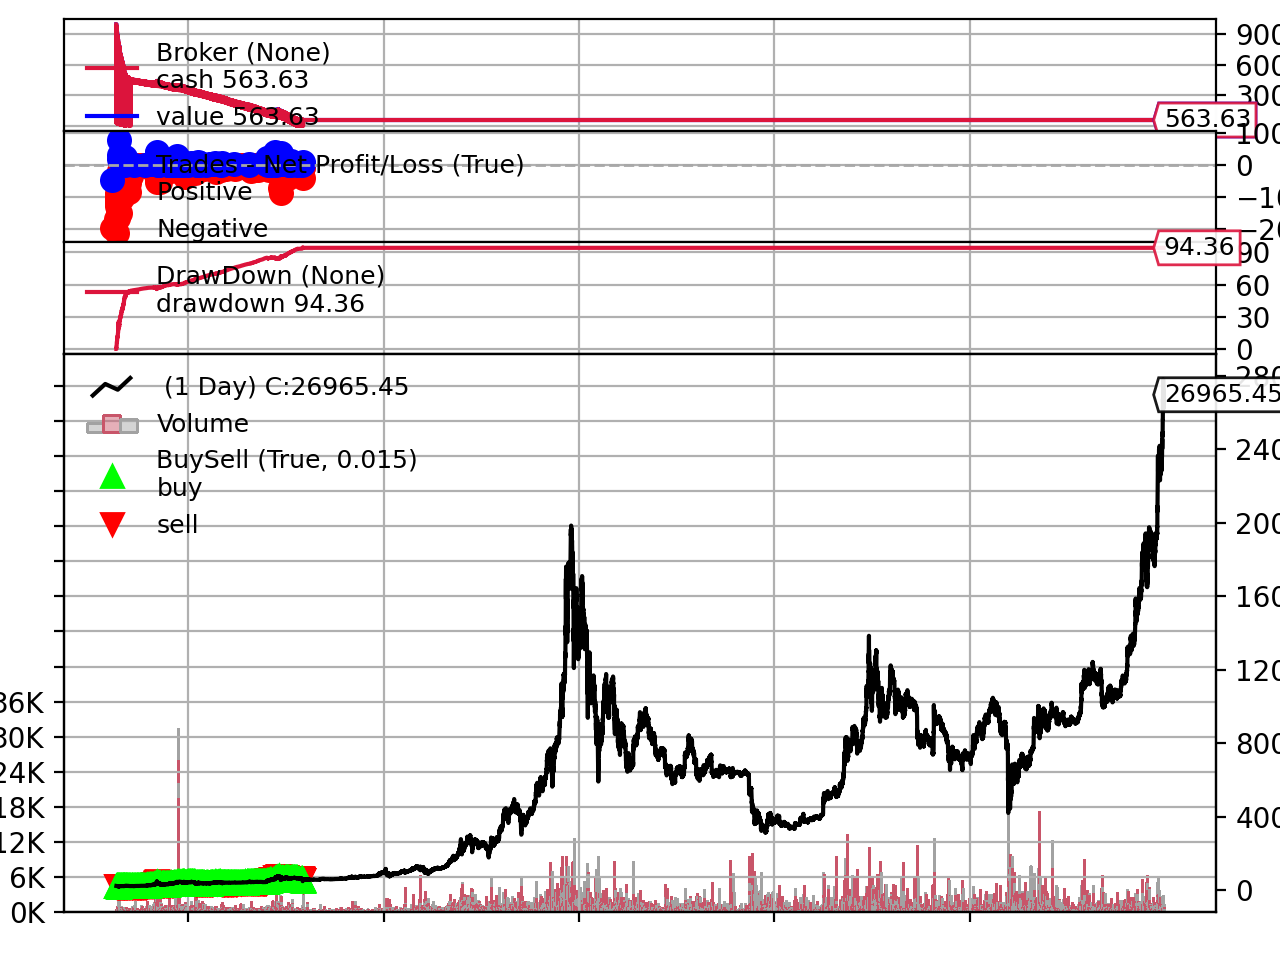

[[<Figure size 640x480 with 5 Axes>]]

In [23]:
cerebro.plot()